In [1]:
import requests
from requests.auth import HTTPBasicAuth
import astropy.table as at
import matplotlib
from matplotlib.transforms import Bbox
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import astropy.units as u
from astropy.visualization import PercentileInterval, AsinhStretch
from astroquery.mast import Catalogs
from astroquery.sdss import SDSS
from astroquery.simbad import Simbad

import os
import sys
import shutil
import glob
import json

import warnings
warnings.filterwarnings("ignore")


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA


import antares_client

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [3]:
def panstarrs_image_filename(position,image_size=None, filter=None):
    """Query panstarrs service to get a list of image names
    Parameters
    ----------
    :position : :class:`~astropy.coordinates.SkyCoord`
        Target centre position of the cutout image to be downloaded.
    :size : int: cutout image size in pixels.
    :filter: str: Panstarrs filter (g r i z y)
    Returns
    -------
    :filename: str: file name of the cutout
    """

    service = 'https://ps1images.stsci.edu/cgi-bin/ps1filenames.py'
    url = (f'{service}?ra={position.ra.degree}&dec={position.dec.degree}'
           f'&size={image_size}&format=fits&filters={filter}')

    filename_table = pd.read_csv(url, delim_whitespace=True)['filename']
    return filename_table[0] if len(filename_table) > 0 else None

    
def panstarrs_cutout(position, filename, image_size=None, filter=None):
    """
    Download Panstarrs cutout from their own service
    Parameters
    ----------
    :position : :class:`~astropy.coordinates.SkyCoord`
        Target centre position of the cutout image to be downloaded.
    :image_size: int: size of cutout image in pixels
    :filter: str: Panstarrs filter (g r i z y)
    Returns
    -------
    :cutout : :class:`~astropy.io.fits.HDUList` or None
    """
    
    if filename:
        service = 'https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?'
        fits_url = (f'{service}ra={position.ra.degree}&dec={position.dec.degree}'
                    f'&size={image_size}&format=fits&red={filename}')
        fits_image = fits.open(fits_url)
    else:
        fits_image = None

    return fits_image

In [4]:
def host_pdfs(df,imsizepix=100,change_contrast=False):
        
        # let's make a PDF with all the host gal coords
        # so we can look through by eye and see which ones

        ref_name = df.name[0]
        data = df
        
        pdf_pages = PdfPages(f'../figures/{ref_name}_host_thumbnails_manhattan.pdf')

        for i, d in df.iterrows():
            
            stamp_path = f"../ps1_cutouts/{d['name']}_pscutout.fits"
            if os.path.isfile(stamp_path): 
                #print(f"Remove previously saved cutout {d['name']}_pscutout.fits to download new one")
                os.remove(stamp_path)
            
            #if i > 20: break
            if not i % 9:
                fig = plt.figure(figsize=(6,6))
                
            #fig = plt.figure()
            
            ax = plt.subplot(3,3,i%9+1)

            ax.set_xticks([])
            ax.set_yticks([])

            # download the PS image
            sc = SkyCoord(d['ra'],d['dec'],unit=u.deg)

            outfilename = f"../ps1_cutouts/{d['name']}_pscutout.fits"
            if not os.path.exists(outfilename):
                filename = panstarrs_image_filename(sc,image_size=imsizepix,filter='r')
                fits_image = panstarrs_cutout(sc,filename,image_size=imsizepix,filter='r')
                fits_image.writeto(outfilename)
                
            wcs = WCS(f"../ps1_cutouts/{d['name']}_pscutout.fits")

            imdata = fits.getdata(f"../ps1_cutouts/{d['name']}_pscutout.fits")

            if change_contrast==True:
                transform = AsinhStretch() + PercentileInterval(93)
            
            else: transform = AsinhStretch() + PercentileInterval(99.5)
            bfim = transform(imdata)
            ax.imshow(bfim,cmap="gray",origin="lower")
            #ax.plot(imsizepix/2,imsizepix/2,'+',color='r',ms=15)
                
            ax.set_title(f"{d['name']}",pad=1, fontsize=14)

            if i % 9 == 8:
                plt.ion()
                plt.show()
                #plt.subplots_adjust(0,0,1,1,-0.05,0.05)
                pdf_pages.savefig(fig, bbox_inches='tight', pad_inches=0.1)
                plt.close()
         
        pdf_pages.close()
        plt.show()
        

In [5]:
class AnnoyIndex():
    def __init__(self, vectors, labels, metric):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
        self.metric= metric
   
    def build(self, number_of_trees=100):
        self.index = annoy.AnnoyIndex(self.dimension, self.metric)
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=1000):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=-1)                                           
        return [self.labels[i] for i in indices]
    
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         'feature_linear_trend_magn_r',
                         'feature_linear_trend_sigma_magn_r',
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         'feature_period_s_to_n_0_magn_r',
                         #'feature_period_1_magn_r', 
                         'feature_period_s_to_n_1_magn_r',
                         #'feature_period_2_magn_r', 
                         'feature_period_s_to_n_2_magn_r',
                         #'feature_period_3_magn_r', 
                         'feature_period_s_to_n_3_magn_r',
                         #'feature_period_4_magn_r', 
                         'feature_period_s_to_n_4_magn_r',
                         #'feature_periodogram_amplitude_magn_r',
                         'feature_periodogram_beyond_2_std_magn_r',
                         'feature_periodogram_beyond_3_std_magn_r',
                         'feature_periodogram_standard_deviation_magn_r', 
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         'feature_linear_trend_magn_g',
                         'feature_linear_trend_sigma_magn_g',
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         'feature_period_s_to_n_0_magn_g',
                         #'feature_period_1_magn_g', 
                         'feature_period_s_to_n_1_magn_g',
                         #'feature_period_2_magn_g', 
                         'feature_period_s_to_n_2_magn_g',
                         #'feature_period_3_magn_g', 
                         'feature_period_s_to_n_3_magn_g',
                         #'feature_period_4_magn_g', 
                         'feature_period_s_to_n_4_magn_g',
                         #'feature_periodogram_amplitude_magn_g',
                         'feature_periodogram_beyond_2_std_magn_g',
                         'feature_periodogram_beyond_3_std_magn_g',
                         'feature_periodogram_standard_deviation_magn_g', 
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
#   'zmomentXX',
#  'zmomentXY',
#  'zmomentYY',
#  'zmomentR1',
#  'zmomentRH',
#  'zPSFFlux',
# #  'zPSFFluxErr',
#  'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
#  'zKronFlux',
# #  'zKronFluxErr',
#  'zKronRad',
# #  'zexpTime',
#   'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
#   'ymomentXX',
#   'ymomentXY',
#   'ymomentYY',
#   'ymomentR1',
#   'ymomentRH',
#   'yPSFFlux',
# #   'yPSFFluxErr',
#   'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
#  'yKronFlux',
# #  'yKronFluxErr',
#  'yKronRad',
# #  'yexpTime',
#   'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
#    'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
#  'zApMag_zKronMag',
#  'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

lc_and_host_features = feature_names_r_g+feature_names_hostgal

In [6]:
# dataset was created by dropping 'sdss_stars', 'asassn_variable_catalog', 'asassn_variable_catalog_v2_20190802', 'veron_agn_qso'
# 'bright_guide_star_cat' is sometimes a galaxy, so keep
dataset_bank_90k = pd.read_csv('../loci_dbs/loci_df_271688objects_cut_stars_and_gal_plane_transf.csv', 
                                   compression='gzip',
                                   usecols=lambda c: c in ztf_id_and_features_r_g,)
                                  #)
        
# drop row if any feature values are nan
dataset_bank_90k = dataset_bank_90k[~dataset_bank_90k[feature_names_r_g].isnull().any(axis=1)]

#mask = (dataset_bank['num_mag_values'] >= 40) #& (dataset_bank['num_mag_values'] <= 40)
#dataset_bank = dataset_bank[mask]
dataset_bank_90k.drop_duplicates(subset="ztf_object_id", keep='first', inplace=True)
dataset_bank_90k = dataset_bank_90k.set_index('ztf_object_id')
dataset_bank_90k.index.rename("TransientName", inplace=True)
dataset_bank_90k

Unnamed: 0        locus_id          ra        dec  \
TransientName                                                      
ZTF20acpdyyq            6    ANT2020rajqu   33.976088 -20.258905   
ZTF18acfvwwa           39    ANT2020pc6ko   35.639509  32.833982   
ZTF17aaaskvj           58    ANT2020rdpmm   28.015003  36.953217   
ZTF18aczbnhl           97    ANT2019dsk24   85.049145 -11.013302   
ZTF18actbhqt           98    ANT202066j3s   75.082443 -11.302676   
...                   ...             ...         ...        ...   
ZTF18adairvu       999924    ANT2020ro626   84.348727  -2.927551   
ZTF20aaiwhct       999926    ANT2020pxghw   64.146691  -1.656598   
ZTF20aberawv       999927    ANT2020aebbk  292.910293  54.078978   
ZTF21abhjyor       999964  ANT2020aeedowi  323.724711  31.249401   
ZTF18acfdttb       999987    ANT2020fc5ny  295.091491  55.660204   

                                              tags  \
TransientName                                        
ZTF20acpdyyq              ['lc_feature_extractor']   
ZTF18acfvwwa              ['lc_feature_extractor']   
ZTF17aaaskvj              ['lc_feature_extractor']   
ZTF18aczbnhl              ['lc_feature_extractor']   
ZTF18actbhqt              ['lc_feature_extractor']   
...                                            ...   
ZTF18adairvu              ['lc_feature_extractor']   
ZTF20aaiwhct   ['dimmers', 'lc_feature_extractor']   
ZTF20aberawv   ['lc_feature_extractor', 'dimmers']   
ZTF21abhjyor              ['lc_feature_extractor']   
ZTF18acfdttb   ['lc_feature_extractor', 'dimmers']   

                                                        catalogs ztf_ssnamenr  \
TransientName                                                                   
ZTF20acpdyyq   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
ZTF18acfvwwa   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
ZTF17aaaskvj   ['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...          NaN   
ZTF18aczbnhl   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
ZTF18actbhqt   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
...                                                          ...          ...   
ZTF18adairvu   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
ZTF20aaiwhct    ['gaia_dr2', 'bright_guide_star_cat', 'allwise']          NaN   
ZTF20aberawv                                                  []          NaN   
ZTF21abhjyor                                                  []          NaN   
ZTF18acfdttb   ['2mass_psc', 'allwise', 'gaia_dr2', 'bright_g...          NaN   

               num_alerts  num_mag_values                    oldest_alert_id  \
TransientName                                                                  
ZTF20acpdyyq          137              35   ztf_candidate:993481181415010007   
ZTF18acfvwwa          659              88   ztf_candidate:943483942915015010   
ZTF17aaaskvj         1497             579   ztf_candidate:598425334815010002   
ZTF18aczbnhl          105              12   ztf_candidate:718232301815010005   
ZTF18actbhqt           89              14   ztf_candidate:702289832715010026   
...                   ...             ...                                ...   
ZTF18adairvu           96              10   ztf_candidate:722282332515010003   
ZTF20aaiwhct           86              35  ztf_candidate:1113204944015010026   
ZTF20aberawv          235              96  ztf_candidate:1231482062015010023   
ZTF21abhjyor          118              19  ztf_candidate:1358283950415015003   
ZTF18acfdttb          290              14   ztf_candidate:966286933415010005   

               ...  anom_score  anomaly_score anomaly_mask  anomaly_type  \
TransientName  ...                                                         
ZTF20acpdyyq   ...         NaN            NaN          NaN           NaN   
ZTF18acfvwwa   ...         NaN            NaN          NaN           NaN   
ZTF17aaaskvj   ...         N

In [7]:
%%time

# Instead of above, read in from csv files with host gal info!
# Visually vetted GHOST results split up over XXX files
# So merge them

dfs = []
for start_idx, end_idx in zip(range(0, 90100, 100), range(100, 90200, 100)): #90199, 90299
    df = pd.read_csv(f'./host_info/dataset_bank_hosts_start_idx:end_idx={start_idx}:{end_idx}.csv')
    dfs.append(df)
    
g_hosts_df = pd.concat(dfs, axis=0).reset_index(drop=True)
g_hosts_df.drop_duplicates(subset="TransientName", keep='first', inplace=True)
g_hosts_df = g_hosts_df.set_index('TransientName')
g_hosts_df.sort_values('TransientName', inplace=True)
#g_hosts_df.reset_index(inplace=True, drop=True)
g_hosts_df

CPU times: user 20.6 s, sys: 1.41 s, total: 22.1 s
Wall time: 24.3 s


objName  objAltName1  objAltName2  \
TransientName                                                          
AT2019ye        PSO J135804.487+203809.056          NaN          NaN   
PS18acw         PSO J203708.962-044523.671          NaN          NaN   
PS18kz          PSO J132531.079-142122.461          NaN          NaN   
SDSS-IISN17461  PSO J034305.548+001507.550          NaN          NaN   
SN2016ezh       PSO J015804.744+005221.791          NaN          NaN   
...                                    ...          ...          ...   
ZTF21acqetxn    PSO J235011.541+191045.231          NaN          NaN   
ZTF21acqnurt    PSO J223925.671-022448.679          NaN          NaN   
ZTF21acqoloi    PSO J231829.296-011726.224          NaN          NaN   
ZTF21acqqnqg    PSO J220138.675-131925.285          NaN          NaN   
ZTF21acqtdnd    PSO J093828.017+725409.070          NaN          NaN   

                objAltName3               objID    uniquePspsOBid  \
TransientName                                                       
AT2019ye                NaN  132762095186853570   916270000024592   
PS18acw                 NaN  102293092873892523  1049658000060517   
PS18kz                  NaN   90772013794782874  1040248000047767   
SDSS-IISN17461          NaN  107690557731417905   943938000022176   
SN2016ezh               NaN  106950295197783171   927303000104953   
...                     ...                 ...               ...   
ZTF21acqetxn            NaN  131013575480825509  1076778000026511   
ZTF21acqnurt            NaN  105103398569764184  1076249000094978   
ZTF21acqoloi            NaN  106453496221281681  1082715000043887   
ZTF21acqqnqg            NaN   92013304111661908  1034256000047270   
ZTF21acqtdnd            NaN  195481446166893818  1082796000034886   

                       ippObjID  surveyID           htmID  zoneID  ...  \
TransientName                                                      ...   
AT2019ye        143378893266959         0  14931762990582   13276  ...   
PS18acw         397026776902759         0  12246887638605   10229  ...   
PS18kz          422246824852118         0  11265143992289    9077  ...   
SDSS-IISN17461  365716465276576         0   9423182795338   10769  ...   
SN2016ezh       363457312561658         0   8961418540888   10695  ...   
...                         ...       ...             ...     ...  ...   
ZTF21acqetxn    161254547154832         0  13215295323352   13101  ...   
ZTF21acqnurt    400995326718721         0  12661889120003   10510  ...   
ZTF21acqoloi    401837140257649         0  12704687240487   10645  ...   
ZTF21acqqnqg    439985039784102         0  12743362206187    9201  ...   
ZTF21acqtdnd    343739117635654         0  15896420451026   19548  ...   

                primaryDetection_y   gpetR90  rpetR90  ipetR90  zpetR90  \
TransientName                                                             
AT2019ye                       NaN       NaN      NaN      NaN      NaN   
PS18acw                        NaN       NaN      NaN      NaN      NaN   
PS18kz                         NaN       NaN      NaN      NaN      NaN   
SDSS-IISN17461                 NaN       NaN      NaN      NaN      NaN   
SN2016ezh                      NaN       NaN      NaN      NaN      NaN   
...                            ...       ...      ...      ...      ...   
ZTF21acqetxn                   1.0  11.96380  5.68306  3.76124  3.02015   
ZTF21acqnurt                   1.0  15.28430  2.52730  1.53292  1.24170   
ZTF21acqoloi                   1.0       NaN  9.90200  2.44196  1.46597   
ZTF21acqqnqg                   1.0   1.55909      NaN      NaN      NaN   
ZTF21acqtdnd                   1.0   2.12782  1.17645  1.70294  1.72939   

                ypetR90  NED_redshift_flag  hasSimbad  class  level_0  
TransientName                                                          
AT2019ye            NaN                NaN        NaN    NaN      NaN  
PS18acw             NaN                NaN   

In [8]:
len(np.unique(g_hosts_df.index))

24126

In [9]:
# merge ghost info and databank info

# rename as dataset_bank
dataset_bank = pd.merge(dataset_bank_90k, g_hosts_df, left_index=True, right_index=True, how='inner')
dataset_bank.index.rename("ztf_object_id", inplace=True)
dataset_bank.to_csv('../dataframes/dataset_bank.csv')
dataset_bank

Unnamed: 0        locus_id          ra        dec  \
ztf_object_id                                                      
ZTF20acpdyyq            6    ANT2020rajqu   33.976088 -20.258905   
ZTF18acfvwwa           39    ANT2020pc6ko   35.639509  32.833982   
ZTF17aaaskvj           58    ANT2020rdpmm   28.015003  36.953217   
ZTF18actbhqt           98    ANT202066j3s   75.082443 -11.302676   
ZTF20aciscxz          100  ANT2020aegc7vi   83.973369  -9.123083   
...                   ...             ...         ...        ...   
ZTF19aaweyrl       998543    ANT2020ay2n2  345.352155  29.567523   
ZTF18aaxheyx       998559    ANT2020dpu72  252.069272  57.974137   
ZTF20abhzatf       998591    ANT2020c3ksm  337.612801  15.317709   
ZTF18aasbhzf       998605    ANT2018brtio  238.621821  49.056094   
ZTF21aamjuma       998678    ANT2020as5g6  173.338794  78.671393   

                                                            tags  \
ztf_object_id                                                      
ZTF20acpdyyq                            ['lc_feature_extractor']   
ZTF18acfvwwa                            ['lc_feature_extractor']   
ZTF17aaaskvj                            ['lc_feature_extractor']   
ZTF18actbhqt                            ['lc_feature_extractor']   
ZTF20aciscxz   ['lc_feature_extractor', 'high_flux_ratio_wrt_...   
...                                                          ...   
ZTF19aaweyrl                            ['lc_feature_extractor']   
ZTF18aaxheyx                            ['lc_feature_extractor']   
ZTF20abhzatf                            ['lc_feature_extractor']   
ZTF18aasbhzf                            ['lc_feature_extractor']   
ZTF21aamjuma                            ['lc_feature_extractor']   

                                                        catalogs ztf_ssnamenr  \
ztf_object_id                                                                   
ZTF20acpdyyq   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
ZTF18acfvwwa   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
ZTF17aaaskvj   ['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...          NaN   
ZTF18actbhqt   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
ZTF20aciscxz                ['allwise', 'bright_guide_star_cat']          NaN   
...                                                          ...          ...   
ZTF19aaweyrl    ['gaia_dr2', 'allwise', 'bright_guide_star_cat']          NaN   
ZTF18aaxheyx   ['gaia_dr2', 'allwise', '2mass_psc', 'bright_g...          NaN   
ZTF20abhzatf   ['bright_guide_star_cat', 'allwise', 'gaia_dr2...          NaN   
ZTF18aasbhzf                             ['gaia_dr2', 'allwise']          NaN   
ZTF21aamjuma   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   

               num_alerts  num_mag_values                    oldest_alert_id  \
ztf_object_id                                                                  
ZTF20acpdyyq          137              35   ztf_candidate:993481181415010007   
ZTF18acfvwwa          659              88   ztf_candidate:943483942915015010   
ZTF17aaaskvj         1497             579   ztf_candidate:598425334815010002   
ZTF18actbhqt           89              14   ztf_candidate:702289832715010026   
ZTF20aciscxz           48              18  ztf_candidate:1356481843915015002   
...                   ...             ...                                ...   
ZTF19aaweyrl          354             244   ztf_candidate:880431555615015015   
ZTF18aaxheyx          467              12   ztf_candidate:947281676115015110   
ZTF20abhzatf          377              42  ztf_candidate:1245430851515015125   
ZTF18aasbhzf          264              18   ztf_candidate:533261233215015023   
ZTF21aamjuma          561             107   ztf_candidate:711540675115010006   

               ...  primaryDetection_y   gpetR90  rpetR90    ipetR90  zpetR90  \
ztf_object_id  ...                                                   

In [10]:
dataset_bank.columns.to_list()

['Unnamed: 0',
 'locus_id',
 'ra',
 'dec',
 'tags',
 'catalogs',
 'ztf_ssnamenr',
 'num_alerts',
 'num_mag_values',
 'oldest_alert_id',
 'oldest_alert_magnitude',
 'oldest_alert_observation_time',
 'newest_alert_id',
 'newest_alert_magnitude',
 'newest_alert_observation_time',
 'brightest_alert_id',
 'brightest_alert_magnitude',
 'brightest_alert_observation_time',
 'feature_amplitude_magn_g',
 'feature_anderson_darling_normal_magn_g',
 'feature_beyond_1_std_magn_g',
 'feature_beyond_2_std_magn_g',
 'feature_cusum_magn_g',
 'feature_inter_percentile_range_2_magn_g',
 'feature_inter_percentile_range_10_magn_g',
 'feature_inter_percentile_range_25_magn_g',
 'feature_kurtosis_magn_g',
 'feature_linear_fit_slope_magn_g',
 'feature_linear_fit_slope_sigma_magn_g',
 'feature_linear_trend_magn_g',
 'feature_linear_trend_sigma_magn_g',
 'feature_magnitude_percentage_ratio_40_5_magn_g',
 'feature_magnitude_percentage_ratio_20_5_magn_g',
 'feature_mean_magn_g',
 'feature_median_absolute_deviation

In [11]:
# only keep features of bank
dataset_bank_orig = dataset_bank[lc_and_host_features]
dataset_bank_orig.isnull().sum().to_dict() # see which columns have most NaNs

{'feature_amplitude_magn_r': 0,
 'feature_anderson_darling_normal_magn_r': 0,
 'feature_beyond_1_std_magn_r': 0,
 'feature_beyond_2_std_magn_r': 0,
 'feature_cusum_magn_r': 0,
 'feature_inter_percentile_range_2_magn_r': 0,
 'feature_inter_percentile_range_10_magn_r': 0,
 'feature_inter_percentile_range_25_magn_r': 0,
 'feature_kurtosis_magn_r': 0,
 'feature_linear_fit_slope_magn_r': 0,
 'feature_linear_fit_slope_sigma_magn_r': 0,
 'feature_linear_trend_magn_r': 0,
 'feature_linear_trend_sigma_magn_r': 0,
 'feature_magnitude_percentage_ratio_40_5_magn_r': 0,
 'feature_magnitude_percentage_ratio_20_5_magn_r': 0,
 'feature_mean_magn_r': 0,
 'feature_median_absolute_deviation_magn_r': 0,
 'feature_percent_amplitude_magn_r': 0,
 'feature_median_buffer_range_percentage_10_magn_r': 0,
 'feature_median_buffer_range_percentage_20_magn_r': 0,
 'feature_percent_difference_magnitude_percentile_5_magn_r': 0,
 'feature_percent_difference_magnitude_percentile_10_magn_r': 0,
 'feature_period_s_to_n_0_

In [12]:
# only keep features of bank
dataset_bank_orig = dataset_bank[lc_and_host_features] #dataset_bank[feature_names_r_g]
# drop row if any feature values are nan
dataset_bank_orig = dataset_bank_orig[~dataset_bank_orig[lc_and_host_features].isnull().any(axis=1)]

dataset_bank_orig

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF20acpdyyq                   0.514069   
ZTF18acfvwwa                   0.593122   
ZTF20aciscxz                   0.285049   
ZTF18abdkosj                   1.776150   
ZTF18abrcoty                   0.072900   
...                                 ...   
ZTF18aczcgiz                   0.542735   
ZTF19aaweyrl                   0.730350   
ZTF18aaxheyx                   0.932036   
ZTF18aasbhzf                   0.373769   
ZTF21aamjuma                   0.559700   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF20acpdyyq                                -0.037026   
ZTF18acfvwwa                                -0.303523   
ZTF20aciscxz                                -0.425467   
ZTF18abdkosj                                -0.175299   
ZTF18abrcoty                                -0.738972   
...                                               ...   
ZTF18aczcgiz                                -0.273649   
ZTF19aaweyrl                                 0.246070   
ZTF18aaxheyx                                -0.808006   
ZTF18aasbhzf                                -0.490598   
ZTF21aamjuma                                -0.183647   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF20acpdyyq                      0.230769                     0.277350   
ZTF18acfvwwa                      0.303030                     0.246183   
ZTF20aciscxz                      0.384615                     0.000000   
ZTF18abdkosj                      0.200000                     0.000000   
ZTF18abrcoty                      0.250000                     0.000000   
...                                    ...                          ...   
ZTF18aczcgiz                      0.300000                     0.000000   
ZTF19aaweyrl                      0.372727                     0.190693   
ZTF18aaxheyx                      0.400000                     0.000000   
ZTF18aasbhzf                      0.444444                     0.000000   
ZTF21aamjuma                      0.361702                     0.206284   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF20acpdyyq               0.210596                                 1.028137   
ZTF18acfvwwa               0.272132                                 1.152622   
ZTF20aciscxz               0.375905                                 0.570099   
ZTF18abdkosj               0.353906                                 3.552299   
ZTF18abrcoty               0.358274                                 0.145800   
...                             ...                                      ...   
ZTF18aczcgiz               0.372288                                 1.085470   
ZTF19aaweyrl               0.338388                                 1.277634   
ZTF18aaxheyx               0.372088                                 1.864073   
ZTF18aasbhzf               0.332573                                 0.747538   
ZTF21aamjuma               0.208213                                 1.047781   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF20acpdyyq                                   0.606000   
ZTF18acfvwwa                                   0.729088   
ZTF20aciscxz                                   0.455701   
ZTF18abdkosj                                   3.552299   
ZTF18abrcoty                                   0.145800   
...                                                 ...   
ZTF18aczcgiz                                   0.911212   
ZTF19aaweyrl                                   0.798832   
ZTF18aaxheyx                                   1.864073   
ZTF18aasbhzf                                   

In [13]:
dataset_bank_host_ra_dec = dataset_bank[['raMean', 'decMean']]

dataset_bank_orig_host_ra_dec = pd.concat([dataset_bank_host_ra_dec, dataset_bank_orig], axis=1)
dataset_bank_orig_host_ra_dec.to_csv('../dataframes/dataset_bank_orig_host_ra_dec.csv')
dataset_bank_orig_host_ra_dec

raMean    decMean  feature_amplitude_magn_r  \
ztf_object_id                                                    
ZTF20acpdyyq    33.970428 -20.262357                  0.514069   
ZTF18acfvwwa    35.632326  32.837878                  0.593122   
ZTF17aaaskvj    28.019186  36.949659                       NaN   
ZTF18actbhqt    75.082493 -11.302689                       NaN   
ZTF20aciscxz    83.973390  -9.123059                  0.285049   
...                   ...        ...                       ...   
ZTF19aaweyrl   345.352146  29.567533                  0.730350   
ZTF18aaxheyx   252.077199  57.976291                  0.932036   
ZTF20abhzatf   337.612622  15.317868                       NaN   
ZTF18aasbhzf   238.602751  49.060376                  0.373769   
ZTF21aamjuma   173.360681  78.670541                  0.559700   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF20acpdyyq                                -0.037026   
ZTF18acfvwwa                                -0.303523   
ZTF17aaaskvj                                      NaN   
ZTF18actbhqt                                      NaN   
ZTF20aciscxz                                -0.425467   
...                                               ...   
ZTF19aaweyrl                                 0.246070   
ZTF18aaxheyx                                -0.808006   
ZTF20abhzatf                                      NaN   
ZTF18aasbhzf                                -0.490598   
ZTF21aamjuma                                -0.183647   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF20acpdyyq                      0.230769                     0.277350   
ZTF18acfvwwa                      0.303030                     0.246183   
ZTF17aaaskvj                           NaN                          NaN   
ZTF18actbhqt                           NaN                          NaN   
ZTF20aciscxz                      0.384615                     0.000000   
...                                    ...                          ...   
ZTF19aaweyrl                      0.372727                     0.190693   
ZTF18aaxheyx                      0.400000                     0.000000   
ZTF20abhzatf                           NaN                          NaN   
ZTF18aasbhzf                      0.444444                     0.000000   
ZTF21aamjuma                      0.361702                     0.206284   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF20acpdyyq               0.210596                                 1.028137   
ZTF18acfvwwa               0.272132                                 1.152622   
ZTF17aaaskvj                    NaN                                      NaN   
ZTF18actbhqt                    NaN                                      NaN   
ZTF20aciscxz               0.375905                                 0.570099   
...                             ...                                      ...   
ZTF19aaweyrl               0.338388                                 1.277634   
ZTF18aaxheyx               0.372088                                 1.864073   
ZTF20abhzatf                    NaN                                      NaN   
ZTF18aasbhzf               0.332573                                 0.747538   
ZTF21aamjuma               0.208213                                 1.047781   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF20acpdyyq                                   0.606000   
ZTF18acfvwwa                                   0.729088   
ZTF17aaaskvj                                        NaN   
ZTF18actbhqt                                        NaN   
ZTF20aciscxz                                   

In [14]:
dataset_bank_catalogs = dataset_bank[['catalogs']]

dataset_bank_orig_catalogs = pd.concat([dataset_bank_catalogs, dataset_bank_orig], axis=1)

# bright_guide_star_cat unfortunately has some non stars that are good galaxies with SN in them...
dataset_bank_orig_catalogs_no_bright_star = dataset_bank_orig_catalogs[~dataset_bank_orig_catalogs['catalogs'].str.contains('bright_guide_star_cat')]
dataset_bank_orig_catalogs_no_bright_star.to_csv('../dataframes/dataset_bank_orig_catalogs_no_bright_guide_star_cat.csv')
dataset_bank_orig_catalogs_no_bright_star

catalogs  feature_amplitude_magn_r  \
ztf_object_id                                                      
ZTF18abrcoty             ['2mass_xsc']                  0.072900   
ZTF18aatckag   ['allwise', 'gaia_dr2']                  0.260850   
ZTF18aahqtqd   ['gaia_dr2', 'allwise']                       NaN   
ZTF18acdzyog   ['allwise', 'gaia_dr2']                  0.429050   
ZTF21aasfdps                        []                  0.077326   
...                                ...                       ...   
ZTF21aawkuqe             ['sdss_gals']                  0.225066   
ZTF18acpiqbm              ['gaia_dr2']                       NaN   
ZTF18abjgyiu                        []                  0.423750   
ZTF18adgnfgl                        []                       NaN   
ZTF18aasbhzf   ['gaia_dr2', 'allwise']                  0.373769   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF18abrcoty                                -0.738972   
ZTF18aatckag                                -0.733969   
ZTF18aahqtqd                                      NaN   
ZTF18acdzyog                                -0.728171   
ZTF21aasfdps                                -1.108203   
...                                               ...   
ZTF21aawkuqe                                -0.709051   
ZTF18acpiqbm                                      NaN   
ZTF18abjgyiu                                -0.183864   
ZTF18adgnfgl                                      NaN   
ZTF18aasbhzf                                -0.490598   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF18abrcoty                      0.250000                     0.000000   
ZTF18aatckag                      0.285714                     0.000000   
ZTF18aahqtqd                           NaN                          NaN   
ZTF18acdzyog                      0.333333                     0.000000   
ZTF21aasfdps                      0.500000                     0.000000   
...                                    ...                          ...   
ZTF21aawkuqe                      0.285714                     0.000000   
ZTF18acpiqbm                           NaN                          NaN   
ZTF18abjgyiu                      0.245614                     0.229416   
ZTF18adgnfgl                           NaN                          NaN   
ZTF18aasbhzf                      0.444444                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF18abrcoty               0.358274                                 0.145800   
ZTF18aatckag               0.339135                                 0.521700   
ZTF18aahqtqd                    NaN                                      NaN   
ZTF18acdzyog               0.383885                                 0.858101   
ZTF21aasfdps               0.368934                                 0.154652   
...                             ...                                      ...   
ZTF21aawkuqe               0.371334                                 0.450132   
ZTF18acpiqbm                    NaN                                      NaN   
ZTF18abjgyiu               0.169273                                 0.737164   
ZTF18adgnfgl                    NaN                                      NaN   
ZTF18aasbhzf               0.332573                                 0.747538   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF18abrcoty                                   0.145800   
ZTF18aatckag                                   0.483200   
ZTF18aahqtqd                                        NaN   
ZTF18acdzyog                                   0.806322   
ZTF21aasfdps                    

In [15]:
# Choose a dataframe!!

dataset_bank_orig = dataset_bank_orig
#dataset_bank_orig = dataset_bank_orig_catalogs_no_bright_star.drop(columns=['catalogs'])
#dataset_bank_orig = dataset_bank_orig_host_ra_dec.drop(columns=['raMean', 'decMean'])

# Drop row if any feature values are nan
dataset_bank_orig = dataset_bank_orig[~dataset_bank_orig[lc_and_host_features].isnull().any(axis=1)]
dataset_bank_orig.to_csv('../dataframes/dataset_bank_orig.csv')
dataset_bank_orig

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF20acpdyyq                   0.514069   
ZTF18acfvwwa                   0.593122   
ZTF20aciscxz                   0.285049   
ZTF18abdkosj                   1.776150   
ZTF18abrcoty                   0.072900   
...                                 ...   
ZTF18aczcgiz                   0.542735   
ZTF19aaweyrl                   0.730350   
ZTF18aaxheyx                   0.932036   
ZTF18aasbhzf                   0.373769   
ZTF21aamjuma                   0.559700   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF20acpdyyq                                -0.037026   
ZTF18acfvwwa                                -0.303523   
ZTF20aciscxz                                -0.425467   
ZTF18abdkosj                                -0.175299   
ZTF18abrcoty                                -0.738972   
...                                               ...   
ZTF18aczcgiz                                -0.273649   
ZTF19aaweyrl                                 0.246070   
ZTF18aaxheyx                                -0.808006   
ZTF18aasbhzf                                -0.490598   
ZTF21aamjuma                                -0.183647   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF20acpdyyq                      0.230769                     0.277350   
ZTF18acfvwwa                      0.303030                     0.246183   
ZTF20aciscxz                      0.384615                     0.000000   
ZTF18abdkosj                      0.200000                     0.000000   
ZTF18abrcoty                      0.250000                     0.000000   
...                                    ...                          ...   
ZTF18aczcgiz                      0.300000                     0.000000   
ZTF19aaweyrl                      0.372727                     0.190693   
ZTF18aaxheyx                      0.400000                     0.000000   
ZTF18aasbhzf                      0.444444                     0.000000   
ZTF21aamjuma                      0.361702                     0.206284   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF20acpdyyq               0.210596                                 1.028137   
ZTF18acfvwwa               0.272132                                 1.152622   
ZTF20aciscxz               0.375905                                 0.570099   
ZTF18abdkosj               0.353906                                 3.552299   
ZTF18abrcoty               0.358274                                 0.145800   
...                             ...                                      ...   
ZTF18aczcgiz               0.372288                                 1.085470   
ZTF19aaweyrl               0.338388                                 1.277634   
ZTF18aaxheyx               0.372088                                 1.864073   
ZTF18aasbhzf               0.332573                                 0.747538   
ZTF21aamjuma               0.208213                                 1.047781   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF20acpdyyq                                   0.606000   
ZTF18acfvwwa                                   0.729088   
ZTF20aciscxz                                   0.455701   
ZTF18abdkosj                                   3.552299   
ZTF18abrcoty                                   0.145800   
...                                                 ...   
ZTF18aczcgiz                                   0.911212   
ZTF19aaweyrl                                   0.798832   
ZTF18aaxheyx                                   1.864073   
ZTF18aasbhzf                                   

# TODO: Profiling: do for all data frames, ALSO ADD spec class and ANN dists to to lc+host data ones!

In [16]:
dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df.csv', index_col='ztf_object_id')
dataset_bank_tns_df

has_tns tns_cls  spec_z report_group
ztf_object_id                                     
ZTF20acpdyyq   No_TNS    None   -99.0         None
ZTF18acfvwwa   No_TNS    None   -99.0         None
ZTF17aaaskvj   No_TNS    None   -99.0         None
ZTF18actbhqt   No_TNS    None   -99.0         None
ZTF20aciscxz   No_TNS    None   -99.0         None
...               ...     ...     ...          ...
ZTF19aaweyrl   No_TNS    None   -99.0         None
ZTF18aaxheyx   No_TNS    None   -99.0         None
ZTF20abhzatf   No_TNS    None   -99.0         None
ZTF18aasbhzf   No_TNS    None   -99.0         None
ZTF21aamjuma   No_TNS    None   -99.0         None

[23741 rows x 4 columns]

In [17]:

# https://github.com/uiucsn/laiss/blob/main/LAISS/notebooks/LAISS_tests.ipynb
idx_arr = np.hstack(np.array(dataset_bank_orig.index, dtype='object'))
feat_arr = np.vstack(np.array(dataset_bank_orig, dtype='object'))


#scaler = preprocessing.StandardScaler() # Create a scalar
scaler = preprocessing.MinMaxScaler() # Create a scalar # Good
#scaler = preprocessing.MaxAbsScaler() # Create a scalar # Good

# bad scalars
#scaler = preprocessing.RobustScaler(quantile_range=(33.0, 67.0)) # quantile_range=(25.0, 75.0) good for outliers
#scaler = preprocessing.Normalizer(norm='l2') #norm='max', norm='l1',
#scaler = preprocessing.SplineTransformer(n_knots=5, degree=3, knots='uniform', 
#                                          extrapolation='constant', include_bias=True, order='C')
#scaler = preprocessing.FunctionTransformer(np.cbrt, validate=True)
#scaler = preprocessing.FunctionTransformer(np.conjugate, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)

#print("scaler")
#scaler.fit(feat_arr) # Fit only to training data
#feat_arr_scaled = scaler.transform(feat_arr) # What your model learns on
#print(np.shape(feat_arr_scaled))
#print(feat_arr_scaled)



# #OR try PCA, then scalar
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))
# scaler.fit(feat_arr_scaled) # Fit only to training data
# feat_arr_scaled = scaler.transform(feat_arr_scaled) # What your model learns on

#OR try scalar then PCA
print("pca")
# Initialize PCA with 15 principal components
n_components=25
pca = PCA(n_components=n_components)
feat_arr_scaled = scaler.fit_transform(feat_arr)
feat_arr_scaled = np.array(pca.fit_transform(feat_arr_scaled))

# # #OR try PCA only
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))

# Print the explained variance
print(np.cumsum(pca.explained_variance_ratio_))

# Build ANNOY index of scaled features of dataset_bank
index = AnnoyIndex(feat_arr_scaled, idx_arr, metric='manhattan') #metric='euclidean'
index.build()
# dist metrics: dot is not good, eucl and manhattan are more or less same, 
# hamming is good distance but matches aren't as similar
# angular has best matches?

pca
[0.2065041  0.36607684 0.44809834 0.52339713 0.58660476 0.62179985
 0.65402436 0.68048482 0.70514351 0.7279144  0.74959413 0.76743709
 0.78283751 0.79789372 0.81141001 0.82371415 0.83507649 0.84607965
 0.856542   0.86690343 0.876389   0.88493699 0.89336154 0.90099563
 0.90801081]


# TODO: get Tns classes, do distance distr per class (in diff metrics)

In [18]:
# Scalar then PCA
col_names = [f'PC'+str(i) for i in range(n_components)]
dataset_bank_pca = pd.DataFrame(pca.fit_transform(feat_arr_scaled), columns=col_names)
dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
dataset_bank_pca

# # Just PCA
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca


# # Just PCA, then scalar
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca = scaler.transform(dataset_bank_pca)
# dataset_bank_pca = pd.DataFrame(dataset_bank_pca, columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca

PC0       PC1       PC2       PC3       PC4       PC5  \
ztf_object_id                                                               
ZTF20acpdyyq   0.511818  0.456445  0.298547 -0.435799  0.104584  0.000951   
ZTF18acfvwwa   0.615020  0.562739 -0.037277  0.140402 -0.206723 -0.194519   
ZTF20aciscxz  -0.256754 -0.742976 -0.048415 -0.209558 -0.183202 -0.270683   
ZTF18abdkosj  -0.068852  1.273278 -0.212094 -0.124672  0.803081  0.191683   
ZTF18abrcoty  -0.433417 -0.736429 -0.359087 -0.056552  0.680630  0.456337   
...                 ...       ...       ...       ...       ...       ...   
ZTF18aczcgiz   0.160439  0.696893 -0.630179  0.262557  0.095096 -0.335650   
ZTF19aaweyrl   0.736704  0.112940  0.377076  0.388480 -0.812025 -0.297356   
ZTF18aaxheyx  -1.002336  0.825724 -0.444662  0.004182 -0.254138 -0.051972   
ZTF18aasbhzf   0.096749  0.577655 -0.802850  0.411371  0.172698 -0.133091   
ZTF21aamjuma   0.675743  0.361102 -0.080897  0.069051 -0.342685  0.180418   

                    PC6       PC7       PC8       PC9  ...      PC15  \
ztf_object_id                                          ...             
ZTF20acpdyyq  -0.643036 -0.090835 -0.019184 -0.315459  ... -0.180184   
ZTF18acfvwwa  -0.382700 -0.137558 -0.102758 -0.272989  ...  0.291221   
ZTF20aciscxz   0.139764 -0.293568  0.041977  0.349665  ...  0.097763   
ZTF18abdkosj   0.396531  0.623919 -0.121100  0.348197  ...  0.118027   
ZTF18abrcoty   0.140240 -0.238542  0.551843 -0.095553  ... -0.221657   
...                 ...       ...       ...       ...  ...       ...   
ZTF18aczcgiz   0.214551  0.005752 -0.227721 -0.230319  ...  0.323277   
ZTF19aaweyrl   0.072653  0.184875  0.453962  0.274548  ... -0.017978   
ZTF18aaxheyx  -0.145289  0.100675  0.132994  0.149232  ... -0.225911   
ZTF18aasbhzf   0.339193  0.013837  0.003372 -0.270719  ... -0.088160   
ZTF21aamjuma  -0.167939 -0.206442 -0.150531 -0.196581  ... -0.016441   

                   PC16      PC17      PC18      PC19      PC20      PC21  \
ztf_object_id                                                               
ZTF20acpdyyq   0.023385  0.069557 -0.052138  0.160847 -0.054357 -0.041780   
ZTF18acfvwwa   0.058330  0.068592 -0.072299  0.121445 -0.007637 -0.022361   
ZTF20aciscxz   0.028772  0.048494 -0.031333  0.238530 -0.231106 -0.047648   
ZTF18abdkosj  -0.336105 -0.010173 -0.007460  0.213724 -0.092866 -0.063358   
ZTF18abrcoty  -0.180031 -0.254139  0.014310  0.159587 -0.262389 -0.019723   
...                 ...       ...       ...       ...       ...       ...   
ZTF18aczcgiz   0.149889 -0.101420 -0.050562 -0.056362 -0.310081  0.045390   
ZTF19aaweyrl   0.006561  0.112655  0.120642  0.032068 -0.018965  0.001691   
ZTF18aaxheyx  -0.062102  0.287722 -0.089547 -0.144347  0.075917  0.132270   
ZTF18aasbhzf   0.190466  0.076688 -0.043454  0.319231  0.058287 -0.037774   
ZTF21aamjuma   0.059932  0.201102 -0.093745  0.035758 -0.011007 -0.154335   

                   PC22      PC23      PC24  
ztf_object_id                                
ZTF20acpdyyq  -0.117817  0.102755 -0.004341  
ZTF18acfvwwa   0.054615  0.235653  0.008599  
ZTF20aciscxz   0.158622 -0.055614 -0.044338  
ZTF18abdkosj   0.062848  0.105487 -0.102110  
ZTF18abrcoty   0.058113  0.337689  0.122494  
...                 ...       ...       ...  
ZTF18aczcgiz   0.053976 -0.089954  0.035542  
ZTF19aaweyrl   0.084531  0.067526  0.328871  
ZTF18aaxheyx  -0.088534  0.173032 -0.065017  
ZTF18aasbhzf   0.032374 -0.153508 -0.047006  
ZTF21aamjuma  -0.119678 -0.075472 -0.076732  

[18998 rows x 25 columns]

In [19]:
dataset_bank_tns_and_pca_df = pd.concat([dataset_bank_pca, dataset_bank_tns_df], axis=1)
dataset_bank_tns_and_pca_df = dataset_bank_tns_and_pca_df[~dataset_bank_tns_and_pca_df.isnull().any(axis=1)]
dataset_bank_tns_and_pca_df

PC0       PC1       PC2       PC3       PC4       PC5  \
ztf_object_id                                                               
ZTF20acpdyyq   0.511818  0.456445  0.298547 -0.435799  0.104584  0.000951   
ZTF18acfvwwa   0.615020  0.562739 -0.037277  0.140402 -0.206723 -0.194519   
ZTF20aciscxz  -0.256754 -0.742976 -0.048415 -0.209558 -0.183202 -0.270683   
ZTF18abdkosj  -0.068852  1.273278 -0.212094 -0.124672  0.803081  0.191683   
ZTF18abrcoty  -0.433417 -0.736429 -0.359087 -0.056552  0.680630  0.456337   
...                 ...       ...       ...       ...       ...       ...   
ZTF18aczcgiz   0.160439  0.696893 -0.630179  0.262557  0.095096 -0.335650   
ZTF19aaweyrl   0.736704  0.112940  0.377076  0.388480 -0.812025 -0.297356   
ZTF18aaxheyx  -1.002336  0.825724 -0.444662  0.004182 -0.254138 -0.051972   
ZTF18aasbhzf   0.096749  0.577655 -0.802850  0.411371  0.172698 -0.133091   
ZTF21aamjuma   0.675743  0.361102 -0.080897  0.069051 -0.342685  0.180418   

                    PC6       PC7       PC8       PC9  ...      PC19  \
ztf_object_id                                          ...             
ZTF20acpdyyq  -0.643036 -0.090835 -0.019184 -0.315459  ...  0.160847   
ZTF18acfvwwa  -0.382700 -0.137558 -0.102758 -0.272989  ...  0.121445   
ZTF20aciscxz   0.139764 -0.293568  0.041977  0.349665  ...  0.238530   
ZTF18abdkosj   0.396531  0.623919 -0.121100  0.348197  ...  0.213724   
ZTF18abrcoty   0.140240 -0.238542  0.551843 -0.095553  ...  0.159587   
...                 ...       ...       ...       ...  ...       ...   
ZTF18aczcgiz   0.214551  0.005752 -0.227721 -0.230319  ... -0.056362   
ZTF19aaweyrl   0.072653  0.184875  0.453962  0.274548  ...  0.032068   
ZTF18aaxheyx  -0.145289  0.100675  0.132994  0.149232  ... -0.144347   
ZTF18aasbhzf   0.339193  0.013837  0.003372 -0.270719  ...  0.319231   
ZTF21aamjuma  -0.167939 -0.206442 -0.150531 -0.196581  ...  0.035758   

                   PC20      PC21      PC22      PC23      PC24  has_tns  \
ztf_object_id                                                              
ZTF20acpdyyq  -0.054357 -0.041780 -0.117817  0.102755 -0.004341   No_TNS   
ZTF18acfvwwa  -0.007637 -0.022361  0.054615  0.235653  0.008599   No_TNS   
ZTF20aciscxz  -0.231106 -0.047648  0.158622 -0.055614 -0.044338   No_TNS   
ZTF18abdkosj  -0.092866 -0.063358  0.062848  0.105487 -0.102110   No_TNS   
ZTF18abrcoty  -0.262389 -0.019723  0.058113  0.337689  0.122494   No_TNS   
...                 ...       ...       ...       ...       ...      ...   
ZTF18aczcgiz  -0.310081  0.045390  0.053976 -0.089954  0.035542   No_TNS   
ZTF19aaweyrl  -0.018965  0.001691  0.084531  0.067526  0.328871   No_TNS   
ZTF18aaxheyx   0.075917  0.132270 -0.088534  0.173032 -0.065017   No_TNS   
ZTF18aasbhzf   0.058287 -0.037774  0.032374 -0.153508 -0.047006   No_TNS   
ZTF21aamjuma  -0.011007 -0.154335 -0.119678 -0.075472 -0.076732   No_TNS   

               tns_cls  spec_z  report_group  
ztf_object_id                                 
ZTF20acpdyyq      None   -99.0          None  
ZTF18acfvwwa      None   -99.0          None  
ZTF20aciscxz      None   -99.0          None  
ZTF18abdkosj      None   -99.0          None  
ZTF18abrcoty      None   -99.0          None  
...                ...     ...           ...  
ZTF18aczcgiz      None   -99.0          None  
ZTF19aaweyrl      None   -99.0          None  
ZTF18aaxheyx      None   -99.0          None  
ZTF18aasbhzf      None   -99.0          None  
ZTF21aamjuma      None   -99.0          None  

[18992 rows x 29 columns]

In [20]:
dataset_bank_tns_and_lcfeats_df = pd.concat([dataset_bank[feature_names_r_g], dataset_bank_tns_df], axis=1)
dataset_bank_tns_and_lcfeats_df = dataset_bank_tns_and_lcfeats_df[~dataset_bank_tns_and_lcfeats_df.isnull().any(axis=1)]
dataset_bank_tns_and_lcfeats_df

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF20acpdyyq                   0.514069   
ZTF18acfvwwa                   0.593122   
ZTF17aaaskvj                   1.325100   
ZTF18actbhqt                   0.302293   
ZTF20aciscxz                   0.285049   
...                                 ...   
ZTF19aaweyrl                   0.730350   
ZTF18aaxheyx                   0.932036   
ZTF20abhzatf                   0.376250   
ZTF18aasbhzf                   0.373769   
ZTF21aamjuma                   0.559700   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF20acpdyyq                                -0.037026   
ZTF18acfvwwa                                -0.303523   
ZTF17aaaskvj                                 0.305955   
ZTF18actbhqt                                -0.449482   
ZTF20aciscxz                                -0.425467   
...                                               ...   
ZTF19aaweyrl                                 0.246070   
ZTF18aaxheyx                                -0.808006   
ZTF20abhzatf                                -0.299606   
ZTF18aasbhzf                                -0.490598   
ZTF21aamjuma                                -0.183647   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF20acpdyyq                      0.230769                     0.277350   
ZTF18acfvwwa                      0.303030                     0.246183   
ZTF17aaaskvj                      0.310345                     0.194759   
ZTF18actbhqt                      0.500000                     0.000000   
ZTF20aciscxz                      0.384615                     0.000000   
...                                    ...                          ...   
ZTF19aaweyrl                      0.372727                     0.190693   
ZTF18aaxheyx                      0.400000                     0.000000   
ZTF20abhzatf                      0.200000                     0.316228   
ZTF18aasbhzf                      0.444444                     0.000000   
ZTF21aamjuma                      0.361702                     0.206284   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF20acpdyyq               0.210596                                 1.028137   
ZTF18acfvwwa               0.272132                                 1.152622   
ZTF17aaaskvj               0.069613                                 1.452066   
ZTF18actbhqt               0.229375                                 0.604586   
ZTF20aciscxz               0.375905                                 0.570099   
...                             ...                                      ...   
ZTF19aaweyrl               0.338388                                 1.277634   
ZTF18aaxheyx               0.372088                                 1.864073   
ZTF20abhzatf               0.316219                                 0.752500   
ZTF18aasbhzf               0.332573                                 0.747538   
ZTF21aamjuma               0.208213                                 1.047781   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF20acpdyyq                                   0.606000   
ZTF18acfvwwa                                   0.729088   
ZTF17aaaskvj                                   0.900613   
ZTF18actbhqt                                   0.596882   
ZTF20aciscxz                                   0.455701   
...                                                 ...   
ZTF19aaweyrl                                   0.798832   
ZTF18aaxheyx                                   1.864073   
ZTF20abhzatf                                   0.487250   
ZTF18aasbhzf                                   

In [21]:
dataset_bank_tns_and_lcfeats_df_p1 = pd.concat([dataset_bank_tns_and_lcfeats_df.iloc[:, 0:21], 
                                                dataset_bank_tns_and_lcfeats_df.iloc[:,-4:]], axis=1)

dataset_bank_tns_and_lcfeats_df_p2 = pd.concat([dataset_bank_tns_and_lcfeats_df.iloc[:, 21:41], 
                                                dataset_bank_tns_and_lcfeats_df.iloc[:,-4:]], axis=1)
dataset_bank_tns_and_lcfeats_df_p2

feature_percent_difference_magnitude_percentile_10_magn_r  \
ztf_object_id                                                              
ZTF20acpdyyq                                           -1.450018           
ZTF18acfvwwa                                           -1.360672           
ZTF17aaaskvj                                           -1.268881           
ZTF18actbhqt                                           -1.486626           
ZTF20aciscxz                                           -1.651259           
...                                                          ...           
ZTF19aaweyrl                                           -1.400502           
ZTF18aaxheyx                                           -0.922832           
ZTF20abhzatf                                           -1.504622           
ZTF18aasbhzf                                           -1.424165           
ZTF21aamjuma                                           -1.409304           

               feature_period_s_to_n_0_magn_r  feature_period_s_to_n_1_magn_r  \
ztf_object_id                                                                   
ZTF20acpdyyq                         1.979912                        1.440187   
ZTF18acfvwwa                         2.040635                        1.910391   
ZTF17aaaskvj                         2.438616                        2.370360   
ZTF18actbhqt                         1.438521                        0.841795   
ZTF20aciscxz                         1.930251                        1.807788   
...                                       ...                             ...   
ZTF19aaweyrl                         3.062987                        2.881906   
ZTF18aaxheyx                         1.334012                        1.107276   
ZTF20abhzatf                         2.044920                        1.862002   
ZTF18aasbhzf                         1.862876                        1.362594   
ZTF21aamjuma                         2.132417                        1.694075   

               feature_period_s_to_n_2_magn_r  feature_period_s_to_n_3_magn_r  \
ztf_object_id                                                                   
ZTF20acpdyyq                         1.357952                        1.256323   
ZTF18acfvwwa                         1.785767                        1.636190   
ZTF17aaaskvj                         2.347345                        2.280370   
ZTF18actbhqt                        -0.387472                       -0.437283   
ZTF20aciscxz                         1.618207                        1.275377   
...                                       ...                             ...   
ZTF19aaweyrl                         2.566969                        2.472673   
ZTF18aaxheyx                         1.001374                       -0.406800   
ZTF20abhzatf                         1.614753                        1.551132   
ZTF18aasbhzf                         1.361792                        0.548751   
ZTF21aamjuma                         1.510654                        1.439548   

               feature_period_s_to_n_4_magn_r  \
ztf_object_id                                   
ZTF20acpdyyq                         1.253273   
ZTF18acfvwwa                         1.616793   
ZTF17aaaskvj                         2.147071   
ZTF18actbhqt                        -0.615181   
ZTF20aciscxz                         1.256318   
...                                       ...   
ZTF19aaweyrl                         1.661884   
ZTF18aaxheyx                        -0.825913   
ZTF20abhzatf                         1.276944   
ZTF18aasbhzf                         0.459113   
ZTF21aamjuma                         1.223681   

               feature_periodogram_beyond_2_std_magn_r  \
ztf_object_id                                            
ZTF20acpdyyq                                  0.027344   
ZTF18acfvwwa                                  0.062500   
ZTF17aaaskvj                                  0.

In [22]:
dataset_bank_tns_and_hosts_df = pd.concat([dataset_bank[feature_names_hostgal], dataset_bank_tns_df], axis=1)
dataset_bank_tns_and_hosts_df = dataset_bank_tns_and_hosts_df[~dataset_bank_tns_and_hosts_df.isnull().any(axis=1)]
dataset_bank_tns_and_hosts_df

gmomentXX  gmomentXY  gmomentYY  gmomentR1  gmomentRH  \
ztf_object_id                                                          
ZTF20acpdyyq    0.250008   0.019377   0.295862    1.01545   0.821046   
ZTF18acfvwwa    0.206003   0.108786   0.392783    1.34546   0.612314   
ZTF20aciscxz    0.308436  -0.004838   0.342638    1.08217   0.841360   
ZTF18abdkosj    0.380742  -0.012514   0.310310    3.02506   1.181650   
ZTF18abrcoty    0.327185   0.012625   0.325655    4.38028   1.191240   
...                  ...        ...        ...        ...        ...   
ZTF18aczcgiz    0.253990   0.013387   0.340172    0.98674   0.616182   
ZTF19aaweyrl    0.190785  -0.003824   0.183832    1.15887   0.836364   
ZTF18aaxheyx    0.211518  -0.010399   0.246666    1.81418   0.997153   
ZTF18aasbhzf    0.297867  -0.090877   0.276568    1.10032   0.779229   
ZTF21aamjuma    0.538090  -0.036062   0.421539    1.39359   0.836192   

               gPSFFlux   gApFlux  gKronFlux  gKronRad  gExtNSigma  ...  \
ztf_object_id                                                       ...   
ZTF20acpdyyq   0.000003  0.000005   0.000004   2.53864    4.245090  ...   
ZTF18acfvwwa   0.000003  0.000004   0.000003   3.36365    0.915350  ...   
ZTF20aciscxz   0.000012  0.000012   0.000011   2.70542    0.216151  ...   
ZTF18abdkosj   0.000157  0.000407   0.000766   7.56266   36.192001  ...   
ZTF18abrcoty   0.000055  0.000160   0.000527  10.95070   39.827499  ...   
...                 ...       ...        ...       ...         ...  ...   
ZTF18aczcgiz   0.000002  0.000003   0.000003   2.46685    2.319770  ...   
ZTF19aaweyrl   0.000060  0.000062   0.000059   2.89717    0.328573  ...   
ZTF18aaxheyx   0.000087  0.000130   0.000148   4.53544    9.703290  ...   
ZTF18aasbhzf   0.000004  0.000006   0.000006   2.75080    5.033920  ...   
ZTF21aamjuma   0.000007  0.000010   0.000009   3.48398    1.859870  ...   

               iExtNSigma  gApMag_gKronMag  rApMag_rKronMag  iApMag_iKronMag  \
ztf_object_id                                                                  
ZTF20acpdyyq     5.283530        -0.122499        -0.208099        -0.147800   
ZTF18acfvwwa     0.672845        -0.022400        -0.078699        -0.078100   
ZTF20aciscxz    -0.243484        -0.117100        -0.058001        -0.122601   
ZTF18abdkosj    33.325699         0.687300         0.689600         0.746500   
ZTF18abrcoty    15.298800         1.296299         1.073200         1.217402   
...                   ...              ...              ...              ...   
ZTF18aczcgiz     0.992852         0.025900        -0.029100        -0.096601   
ZTF19aaweyrl     4.623050        -0.060600        -0.051899        -0.008001   
ZTF18aaxheyx     6.611620         0.146198         0.182901         0.246201   
ZTF18aasbhzf    14.209100        -0.059900        -0.061300        -0.017200   
ZTF21aamjuma     6.267050        -0.079700        -0.038301        -0.087700   

                     7DCD  dist/DLR  has_tns  tns_cls  spec_z  report_group  
ztf_object_id                                                                
ZTF20acpdyyq    66.227214  3.921571   No_TNS     None   -99.0          None  
ZTF18acfvwwa    10.879219  4.737505   No_TNS     None   -99.0          None  
ZTF20aciscxz    31.205722  0.113062   No_TNS     None   -99.0          None  
ZTF18abdkosj    15.107083  4.124426   No_TNS     None   -99.0          None  
ZTF18abrcoty    20.028593  0.130795   No_TNS     None   -99.0          None  
...                   ...       ...      ...      ...     ...           ...  
ZTF18aczcgiz   106.197881  4.446414   No_TNS     None   -99.0          None  
ZTF19aaweyrl    50.955001  0.021418   No_TNS     None   -99.0          None  
ZTF18aaxheyx    32.215306  0.820936   No_TNS     None   -99.0          None  
ZTF18aasbhzf    15.117871  3.669806   No_TNS     None   -99.0          None  
ZTF21aamjuma    32.837604  1.713877   No_TNS     None   -99.0          None  

[18992 rows x 39 columns]

In [23]:
dataset_bank_tns_and_hosts_df_p1 = pd.concat([dataset_bank_tns_and_hosts_df.iloc[:, 0:21], 
                                                dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)

dataset_bank_tns_and_hosts_df_p2 = pd.concat([dataset_bank_tns_and_hosts_df.iloc[:, 21:41], 
                                                dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
dataset_bank_tns_and_hosts_df_p2

imomentXY  imomentYY  imomentR1  imomentRH  iPSFFlux   iApFlux  \
ztf_object_id                                                                   
ZTF20acpdyyq    0.008005   0.222036   1.091380   0.926445  0.000010  0.000018   
ZTF18acfvwwa   -0.002550   0.137991   0.829379   0.729537  0.000024  0.000024   
ZTF20aciscxz    0.004826   0.153422   0.839182   0.725927  0.000016  0.000016   
ZTF18abdkosj   -0.007468   0.212305   2.839800   1.066680  0.000200  0.000506   
ZTF18abrcoty    0.015204   0.249131   4.279690   1.112170  0.000156  0.000398   
...                  ...        ...        ...        ...       ...       ...   
ZTF18aczcgiz   -0.000126   0.174176   0.903540   0.787539  0.000018  0.000018   
ZTF19aaweyrl    0.002110   0.154900   1.194520   0.846614  0.000071  0.000084   
ZTF18aaxheyx   -0.009067   0.173812   2.119390   0.917931  0.000236  0.000350   
ZTF18aasbhzf   -0.041962   0.276150   1.246760   0.981364  0.000012  0.000023   
ZTF21aamjuma   -0.002546   0.262267   1.096840   0.894026  0.000012  0.000019   

               iKronFlux  iKronRad  iExtNSigma  gApMag_gKronMag  ...  \
ztf_object_id                                                    ...   
ZTF20acpdyyq    0.000016   2.72844    5.283530        -0.122499  ...   
ZTF18acfvwwa    0.000022   2.07345    0.672845        -0.022400  ...   
ZTF20aciscxz    0.000015   2.09795   -0.243484        -0.117100  ...   
ZTF18abdkosj    0.001007   7.09951   33.325699         0.687300  ...   
ZTF18abrcoty    0.001222  10.69920   15.298800         1.296299  ...   
...                  ...       ...         ...              ...  ...   
ZTF18aczcgiz    0.000016   2.25885    0.992852         0.025900  ...   
ZTF19aaweyrl    0.000083   2.98629    4.623050        -0.060600  ...   
ZTF18aaxheyx    0.000438   5.29847    6.611620         0.146198  ...   
ZTF18aasbhzf    0.000022   3.11690   14.209100        -0.059900  ...   
ZTF21aamjuma    0.000017   2.74209    6.267050        -0.079700  ...   

                     7DCD  dist/DLR  has_tns tns_cls spec_z report_group  \
ztf_object_id                                                              
ZTF20acpdyyq    66.227214  3.921571   No_TNS    None  -99.0         None   
ZTF18acfvwwa    10.879219  4.737505   No_TNS    None  -99.0         None   
ZTF20aciscxz    31.205722  0.113062   No_TNS    None  -99.0         None   
ZTF18abdkosj    15.107083  4.124426   No_TNS    None  -99.0         None   
ZTF18abrcoty    20.028593  0.130795   No_TNS    None  -99.0         None   
...                   ...       ...      ...     ...    ...          ...   
ZTF18aczcgiz   106.197881  4.446414   No_TNS    None  -99.0         None   
ZTF19aaweyrl    50.955001  0.021418   No_TNS    None  -99.0         None   
ZTF18aaxheyx    32.215306  0.820936   No_TNS    None  -99.0         None   
ZTF18aasbhzf    15.117871  3.669806   No_TNS    None  -99.0         None   
ZTF21aamjuma    32.837604  1.713877   No_TNS    None  -99.0         None   

               has_tns tns_cls spec_z report_group  
ztf_object_id                                       
ZTF20acpdyyq    No_TNS    None  -99.0         None  
ZTF18acfvwwa    No_TNS    None  -99.0         None  
ZTF20aciscxz    No_TNS    None  -99.0         None  
ZTF18abdkosj    No_TNS    None  -99.0         None  
ZTF18abrcoty    No_TNS    None  -99.0         None  
...                ...     ...    ...          ...  
ZTF18aczcgiz    No_TNS    None  -99.0         None  
ZTF19aaweyrl    No_TNS    None  -99.0         None  
ZTF18aaxheyx    No_TNS    None  -99.0         None  
ZTF18aasbhzf    No_TNS    None  -99.0         None  
ZTF21aamjuma    No_TNS    None  -99.0         None  

[18992 rows x 22 columns]

In [24]:
dataset_bank_tns_and_hosts_and_catalogs_df_p1 = pd.concat([dataset_bank_orig_catalogs.iloc[:, 0:1], 
                                              dataset_bank_tns_and_hosts_df.iloc[:, 0:21], 
                                                dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)

dataset_bank_tns_and_hosts_and_catalogs_df_p1 = dataset_bank_tns_and_hosts_and_catalogs_df_p1[~dataset_bank_tns_and_hosts_and_catalogs_df_p1.isnull().any(axis=1)]
dataset_bank_tns_and_hosts_and_catalogs_df_p1

catalogs  gmomentXX  \
ztf_object_id                                                                 
ZTF20acpdyyq   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...   0.250008   
ZTF18acfvwwa   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...   0.206003   
ZTF20aciscxz                ['allwise', 'bright_guide_star_cat']   0.308436   
ZTF18abdkosj   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...   0.380742   
ZTF18abrcoty                                       ['2mass_xsc']   0.327185   
...                                                          ...        ...   
ZTF18aczcgiz   ['gaia_dr2', '2mass_psc', 'allwise', 'bright_g...   0.253990   
ZTF19aaweyrl    ['gaia_dr2', 'allwise', 'bright_guide_star_cat']   0.190785   
ZTF18aaxheyx   ['gaia_dr2', 'allwise', '2mass_psc', 'bright_g...   0.211518   
ZTF18aasbhzf                             ['gaia_dr2', 'allwise']   0.297867   
ZTF21aamjuma   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...   0.538090   

               gmomentXY  gmomentYY  gmomentR1  gmomentRH  gPSFFlux   gApFlux  \
ztf_object_id                                                                   
ZTF20acpdyyq    0.019377   0.295862    1.01545   0.821046  0.000003  0.000005   
ZTF18acfvwwa    0.108786   0.392783    1.34546   0.612314  0.000003  0.000004   
ZTF20aciscxz   -0.004838   0.342638    1.08217   0.841360  0.000012  0.000012   
ZTF18abdkosj   -0.012514   0.310310    3.02506   1.181650  0.000157  0.000407   
ZTF18abrcoty    0.012625   0.325655    4.38028   1.191240  0.000055  0.000160   
...                  ...        ...        ...        ...       ...       ...   
ZTF18aczcgiz    0.013387   0.340172    0.98674   0.616182  0.000002  0.000003   
ZTF19aaweyrl   -0.003824   0.183832    1.15887   0.836364  0.000060  0.000062   
ZTF18aaxheyx   -0.010399   0.246666    1.81418   0.997153  0.000087  0.000130   
ZTF18aasbhzf   -0.090877   0.276568    1.10032   0.779229  0.000004  0.000006   
ZTF21aamjuma   -0.036062   0.421539    1.39359   0.836192  0.000007  0.000010   

               gKronFlux  gKronRad  ...  rPSFFlux   rApFlux  rKronFlux  \
ztf_object_id                       ...                                  
ZTF20acpdyyq    0.000004   2.53864  ...  0.000006  0.000010   0.000008   
ZTF18acfvwwa    0.000003   3.36365  ...  0.000008  0.000008   0.000007   
ZTF20aciscxz    0.000011   2.70542  ...  0.000015  0.000016   0.000015   
ZTF18abdkosj    0.000766   7.56266  ...  0.000190  0.000481   0.000907   
ZTF18abrcoty    0.000527  10.95070  ...  0.000121  0.000331   0.000888   
...                  ...       ...  ...       ...       ...        ...   
ZTF18aczcgiz    0.000003   2.46685  ...  0.000005  0.000004   0.000004   
ZTF19aaweyrl    0.000059   2.89717  ...  0.000063  0.000064   0.000061   
ZTF18aaxheyx    0.000148   4.53544  ...  0.000170  0.000257   0.000304   
ZTF18aasbhzf    0.000006   2.75080  ...  0.000007  0.000013   0.000012   
ZTF21aamjuma    0.000009   3.48398  ...  0.000011  0.000012   0.000012   

               rKronRad  rExtNSigma  imomentXX  has_tns  tns_cls  spec_z  \
ztf_object_id                                                              
ZTF20acpdyyq    2.76462    4.446580   0.235104   No_TNS     None   -99.0   
ZTF18acfvwwa    1.83257    0.642942   0.131670   No_TNS     None   -99.0   
ZTF20aciscxz    2.50466    1.237260   0.143474   No_TNS     None   -99.0   
ZTF18abdkosj    6.99836   32.161098   0.252846   No_TNS     None   -99.0   
ZTF18abrcoty   11.17590   20.686899   0.248952   No_TNS     None   -99.0   
...                 ...         ...        ...      ...      ...     ...   
ZTF18aczcgiz    2.08224   -1.441180   0.179284   No_TNS     None   -99.0   
ZTF19aaweyrl    2.88657   -0.203067   0.143114   No_TNS     None   -99.0   
ZTF18aaxheyx    5.23868    8.600770   0.148650   No_TNS     None   -99.0   
ZTF18aasbhzf    2.74258    7.704050   0.273337   No_TNS     None   -99.0   
ZTF21aamjuma    2.54706    2.134910   0.243459   No_TNS     None   -99.0   

               report_

In [25]:
dataset_bank_tns_and_hosts_and_catalogs_df_p2 = pd.concat([dataset_bank_orig_catalogs.iloc[:, 0:1], 
                                              dataset_bank_tns_and_hosts_df.iloc[:,21:41], 
                                                dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)

dataset_bank_tns_and_hosts_and_catalogs_df_p2 = dataset_bank_tns_and_hosts_and_catalogs_df_p2[~dataset_bank_tns_and_hosts_and_catalogs_df_p2.isnull().any(axis=1)]
dataset_bank_tns_and_hosts_and_catalogs_df_p2

catalogs  imomentXY  \
ztf_object_id                                                                 
ZTF20acpdyyq   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...   0.008005   
ZTF18acfvwwa   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...  -0.002550   
ZTF20aciscxz                ['allwise', 'bright_guide_star_cat']   0.004826   
ZTF18abdkosj   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...  -0.007468   
ZTF18abrcoty                                       ['2mass_xsc']   0.015204   
...                                                          ...        ...   
ZTF18aczcgiz   ['gaia_dr2', '2mass_psc', 'allwise', 'bright_g...  -0.000126   
ZTF19aaweyrl    ['gaia_dr2', 'allwise', 'bright_guide_star_cat']   0.002110   
ZTF18aaxheyx   ['gaia_dr2', 'allwise', '2mass_psc', 'bright_g...  -0.009067   
ZTF18aasbhzf                             ['gaia_dr2', 'allwise']  -0.041962   
ZTF21aamjuma   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...  -0.002546   

               imomentYY  imomentR1  imomentRH  iPSFFlux   iApFlux  iKronFlux  \
ztf_object_id                                                                   
ZTF20acpdyyq    0.222036   1.091380   0.926445  0.000010  0.000018   0.000016   
ZTF18acfvwwa    0.137991   0.829379   0.729537  0.000024  0.000024   0.000022   
ZTF20aciscxz    0.153422   0.839182   0.725927  0.000016  0.000016   0.000015   
ZTF18abdkosj    0.212305   2.839800   1.066680  0.000200  0.000506   0.001007   
ZTF18abrcoty    0.249131   4.279690   1.112170  0.000156  0.000398   0.001222   
...                  ...        ...        ...       ...       ...        ...   
ZTF18aczcgiz    0.174176   0.903540   0.787539  0.000018  0.000018   0.000016   
ZTF19aaweyrl    0.154900   1.194520   0.846614  0.000071  0.000084   0.000083   
ZTF18aaxheyx    0.173812   2.119390   0.917931  0.000236  0.000350   0.000438   
ZTF18aasbhzf    0.276150   1.246760   0.981364  0.000012  0.000023   0.000022   
ZTF21aamjuma    0.262267   1.096840   0.894026  0.000012  0.000019   0.000017   

               iKronRad  iExtNSigma  ...        7DCD  dist/DLR has_tns  \
ztf_object_id                        ...                                 
ZTF20acpdyyq    2.72844    5.283530  ...   66.227214  3.921571  No_TNS   
ZTF18acfvwwa    2.07345    0.672845  ...   10.879219  4.737505  No_TNS   
ZTF20aciscxz    2.09795   -0.243484  ...   31.205722  0.113062  No_TNS   
ZTF18abdkosj    7.09951   33.325699  ...   15.107083  4.124426  No_TNS   
ZTF18abrcoty   10.69920   15.298800  ...   20.028593  0.130795  No_TNS   
...                 ...         ...  ...         ...       ...     ...   
ZTF18aczcgiz    2.25885    0.992852  ...  106.197881  4.446414  No_TNS   
ZTF19aaweyrl    2.98629    4.623050  ...   50.955001  0.021418  No_TNS   
ZTF18aaxheyx    5.29847    6.611620  ...   32.215306  0.820936  No_TNS   
ZTF18aasbhzf    3.11690   14.209100  ...   15.117871  3.669806  No_TNS   
ZTF21aamjuma    2.74209    6.267050  ...   32.837604  1.713877  No_TNS   

               tns_cls spec_z report_group has_tns  tns_cls spec_z  \
ztf_object_id                                                        
ZTF20acpdyyq      None  -99.0         None  No_TNS     None  -99.0   
ZTF18acfvwwa      None  -99.0         None  No_TNS     None  -99.0   
ZTF20aciscxz      None  -99.0         None  No_TNS     None  -99.0   
ZTF18abdkosj      None  -99.0         None  No_TNS     None  -99.0   
ZTF18abrcoty      None  -99.0         None  No_TNS     None  -99.0   
...                ...    ...          ...     ...      ...    ...   
ZTF18aczcgiz      None  -99.0         None  No_TNS     None  -99.0   
ZTF19aaweyrl      None  -99.0         None  No_TNS     None  -99.0   
ZTF18aaxheyx      None  -99.0         None  No_TNS     None  -99.0   
ZTF18aasbhzf      None  -99.0         None  No_TNS     None  -99.0   
ZTF21aamjuma      None  -99.0         None  No_TNS     None  -99.0   

              report_group  
ztf_object_id               
ZTF20acpdyyq          None  
ZTF18acfvwwa 

In [26]:
dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1 = pd.concat([dataset_bank_orig_catalogs.iloc[:, 0:1], 
           dataset_bank_tns_and_lcfeats_df.iloc[:,0:11], 
           dataset_bank_tns_and_hosts_df.iloc[:,0:11],
           dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)

dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1 = dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1[~dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1.isnull().any(axis=1)]
dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1


catalogs  \
ztf_object_id                                                      
ZTF20acpdyyq   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...   
ZTF18acfvwwa   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...   
ZTF20aciscxz                ['allwise', 'bright_guide_star_cat']   
ZTF18abdkosj   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...   
ZTF18abrcoty                                       ['2mass_xsc']   
...                                                          ...   
ZTF18aczcgiz   ['gaia_dr2', '2mass_psc', 'allwise', 'bright_g...   
ZTF19aaweyrl    ['gaia_dr2', 'allwise', 'bright_guide_star_cat']   
ZTF18aaxheyx   ['gaia_dr2', 'allwise', '2mass_psc', 'bright_g...   
ZTF18aasbhzf                             ['gaia_dr2', 'allwise']   
ZTF21aamjuma   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...   

               feature_amplitude_magn_r  \
ztf_object_id                             
ZTF20acpdyyq                   0.514069   
ZTF18acfvwwa                   0.593122   
ZTF20aciscxz                   0.285049   
ZTF18abdkosj                   1.776150   
ZTF18abrcoty                   0.072900   
...                                 ...   
ZTF18aczcgiz                   0.542735   
ZTF19aaweyrl                   0.730350   
ZTF18aaxheyx                   0.932036   
ZTF18aasbhzf                   0.373769   
ZTF21aamjuma                   0.559700   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF20acpdyyq                                -0.037026   
ZTF18acfvwwa                                -0.303523   
ZTF20aciscxz                                -0.425467   
ZTF18abdkosj                                -0.175299   
ZTF18abrcoty                                -0.738972   
...                                               ...   
ZTF18aczcgiz                                -0.273649   
ZTF19aaweyrl                                 0.246070   
ZTF18aaxheyx                                -0.808006   
ZTF18aasbhzf                                -0.490598   
ZTF21aamjuma                                -0.183647   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF20acpdyyq                      0.230769                     0.277350   
ZTF18acfvwwa                      0.303030                     0.246183   
ZTF20aciscxz                      0.384615                     0.000000   
ZTF18abdkosj                      0.200000                     0.000000   
ZTF18abrcoty                      0.250000                     0.000000   
...                                    ...                          ...   
ZTF18aczcgiz                      0.300000                     0.000000   
ZTF19aaweyrl                      0.372727                     0.190693   
ZTF18aaxheyx                      0.400000                     0.000000   
ZTF18aasbhzf                      0.444444                     0.000000   
ZTF21aamjuma                      0.361702                     0.206284   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF20acpdyyq               0.210596                                 1.028137   
ZTF18acfvwwa               0.272132                                 1.152622   
ZTF20aciscxz               0.375905                                 0.570099   
ZTF18abdkosj               0.353906                                 3.552299   
ZTF18abrcoty               0.358274                                 0.145800   
...                             ...                                      ...   
ZTF18aczcgiz               0.372288                                 1.085470   
ZTF19aaweyrl               0.338388                                 1.277634   
ZTF18aaxheyx               0.372088                                 1.864073   
ZTF18aasbhzf 

import pandas_profiling as pp
profile = pp.ProfileReport(dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1)
#profile = pp.ProfileReport(dataset_bank_tns_df)
#profile.to_file("output.html")
profile.to_file("dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1.html")

In [282]:
# Reference
# ZTF21aassamj	dataset_bank.iloc[-5:-4] is good Ia

#with PCA
dataset_bank = dataset_bank_pca.copy()


# # No PCA
# dataset_bank = dataset_bank_orig.copy()

# for Lc + host features 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20aciwhcb'] # Ia
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpdyyq'] # star - weird that it has host info (CHECK INTO THIS)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abuyayk'] # RRyl kinda star behavior 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvmlow'] # close SN (many ANNs are HII regions) [cool first match]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvbbvs'] # variable - check host info
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20actvmqi'] #SN Ia w/ small ANN=1 dist
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aaxksct'] # SN Ia, z=0.1 w/ small ANN=1 dist (cool example through first few ANN)
dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acwnrty'] # SN Ia-91T-like  #good one!! (Show G)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpjcoe'] # SN Ia, z=0.04
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19aadoota'] # IIn, z=0.058
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abywydb'] #II, z=0.04 no apparent host
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acwobku'] #2020acct (matches to a couple IIb)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aabxjqr'] # IIb, z=0.03
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19ackwoak'] # star (check host) (finds other stars)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvlumw'] # central bogus obs in bright gal core (check host) (finds more bogus)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18aacoati'] # star (check host)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18ablgnri'] # star (check host)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aagtqna'] # long lived IIP, closeby (finds more IIs) (good)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18aamzgzi'] # bogus core obs
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abowuqe'] #SN Ia w/ small ANN=1 dist (wow, good matches)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aarwlht'] #SN Ia w/ small ANN=1 dist, z=0.084
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19aabyyhr'] # SN Ia w/ missed TNS ANNs and good matches! (show G)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acitpfz'] # TDE
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20aaurfwa'] #IIn
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20aatxryt'] # Ia but totally Ia-CSM
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aarnjyd'] # Ib
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aaqhhfu'] #  Ib

#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aarwlht'] # Ia with small dist
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abeokcr'] # Ia with small dist, spiral gal (Show G)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acxtdcm'] # II with small dist


#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achupkw'] # SLSN II w/ small dist, at z=0.38 (show G)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abxbmqh'] # SLSN II w/ small dist, at z=0.2
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acnznms'] # SLSN II w/ small dist, at z=0.2 blue (show G)

#
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18acrjydf'] #CV/nova in M31 (check host in GHOST) [finds nova!]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acplkub']  # Nova
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acgigfo']  # Nova
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acfucwr']  # Nova

#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abjciua'] # Other 2021seu

#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abwrcmq'] # SN iax  (good one!) 2020sck
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abbyhvw']  # Iax 2021mry
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aavotzn'] # Iax 2021jun
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aagqdvr'] # Iax 2021bfg with only declining light curve (show G)

#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19aadghpt'] #mostly blue obs
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abdllvi'] # rising only, no visible host

#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aarwlht'] # Ia w/ low ANN=1 dist (GOOD EXAMPLE!)

# TDEs
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF17aaazdba'] # no lc info
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abxftqm'] # ANN=1 might be missed TDE https://alerce.online/object/ZTF20abnorit https://ztf.snad.space/dr13/view/623312100004615
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18acaqdaa'] 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acitpfz']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acqoiyt']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acyydkh']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aaaokyp'] # ANN=1 might be missed TDE ^ and so is ANN=2: https://alerce.online/object/ZTF20abowque
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aabiipy']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aapvvtb'] # ANN=3 might be missed TDE https://alerce.online/object/ZTF21aazenvp https://ztf.snad.space/dr13/view/1724216200034193

# Icn
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aakilyd']

# Ia-CSM
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abbbsfs']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abmlxrx'] #ANN=2 is missed SN Ia-CSM https://alerce.online/object/ZTF20abivilh # ANN=6 (https://alerce.online/object/ZTF18aceykdd) is maybe SLSN (https://ztf.snad.space/dr13/view/1713201300001031)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abqkbfx']

# 2018lzi PISN?
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18aautopz'] #ANN=1 is 2020hip- submitted to TNS, but missed SLSN! #https://alerce.online/object/ZTF18abxbmqh https://ztf.snad.space/dr13/view/754206300019295



# NOTE: all stars are misassociations


# for host features only
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aassamj'] # SN ia (lower first ANN dist), 0.3478 [eucl.], 2.1561 [manhattan], 21.8293 [dot], 0 for first 3, then 1,2... [hamming], 0.077 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abwrcmq'] # SN iax ,  , 3.5786 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abuicad'] # SLSN z=0.135, , 4.449 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abqkbfx'] # Ia-CSM , , 4.0267 [manhattan], 4 is first match, then 5 [hamming]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achncvv']  # SLSN-II
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpbdvm'] # SN II , , 2.3857 [manhattan], 0.088 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acveyyv'] # SN IIn
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abktckv'] # Lensing (high first ANN dist), 0.7893, 4.5839 [manhattan], 21.5625 [dot], 8! for first one, then 9,10... [hamming], 0.1678 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achutoz'] # junk
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abtkeaf'] # star #ZTF18acdqrna #ZTF19aapunrg #ZTF18abtkeaf
dataset_ref 

PC0       PC1       PC2       PC3       PC4       PC5  \
ztf_object_id                                                               
ZTF20acwnrty  -0.749947  0.282364  0.530062  0.804815 -0.093998 -0.134424   

                    PC6       PC7       PC8       PC9  ...      PC15     PC16  \
ztf_object_id                                          ...                      
ZTF20acwnrty   0.348323  0.088561  0.069905 -0.064813  ... -0.187251 -0.02898   

                   PC17      PC18      PC19      PC20      PC21      PC22  \
ztf_object_id                                                               
ZTF20acwnrty   0.003944 -0.130585  0.026934 -0.042711 -0.150761 -0.143502   

                   PC23      PC24  
ztf_object_id                      
ZTF20acwnrty  -0.106364 -0.000059  

[1 rows x 25 columns]

In [283]:
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# Scalar then PCA
scaled_feat_arr_ref = np.array(dataset_ref)

# # PCA only
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

ztf_id = dataset_ref.index.values[0]
lcdata = {'name': ztf_id, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {ztf_id}") 
link_ref = f'https://alerce.online/object/{ztf_id}'
print(link_ref)
print("%%%%%%")
#print("ANN\t\tZTF_id\t\t\t\tHas TNS?\t\t\t\tSpec Cls\t\t\t\tspecz\t\t\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    # host ra,dec
    ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
    
    # tns
    has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
    tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
    spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z
    
    print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

ZTF ID name (ref) ZTF20acwnrty
https://alerce.online/object/ZTF20acwnrty
%%%%%%
ANN=0	https://alerce.online/object/ZTF20acwnrty		Yes_TNS		SN Ia-91T-like		z=0.065			d=0.0	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=146.10010911+22.97882115&filter=color

ANN=1	https://alerce.online/object/ZTF21aavozbk		Yes_TNS		SN Ia		z=0.072			d=1.6436	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=194.96073393+22.72372391&filter=color

ANN=2	https://alerce.online/object/ZTF21abzadod		Yes_TNS		SN Ia		z=0.068			d=1.6985	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=15.87801409+28.43943935&filter=color

ANN=3	https://alerce.online/object/ZTF21aaoexgy		Yes_TNS		SN Ia		z=0.057			d=1.6991	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=214.66612296+19.74959592&filter=color

ANN=4	https://alerce.online/object/ZTF21aalnyny		Yes_TNS		SN Ia		z=0.041585			d=1.7557	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=217.84229758+55.76388671&filter=color

ANN=5	https://alerce.online/object/ZTF21aaflzqy

# TODO: use antares_client to get lc info, and make plot of ref and ANNs, and then thumbnails of host gal.

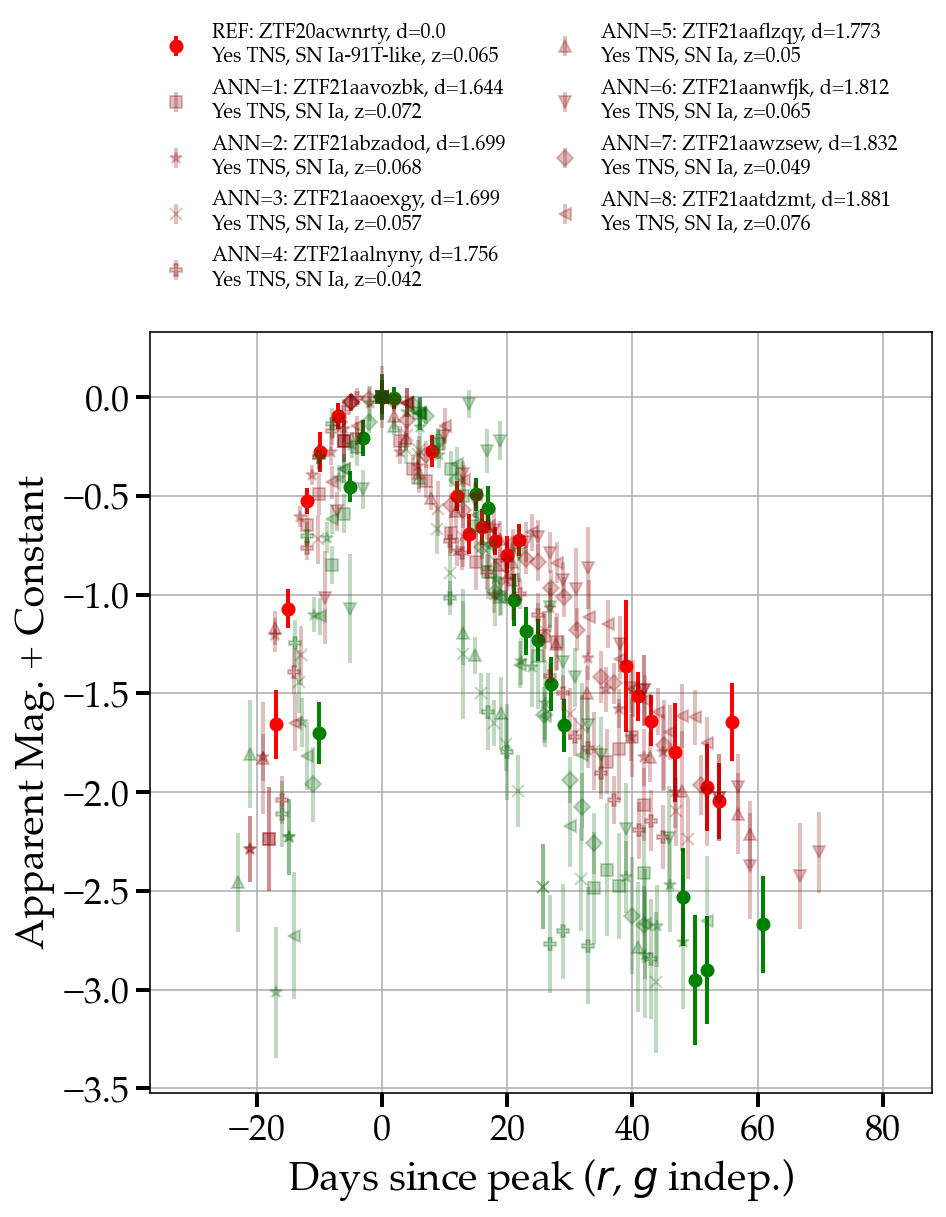

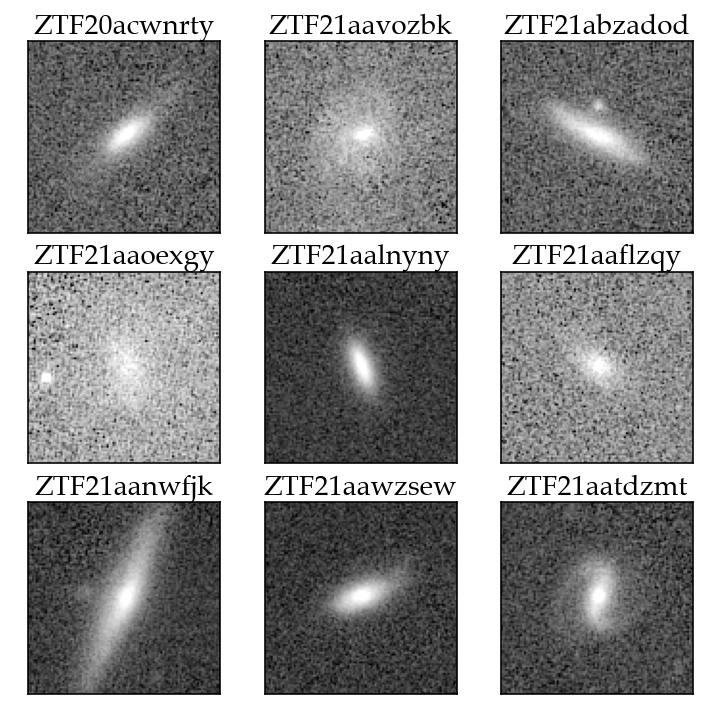

CPU times: user 4.28 s, sys: 155 ms, total: 4.44 s
Wall time: 11.9 s


In [284]:
%%time

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

ztf_id_ref = idx_arr[result_id[0]]
ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

ra_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].raMean
dec_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].decMean
host_df_ztf_id_l.append(ztf_id_ref), host_df_ra_l.append(ra_ref), host_df_dec_l.append(dec_ref)

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
            label=f'REF: {ztf_id_ref}, d={round(result_dist[0], 3)}\n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_ref], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
#ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1]-df_ref_r.ant_mag.min(), s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = result_id[1:9]
ztf_dist_l = result_dist[1:9]

for num, loc in enumerate(ztf_id_l):
    ztf_id_ann = idx_arr[ztf_id_l[num]]

    l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
    try:
        df_knn = l_info.timeseries.to_pandas()
    except: continue    
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z
    
    ra_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].decMean
    host_df_ztf_id_l.append(ztf_id_ann), host_df_ra_l.append(ra_i), host_df_dec_l.append(dec_i)

    df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]
    
    mjd_idx_at_min_mag_r = df_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g = df_g[['ant_mag']].reset_index().idxmin().ant_mag

    ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[mjd_idx_at_min_mag_r], y=df_r.ant_mag.min()-df_r.ant_mag, yerr=df_r.ant_magerr, 
                fmt=markers[num], c='darkred', alpha=0.25, 
                label=f'ANN={num+1}: {ztf_id_ann}, d={round(ztf_dist_l[num], 3)}\n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}')
    ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[mjd_idx_at_min_mag_g], y=df_g.ant_mag.min()-df_g.ant_mag, yerr=df_g.ant_magerr, 
                fmt=markers[num], c='darkgreen', alpha=0.25)
    #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]-df_r.ant_mag.min(), s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

    plt.ylabel('Apparent Mag. + Constant')
    #plt.xlabel('Days of event') # make iloc[0]
    plt.xlabel('Days since peak ($r$, $g$ indep.)') # (need r, g to be same)
    if df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref] <= 10:
        plt.xlim((df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref])-20, 
                 df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    else: 
        plt.xlim(2*(df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref]), 
                 df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    plt.legend(frameon=False,
               bbox_to_anchor=(0.98,1.43),
               ncol=2,
               prop={'size': 10})

    plt.grid(True)
    
plt.savefig(f'../figures/{ztf_id_ref}_cls={tns_cls_ref}_ann={num+1}_manhattan.jpg', dpi=150, bbox_inches='tight')

host_5ann_df = pd.DataFrame(zip(host_df_ztf_id_l, host_df_ra_l, host_df_dec_l), columns=['name', 'ra', 'dec'])

host_pdfs(df=host_5ann_df)

In [285]:
# Common Values
# Value	Count	Frequency (%)
# None	14328	93.7%
# SN Ia	651	 4.3%
# SN II	141	 0.9%
# SN IIn	26	 0.2%
# SN Ia-91T-like	24	 0.2%
# SN Ib	15	 0.1%
# SN Ic	15	 0.1%
# SN IIb	11	 0.1%
# TDE	9	 0.1%
# SN IIP	9	 0.1%
# Other values (18)	65	 0.4%

# TODO: Find ANNs per TNS class dist - do more rare classes scale with higher dist?

In [154]:
dataset_bank

PC0       PC1       PC2       PC3       PC4       PC5  \
ztf_object_id                                                               
ZTF20acpdyyq   0.511818  0.456445  0.298547 -0.435799  0.104584  0.000951   
ZTF18acfvwwa   0.615020  0.562739 -0.037277  0.140402 -0.206723 -0.194519   
ZTF20aciscxz  -0.256754 -0.742976 -0.048415 -0.209558 -0.183202 -0.270683   
ZTF18abdkosj  -0.068852  1.273278 -0.212094 -0.124672  0.803081  0.191683   
ZTF18abrcoty  -0.433417 -0.736429 -0.359087 -0.056552  0.680630  0.456337   
...                 ...       ...       ...       ...       ...       ...   
ZTF18aczcgiz   0.160439  0.696893 -0.630179  0.262557  0.095096 -0.335650   
ZTF19aaweyrl   0.736704  0.112940  0.377076  0.388480 -0.812025 -0.297356   
ZTF18aaxheyx  -1.002336  0.825724 -0.444662  0.004182 -0.254138 -0.051972   
ZTF18aasbhzf   0.096749  0.577655 -0.802850  0.411371  0.172698 -0.133091   
ZTF21aamjuma   0.675743  0.361102 -0.080897  0.069051 -0.342685  0.180418   

                    PC6       PC7       PC8       PC9  ...      PC15  \
ztf_object_id                                          ...             
ZTF20acpdyyq  -0.643036 -0.090835 -0.019184 -0.315459  ... -0.180184   
ZTF18acfvwwa  -0.382700 -0.137558 -0.102758 -0.272989  ...  0.291221   
ZTF20aciscxz   0.139764 -0.293568  0.041977  0.349665  ...  0.097763   
ZTF18abdkosj   0.396531  0.623919 -0.121100  0.348197  ...  0.118027   
ZTF18abrcoty   0.140240 -0.238542  0.551843 -0.095553  ... -0.221657   
...                 ...       ...       ...       ...  ...       ...   
ZTF18aczcgiz   0.214551  0.005752 -0.227721 -0.230319  ...  0.323277   
ZTF19aaweyrl   0.072653  0.184875  0.453962  0.274548  ... -0.017978   
ZTF18aaxheyx  -0.145289  0.100675  0.132994  0.149232  ... -0.225911   
ZTF18aasbhzf   0.339193  0.013837  0.003372 -0.270719  ... -0.088160   
ZTF21aamjuma  -0.167939 -0.206442 -0.150531 -0.196581  ... -0.016441   

                   PC16      PC17      PC18      PC19      PC20      PC21  \
ztf_object_id                                                               
ZTF20acpdyyq   0.023385  0.069557 -0.052138  0.160847 -0.054357 -0.041780   
ZTF18acfvwwa   0.058330  0.068592 -0.072299  0.121445 -0.007637 -0.022361   
ZTF20aciscxz   0.028772  0.048494 -0.031333  0.238530 -0.231106 -0.047648   
ZTF18abdkosj  -0.336105 -0.010173 -0.007460  0.213724 -0.092866 -0.063358   
ZTF18abrcoty  -0.180031 -0.254139  0.014310  0.159587 -0.262389 -0.019723   
...                 ...       ...       ...       ...       ...       ...   
ZTF18aczcgiz   0.149889 -0.101420 -0.050562 -0.056362 -0.310081  0.045390   
ZTF19aaweyrl   0.006561  0.112655  0.120642  0.032068 -0.018965  0.001691   
ZTF18aaxheyx  -0.062102  0.287722 -0.089547 -0.144347  0.075917  0.132270   
ZTF18aasbhzf   0.190466  0.076688 -0.043454  0.319231  0.058287 -0.037774   
ZTF21aamjuma   0.059932  0.201102 -0.093745  0.035758 -0.011007 -0.154335   

                   PC22      PC23      PC24  
ztf_object_id                                
ZTF20acpdyyq  -0.117817  0.102755 -0.004341  
ZTF18acfvwwa   0.054615  0.235653  0.008599  
ZTF20aciscxz   0.158622 -0.055614 -0.044338  
ZTF18abdkosj   0.062848  0.105487 -0.102110  
ZTF18abrcoty   0.058113  0.337689  0.122494  
...                 ...       ...       ...  
ZTF18aczcgiz   0.053976 -0.089954  0.035542  
ZTF19aaweyrl   0.084531  0.067526  0.328871  
ZTF18aaxheyx  -0.088534  0.173032 -0.065017  
ZTF18aasbhzf   0.032374 -0.153508 -0.047006  
ZTF21aamjuma  -0.119678 -0.075472 -0.076732  

[18998 rows x 25 columns]

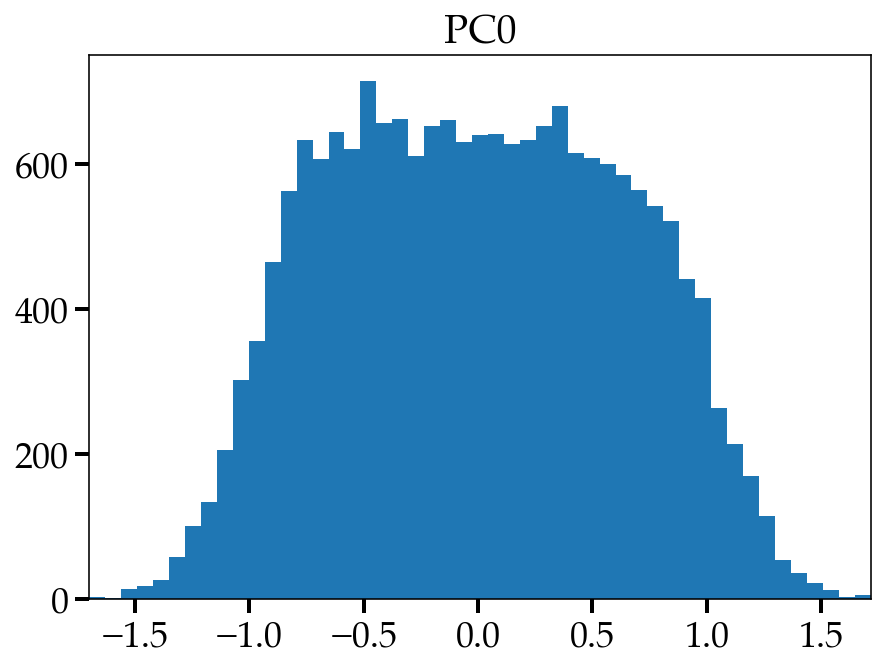

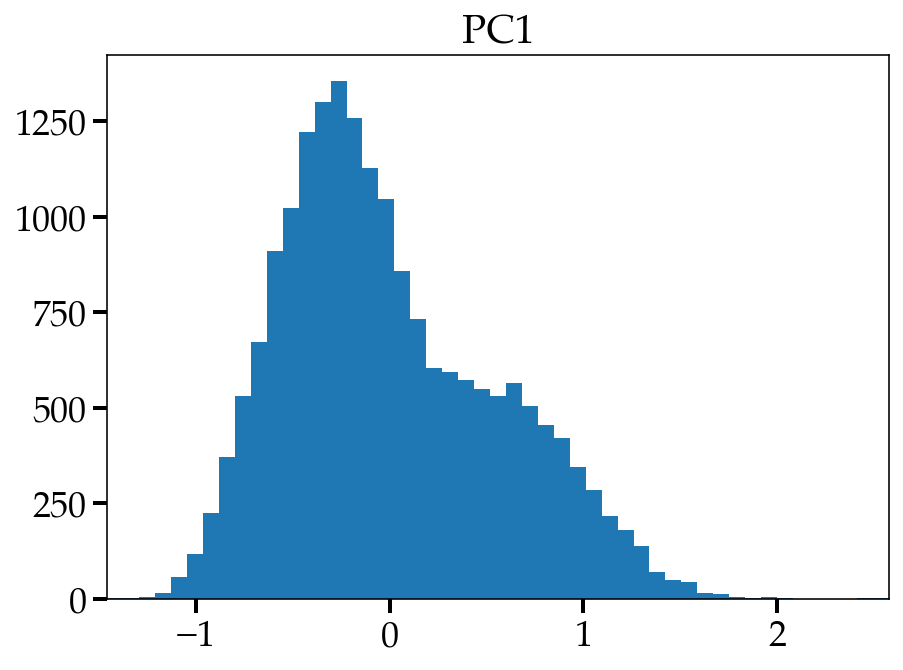

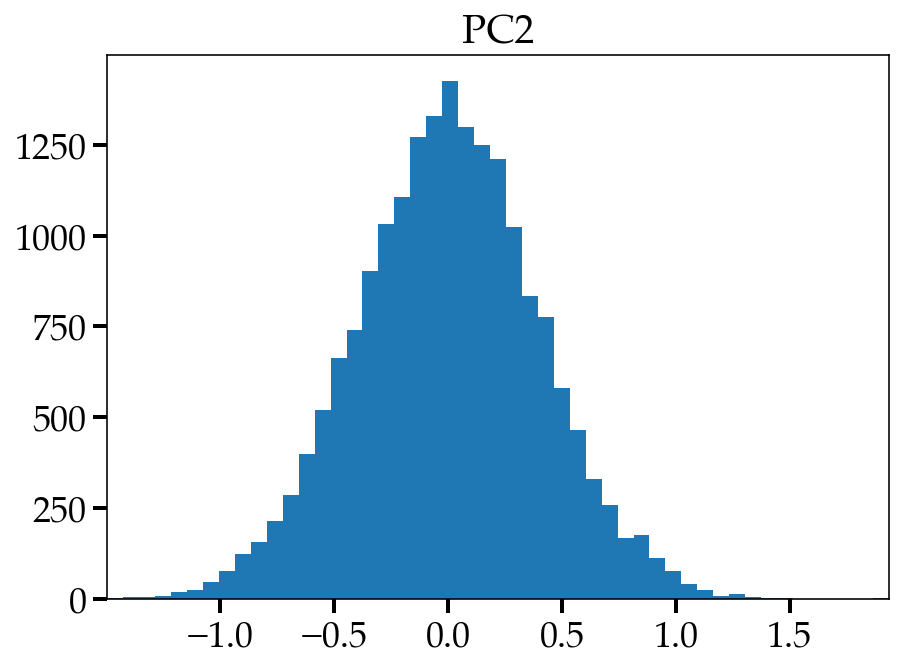

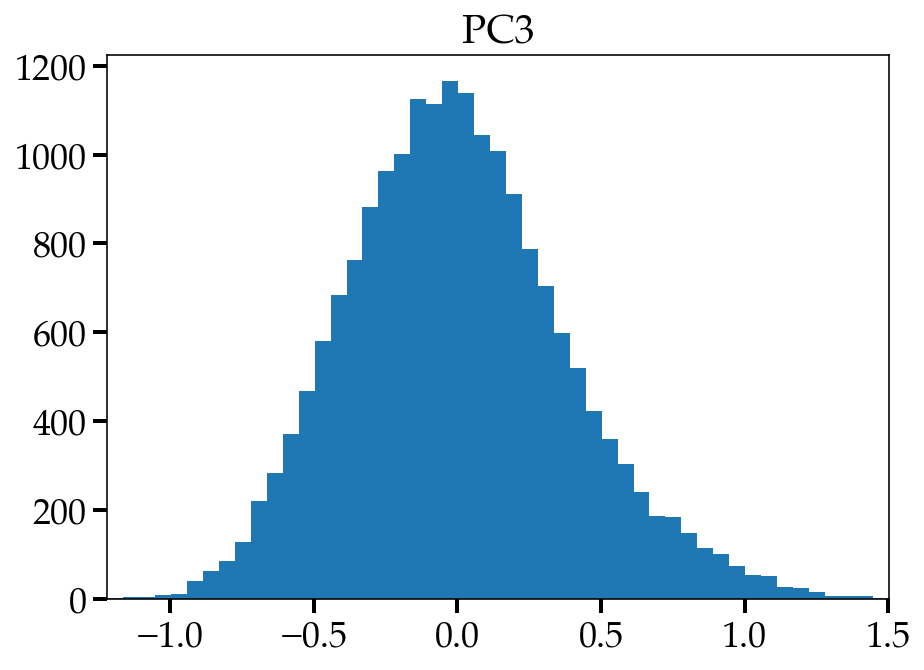

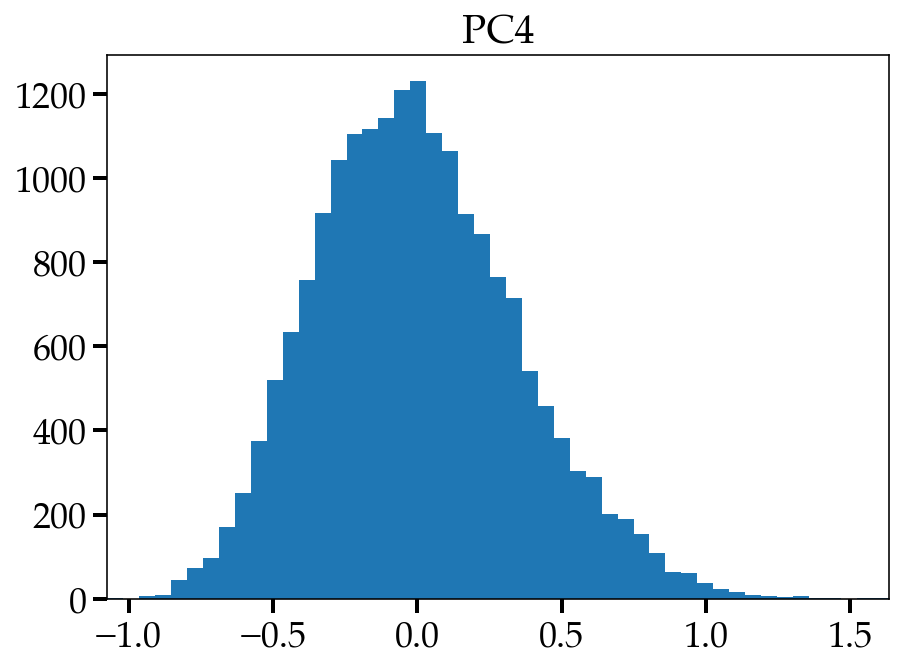

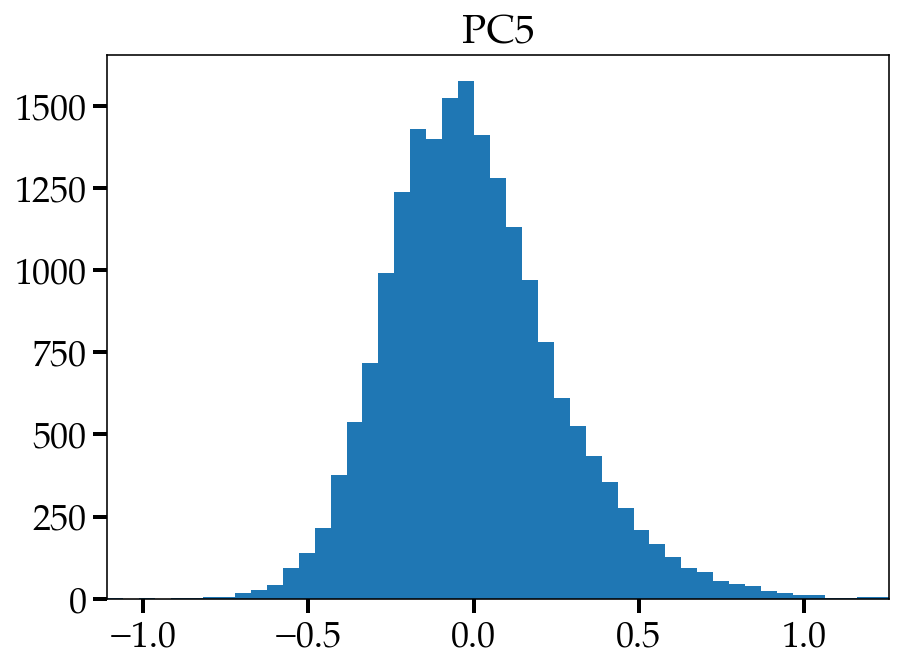

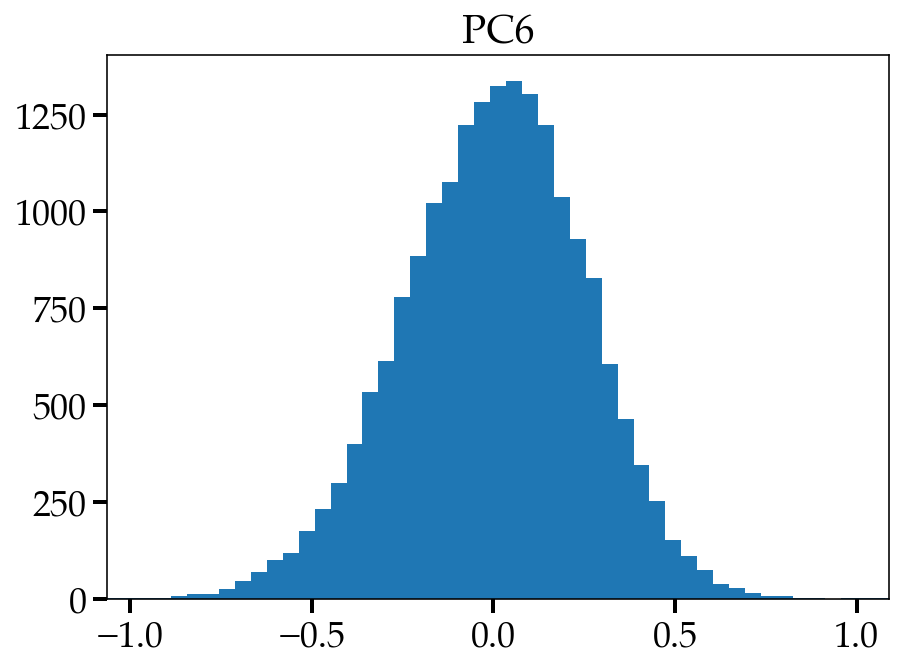

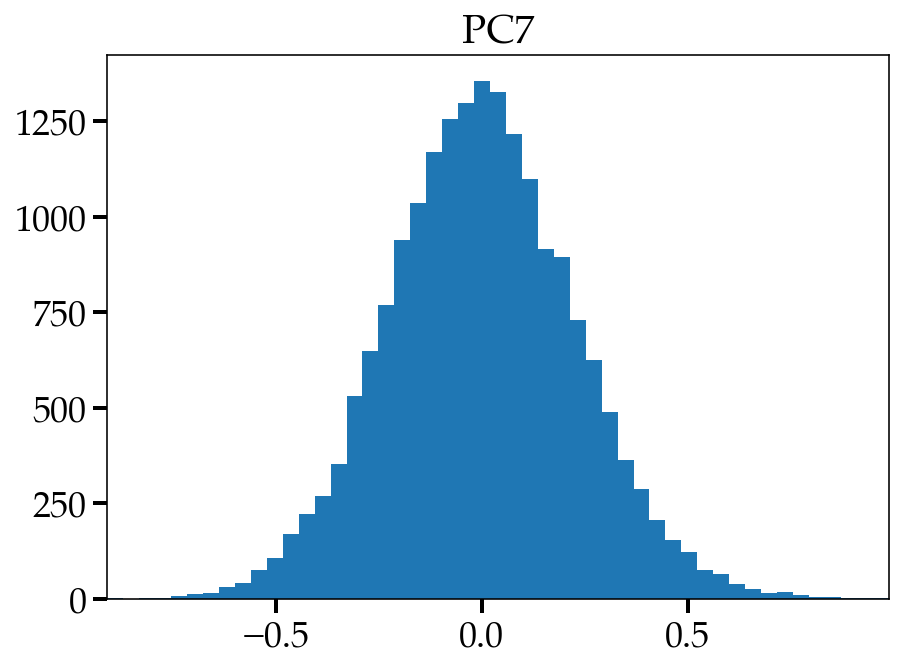

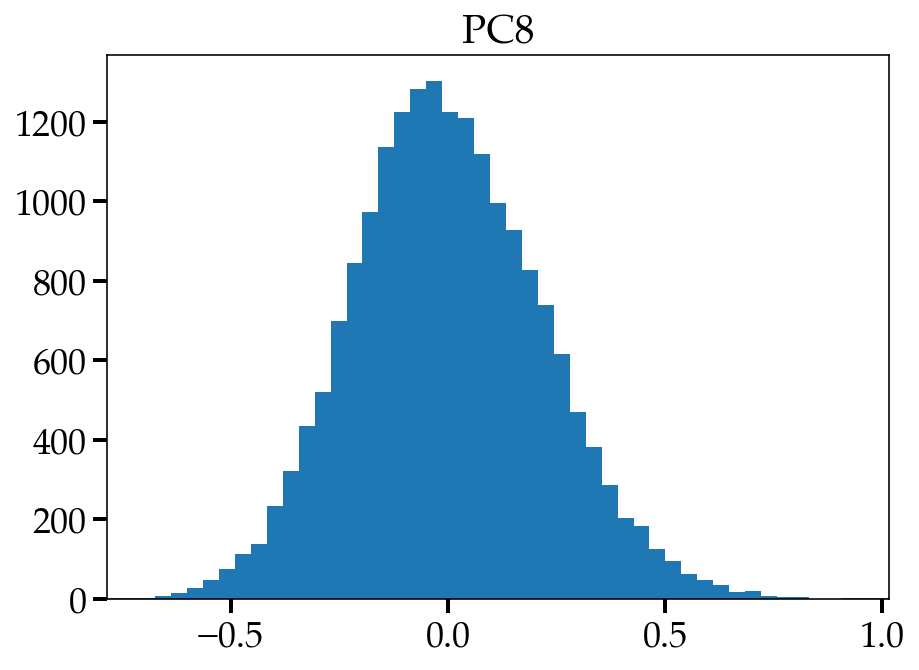

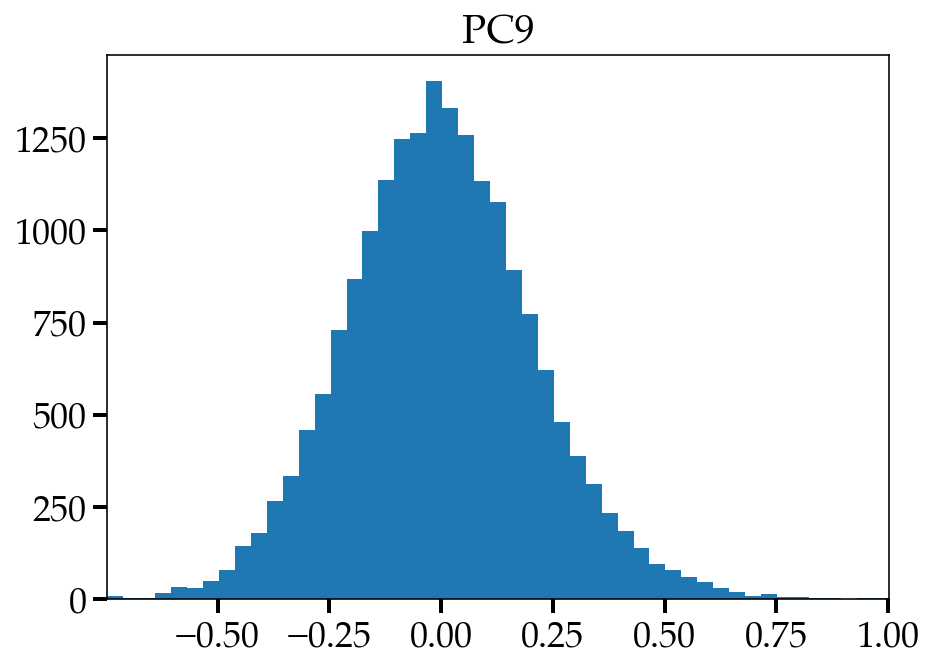

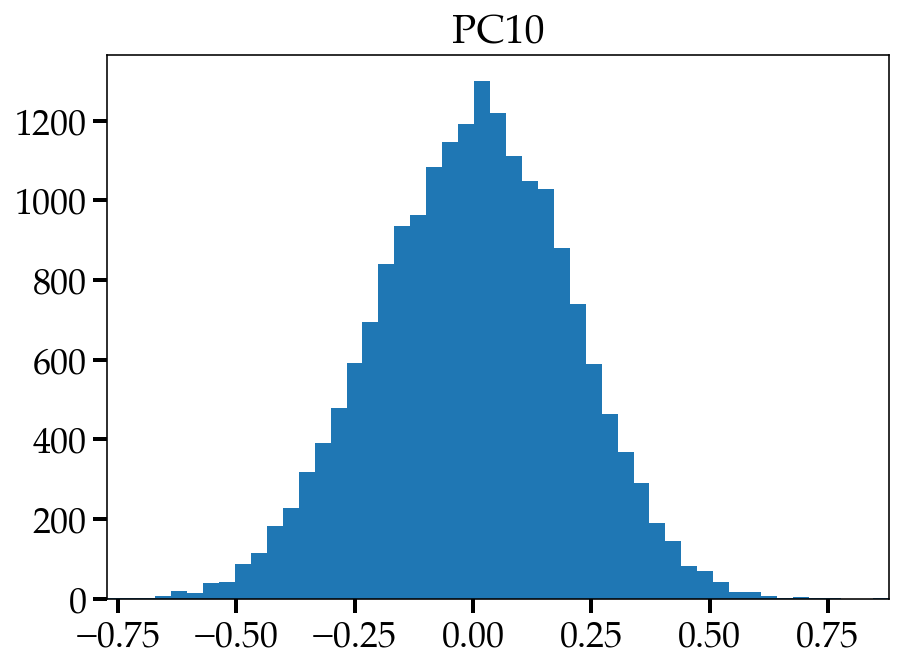

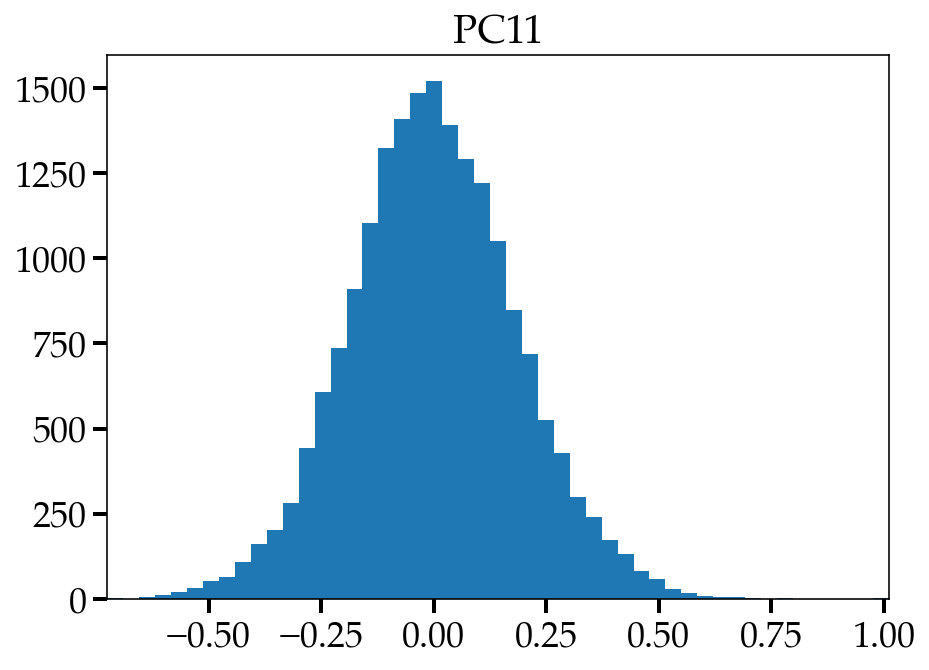

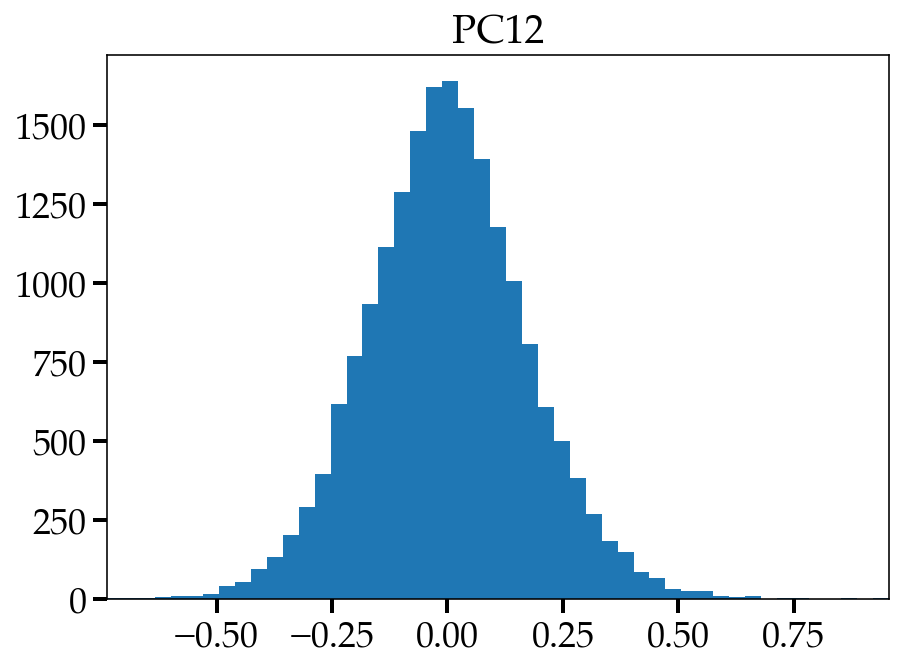

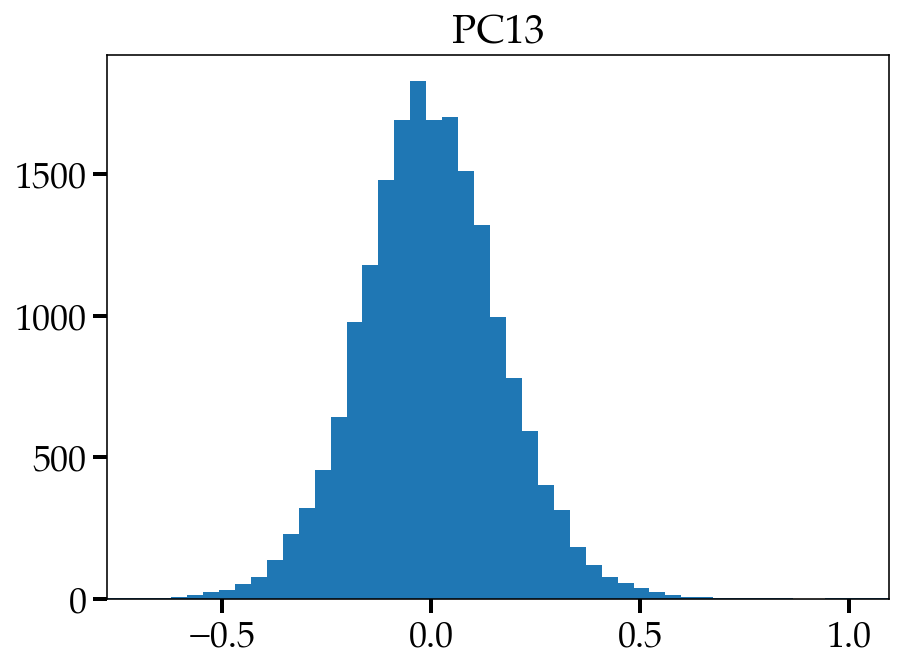

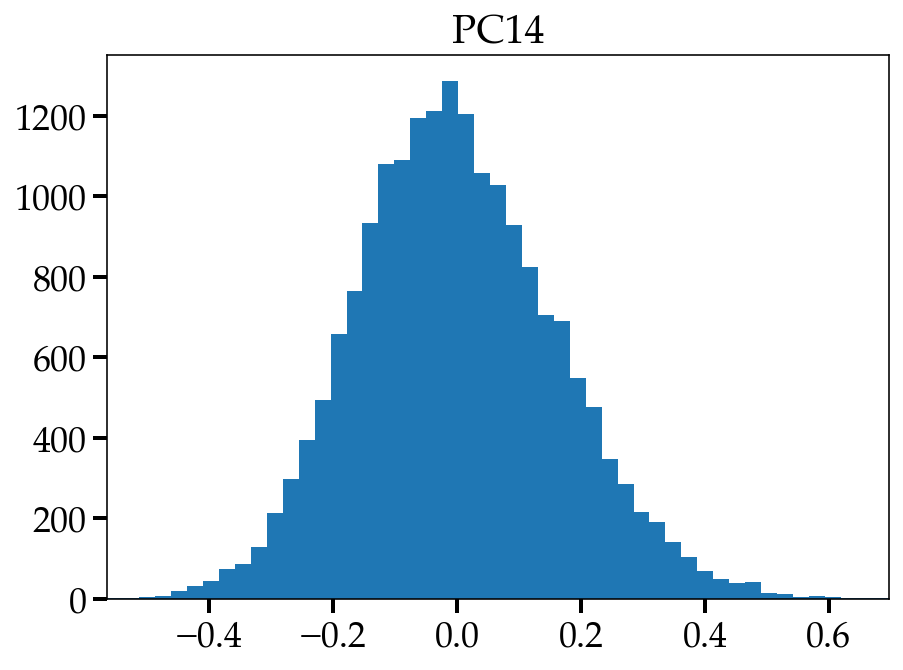

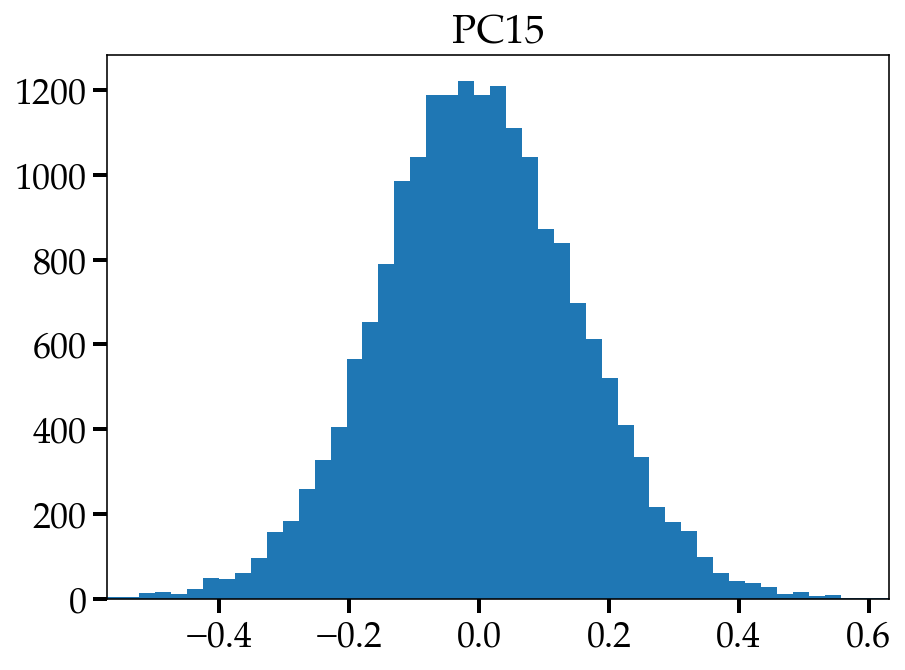

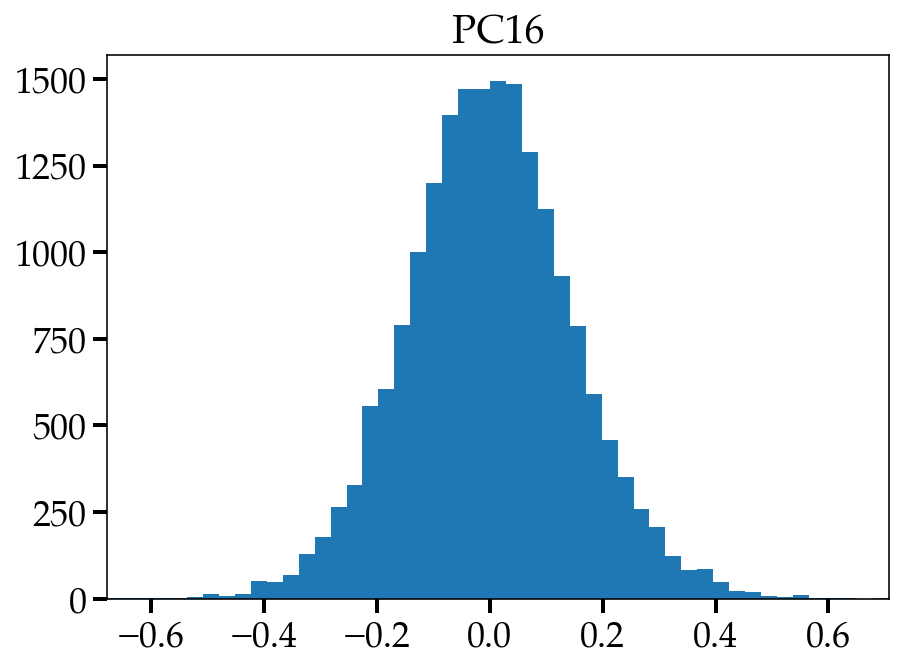

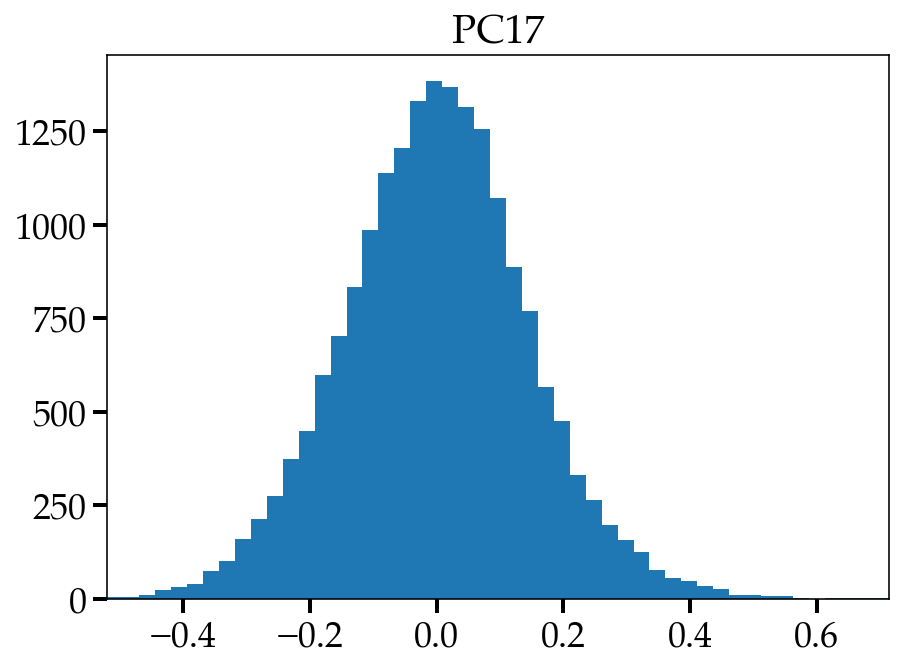

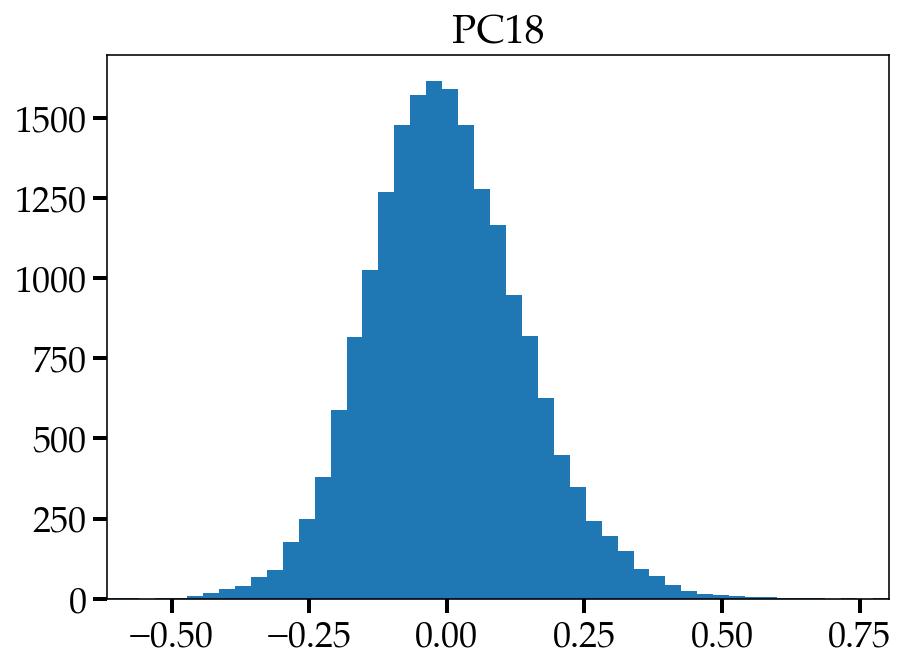

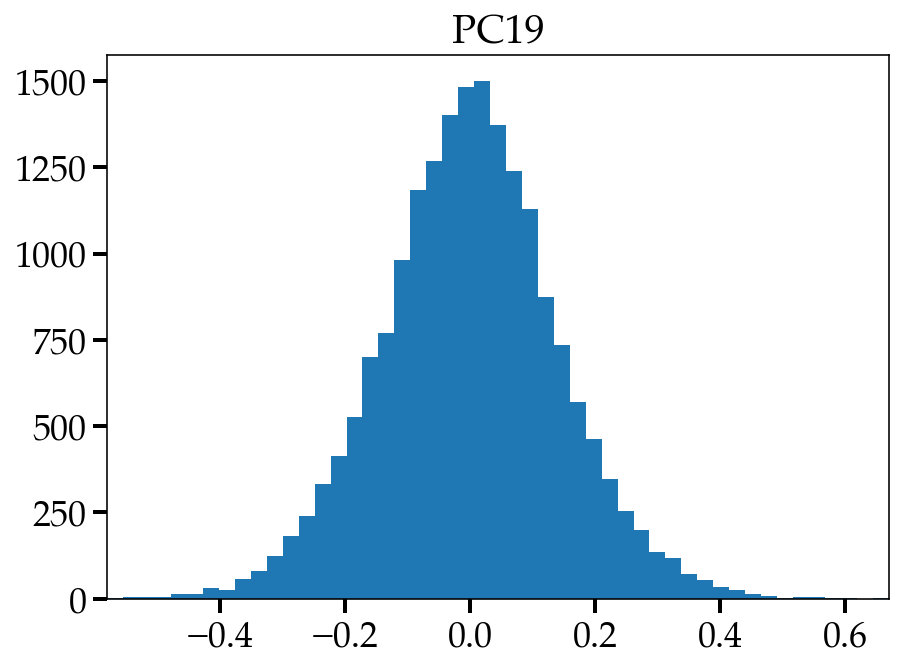

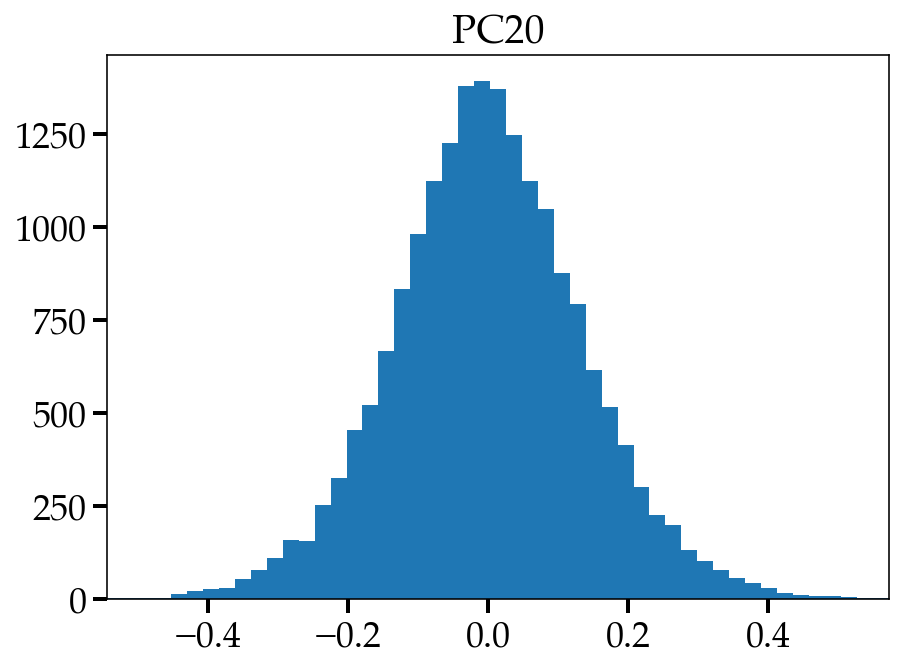

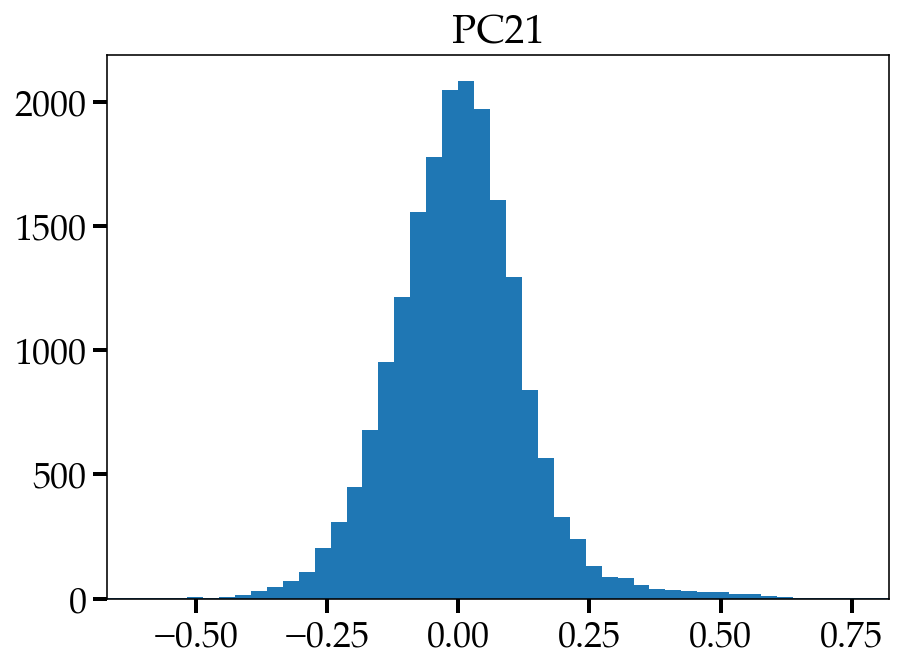

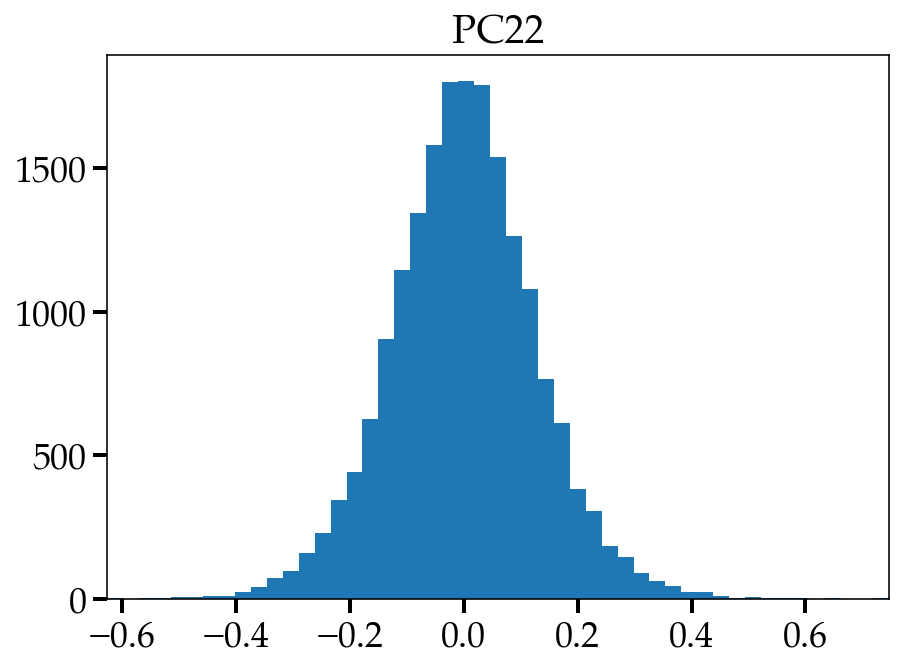

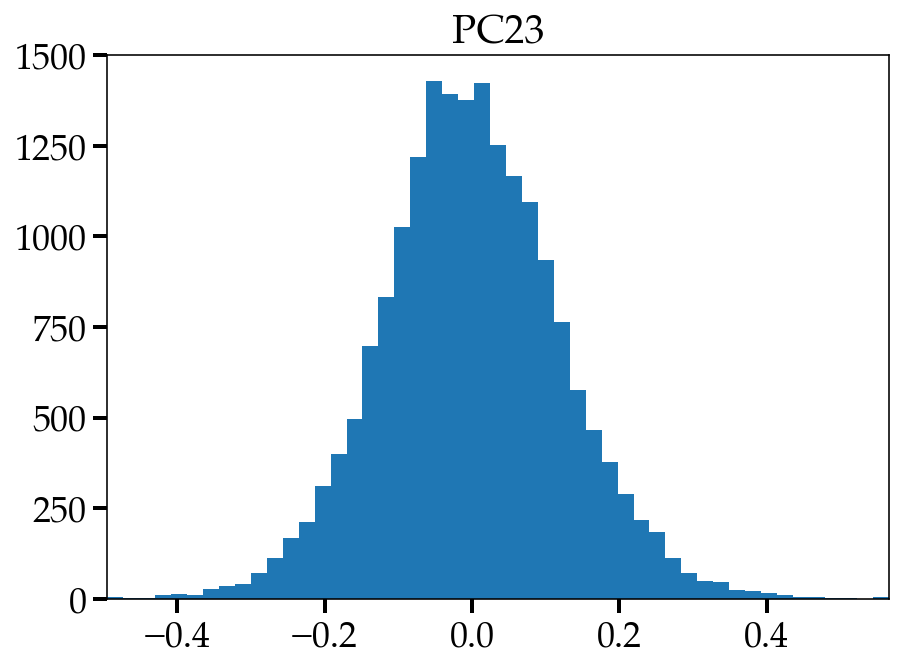

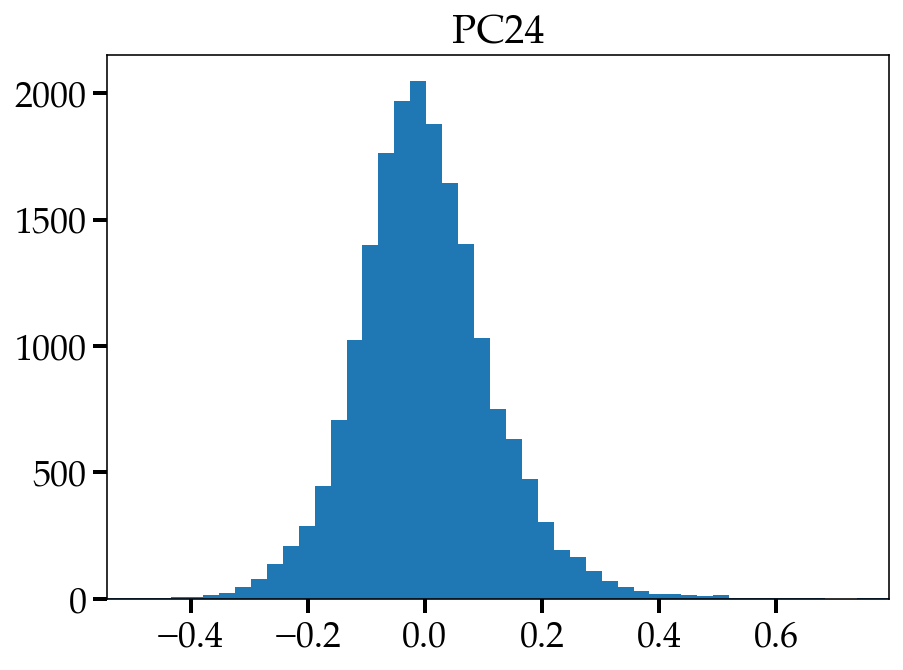

In [155]:
feat_scatter_l = []
for feat in dataset_bank.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(dataset_bank[feat], bins=np.linspace(min_feat, max_feat, 50))
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.show()
    
    feat_scatter = np.std(dataset_bank[feat])
    feat_scatter_l.append(feat_scatter)    

In [156]:
print("Scatter mean:", np.mean(feat_scatter_l))
print("Scatter median:", np.median(feat_scatter_l))
print("Scatter std:", np.std(feat_scatter_l))
print("Scatter max:", np.max(feat_scatter_l))
print("Scatter min:", np.min(feat_scatter_l))

Scatter mean: 0.23011519526228252
Scatter median: 0.1729904310452818
Scatter std: 0.13275505832383852
Scatter max: 0.6334613882807529
Scatter min: 0.11675496047686841


In [157]:
%%time

ref_name_l, id_l, dist_l = [], [], []
for ref in list(np.unique(dataset_bank.index)):
    dataset_ref = dataset_bank[dataset_bank.index == ref] 

    feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
    scaled_feat_arr_ref = feat_arr_ref # PCA, so already scaled

    snid = dataset_ref.index.values[0]
    lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
    #lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

    #result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
    result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
    
    ref_name_l.append(snid), id_l.append(result_id), dist_l.append(result_dist)
    
temp_df = pd.DataFrame(zip(ref_name_l, id_l, dist_l), columns=['Reference', 'ids', 'dists'])
temp_df = temp_df.set_index('Reference')
ann_split_df = temp_df.merge(pd.DataFrame(temp_df['ids'].values.tolist()).add_prefix('ann='), on=temp_df.index)
ann_split_df = ann_split_df.set_index('key_0')
ann_dist_all_df = ann_split_df.merge(pd.DataFrame(ann_split_df['dists'].values.tolist()).add_prefix('dist='), on=ann_split_df.index)
ann_dist_all_df = ann_dist_all_df.drop(columns=['ids', 'dists'])
ann_dist_all_df = ann_dist_all_df.set_index('key_0')

# find average (mean) distance of first 9 ANNs.
col_list= [f'dist={col}' for col in range(1, 10)]
# sum specific columns
ann_dist_all_df[f'Mean-{len(col_list)}ANNs'] = (ann_dist_all_df[col_list].sum(axis=1))/(len(col_list))

# weighted distance of first 9 ANNs
weight_l = [34, 21, 13, 8, 5, 3, 2, 1, 1] # Fibonacci seq.
ann_dist_all_df[f'WeightedMean-{len(col_list)}ANNs'] = np.average(ann_dist_all_df[col_list], weights=weight_l, axis=1)
ann_dist_all_df

CPU times: user 38.6 s, sys: 323 ms, total: 38.9 s
Wall time: 39.3 s


ann=0  ann=1  ann=2  ann=3  ann=4  ann=5  ann=6  ann=7  ann=8  \
key_0                                                                         
ZTF17aaaaenu  18790   6649  13209  14428   8815   8988   7697  11811   6230   
ZTF17aaaazhi  16293  11694    900   7680   5764   6680  16822  11784   1242   
ZTF17aaaazmz   9278  18392  10854   4196  13821   5253  13787  11383  10115   
ZTF17aaabghb   7729   8345  10679   2012  11735  16892   7521  18175  13702   
ZTF17aaabuab  13760  16799  12701  16398   6645   2745   5941   2455   6825   
...             ...    ...    ...    ...    ...    ...    ...    ...    ...   
ZTF21acogvaq   8545   4406   3097   5763   6583  13656   2777  10814   4807   
ZTF21acowflo   7527   7924  11086   9290   8220    347   9505   4445   1844   
ZTF21acqdfea   7777   1489   9363   8136   5053   8363   1731   9119  13863   
ZTF21acqnurt   8040   5704   3780   9349   8575  11187   4052   9634  17085   
ZTF21acqtdnd  14318   7559   5555  13649   5262  13245   3350  12555   8468   

              ann=9  ...    dist=2    dist=3    dist=4    dist=5    dist=6  \
key_0                ...                                                     
ZTF17aaaaenu  12358  ...  2.601308  2.647424  2.727868  2.747110  2.771687   
ZTF17aaaazhi    241  ...  2.913928  3.074223  3.087019  3.156081  3.361781   
ZTF17aaaazmz    400  ...  2.399581  2.542626  2.926282  2.986156  3.031959   
ZTF17aaabghb  10797  ...  2.173353  2.350522  2.395709  2.501954  2.571884   
ZTF17aaabuab   5730  ...  2.751327  2.909887  2.934905  3.039580  3.100569   
...             ...  ...       ...       ...       ...       ...       ...   
ZTF21acogvaq   1928  ...  2.681405  2.807652  2.823394  2.867223  2.982801   
ZTF21acowflo   9522  ...  2.805350  2.855224  2.934785  2.934894  3.017590   
ZTF21acqdfea   2915  ...  2.294348  2.302846  2.313089  2.421674  2.438983   
ZTF21acqnurt   2586  ...  3.417747  3.441457  3.462854  3.551971  3.588788   
ZTF21acqtdnd  10613  ...  3.623932  3.634476  3.773808  3.834483  3.918809   

                dist=7    dist=8    dist=9  Mean-9ANNs  WeightedMean-9ANNs  
key_0                                                                       
ZTF17aaaaenu  2.970411  2.972721  2.976331    2.746712            2.536319  
ZTF17aaaazhi  3.367687  3.408665  3.429598    3.174018            2.947467  
ZTF17aaaazmz  3.066046  3.088347  3.099874    2.816637            2.480726  
ZTF17aaabghb  2.593932  2.629716  2.634124    2.446292            2.268916  
ZTF17aaabuab  3.149559  3.169443  3.223724    2.989983            2.792348  
...                ...       ...       ...         ...                 ...  
ZTF21acogvaq  2.991531  3.017424  3.065472    2.856268            2.667161  
ZTF21acowflo  3.025151  3.170483  3.203540    2.951771            2.780722  
ZTF21acqdfea  2.476552  2.497445  2.514253    2.385581            2.286233  
ZTF21acqnurt  3.692314  3.767519  3.807232    3.554279            3.391971  
ZTF21acqtdnd  3.970216  4.007190  4.081807    3.779589            3.503785  

[18998 rows x 22 columns]

In [158]:
# Pick distance metric. 
# Weighted mean of first 9 ANNs (Fibonacci), OR Mean of first 9 ANNs, OR distance to first ANN. 
# TODO: EXPLORE DIFFERENT METRICS!
dist_col = f'WeightedMean-{len(col_list)}ANNs'  # f'Mean_{len(col_list)}ANNs' # 'dist=1'

print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df[dist_col]))
print("Scatter median:", np.median(ann_dist_all_df[dist_col]))
print("Scatter std:", np.std(ann_dist_all_df[dist_col]))
print("Scatter max:", np.max(ann_dist_all_df[dist_col]))
print("Scatter min:", np.min(ann_dist_all_df[dist_col]))
print("\n")

#Returns index of mean distance of 9 ANNs
print("Most anomalous:", ann_dist_all_df[[dist_col]].idxmax().values[0])

summary stats
Scatter mean: 2.6022078898311034
Scatter median: 2.584319216283885
Scatter std: 0.4976490188857527
Scatter max: 6.41065249117938
Scatter min: 1.2724317203868518


Most anomalous: ZTF19aaeyltm


# Largest distance


### either bogus (bright "obs" at core which aren't real)
### intense variable star
### bright/ nearby SN
### big gaps
### quick rise and then no obs until much later
### some truly weird ones (20acct)

In [159]:
ref_obj = ann_dist_all_df[[dist_col]].idxmax().values[0] #'ZTF18acbwaxk'
print("Max dist", ann_dist_all_df.loc[ref_obj][dist_col]) 

Max dist 6.41065249117938


In [160]:
dataset_bank[dataset_bank.index == ref_obj]

PC0       PC1       PC2       PC3       PC4      PC5  \
ztf_object_id                                                              
ZTF19aaeyltm  -0.525946  1.348017  0.833197 -0.339184  0.961582  0.44052   

                    PC6       PC7       PC8       PC9  ...      PC15     PC16  \
ztf_object_id                                          ...                      
ZTF19aaeyltm   0.443038 -0.101535  0.008829  0.329208  ...  0.086548  0.01716   

                  PC17      PC18     PC19      PC20      PC21      PC22  \
ztf_object_id                                                             
ZTF19aaeyltm   0.71335  0.067017  0.41923  0.000004  0.622191  0.426662   

                   PC23      PC24  
ztf_object_id                      
ZTF19aaeyltm  -0.086757 -0.151293  

[1 rows x 25 columns]

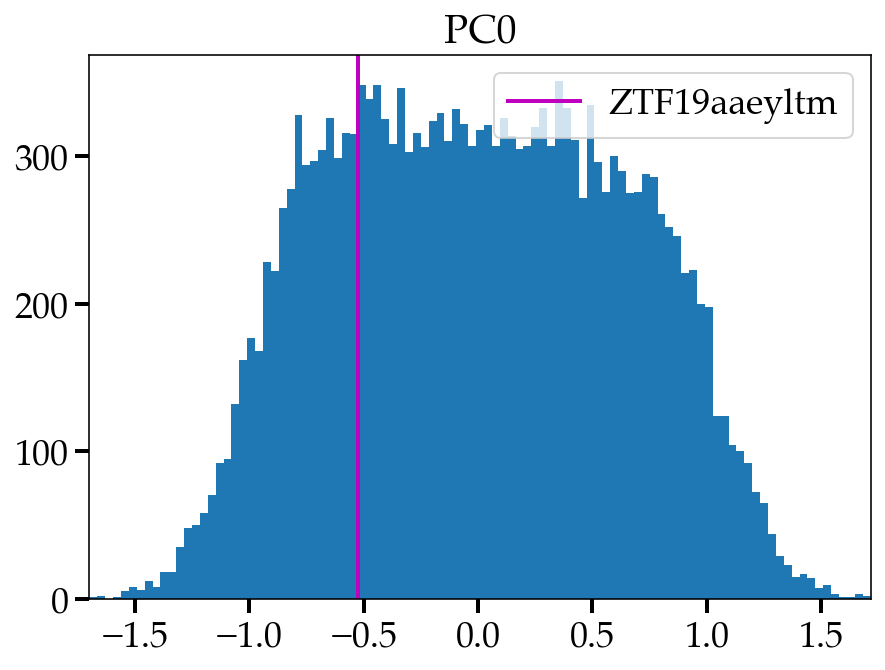

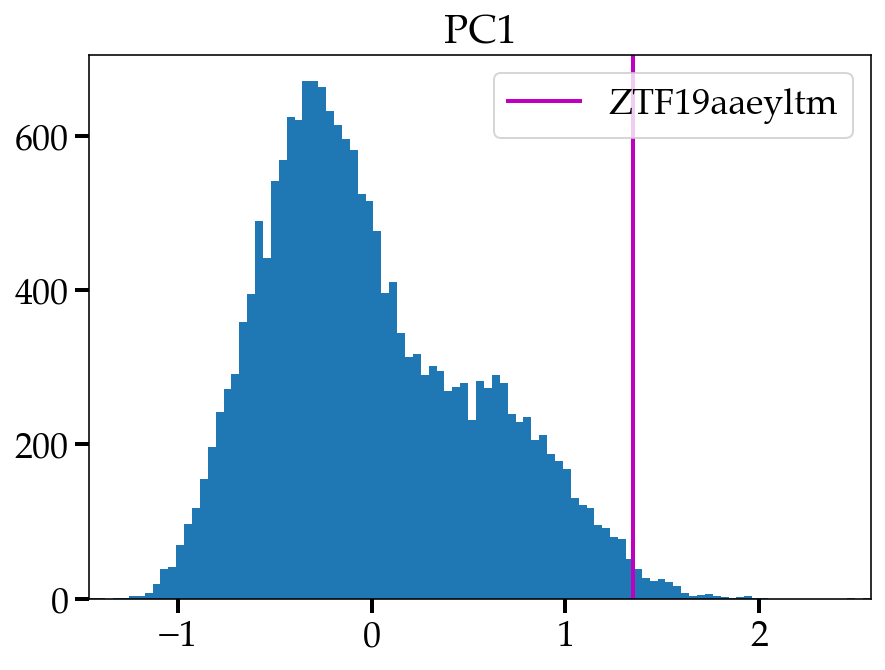

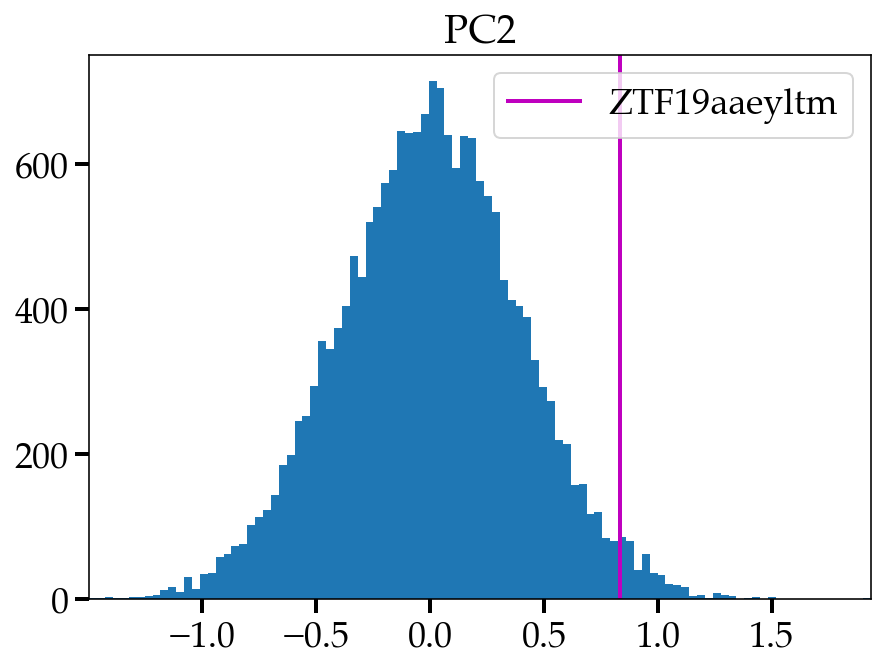

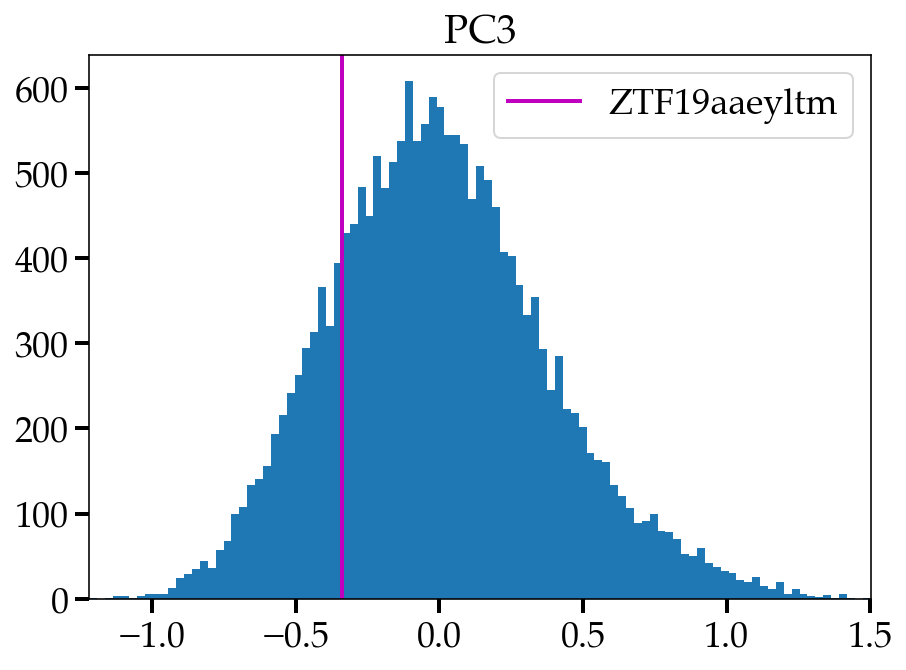

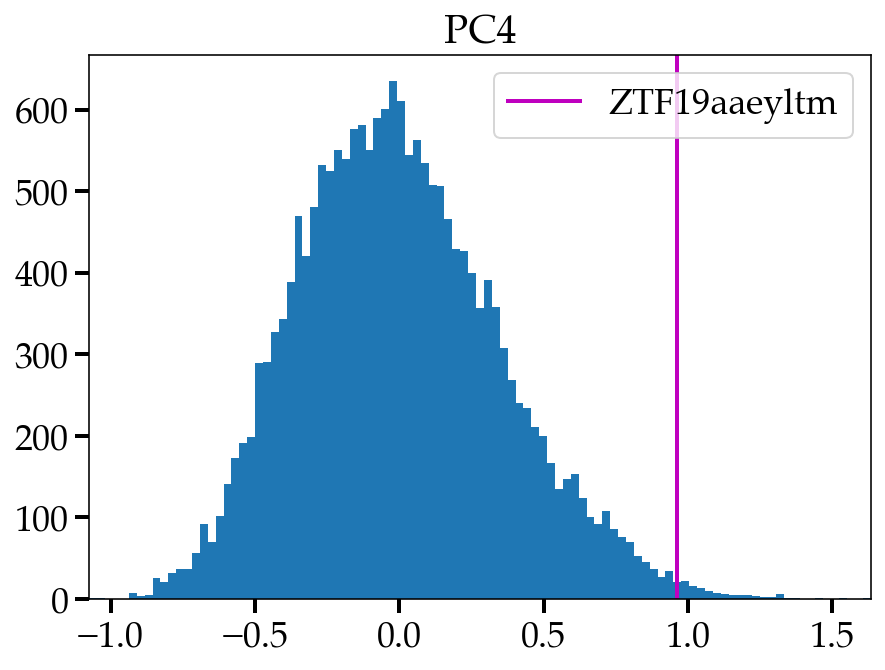

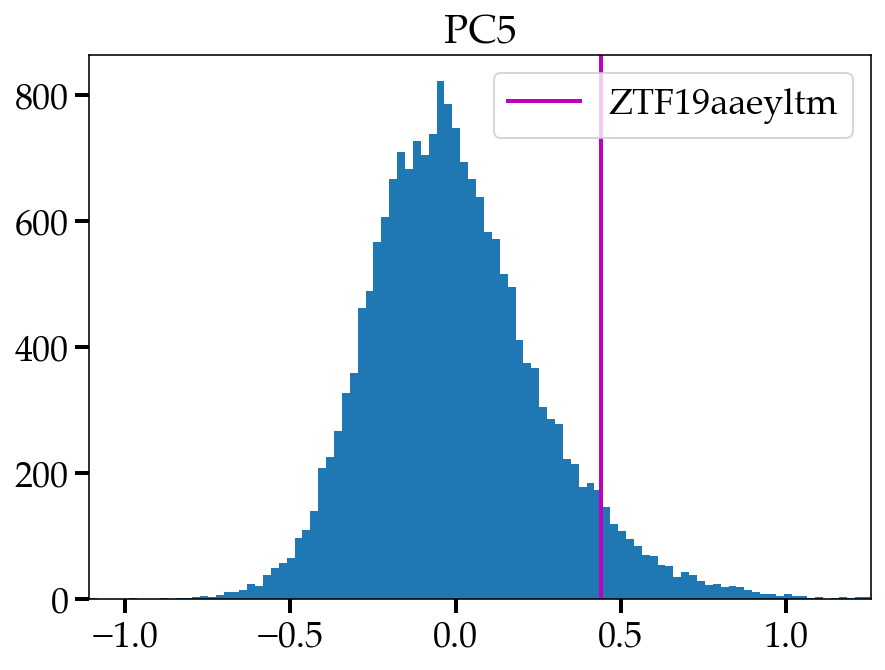

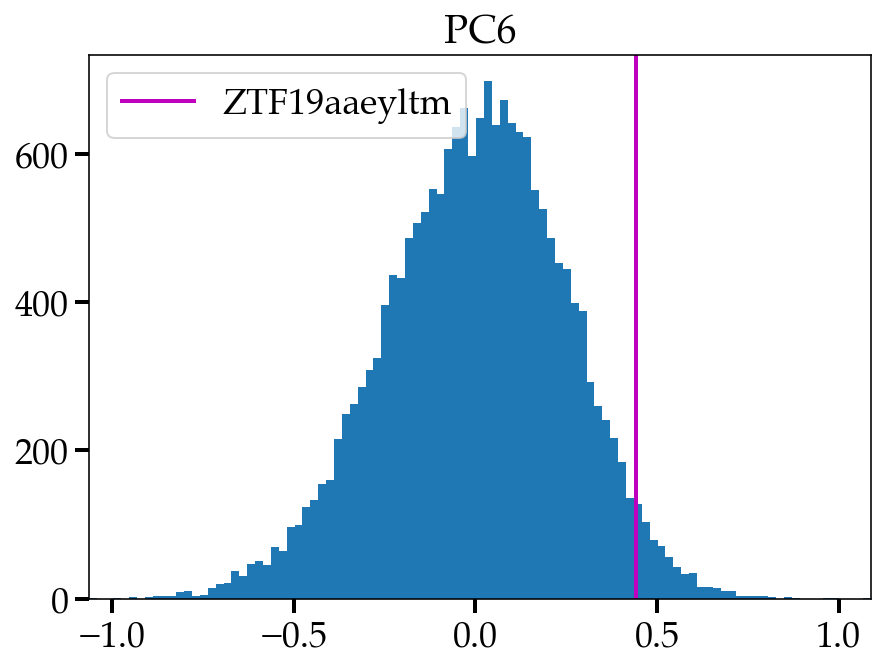

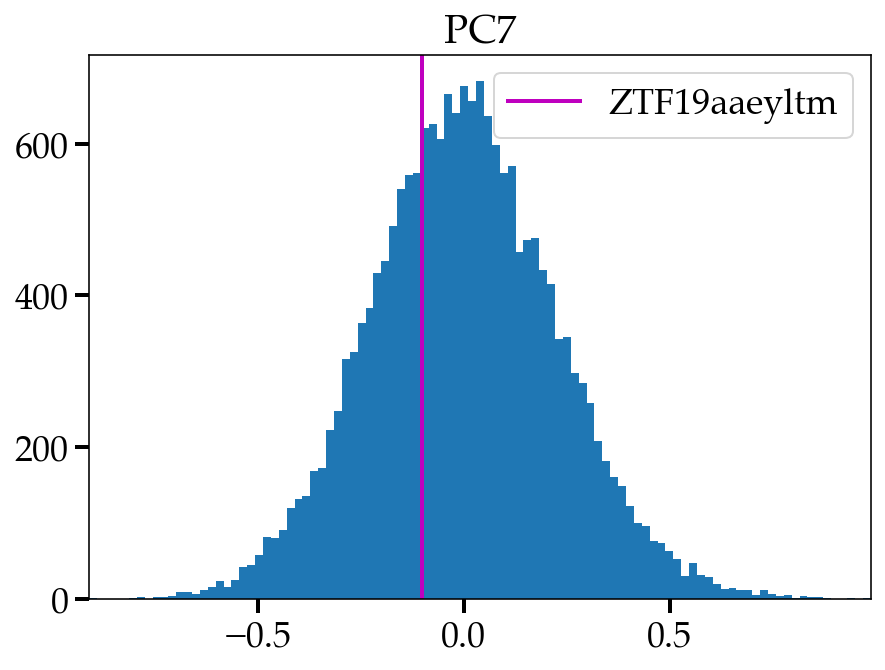

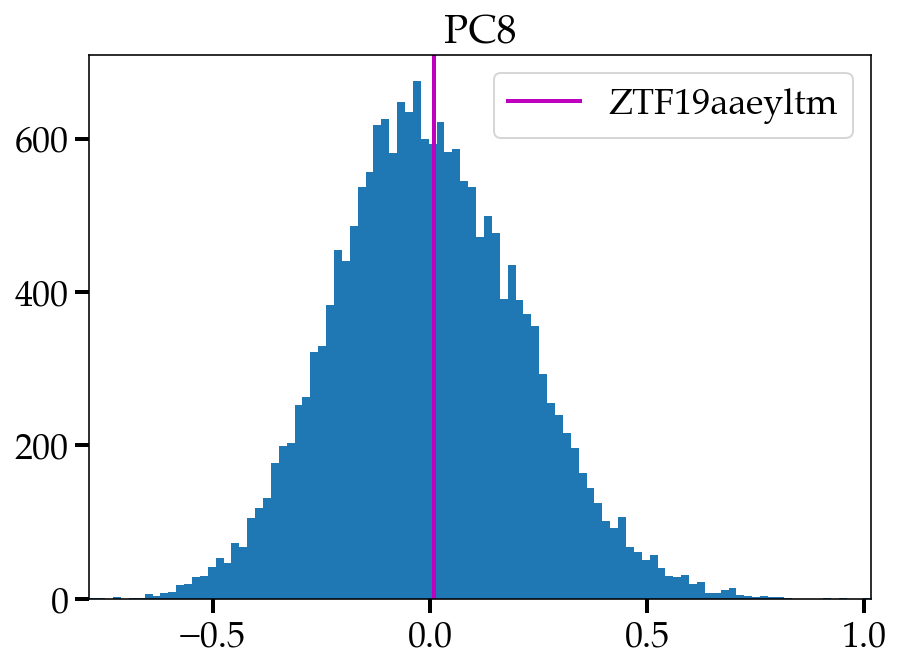

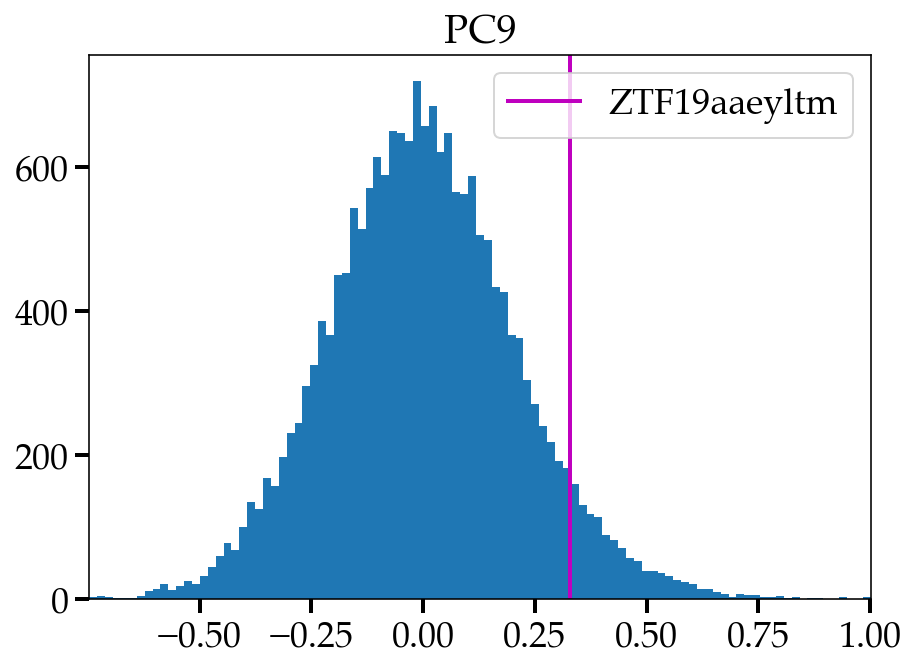

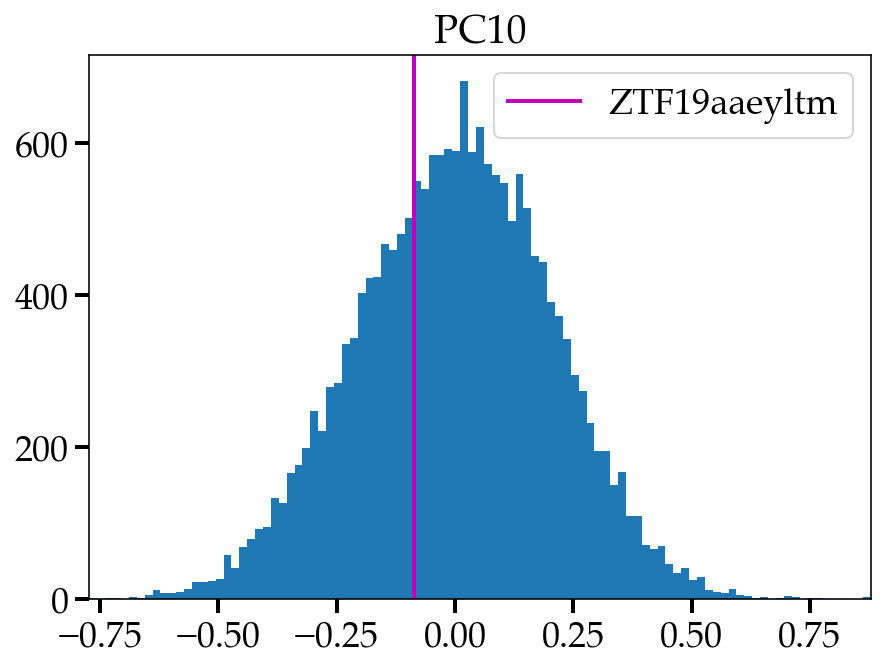

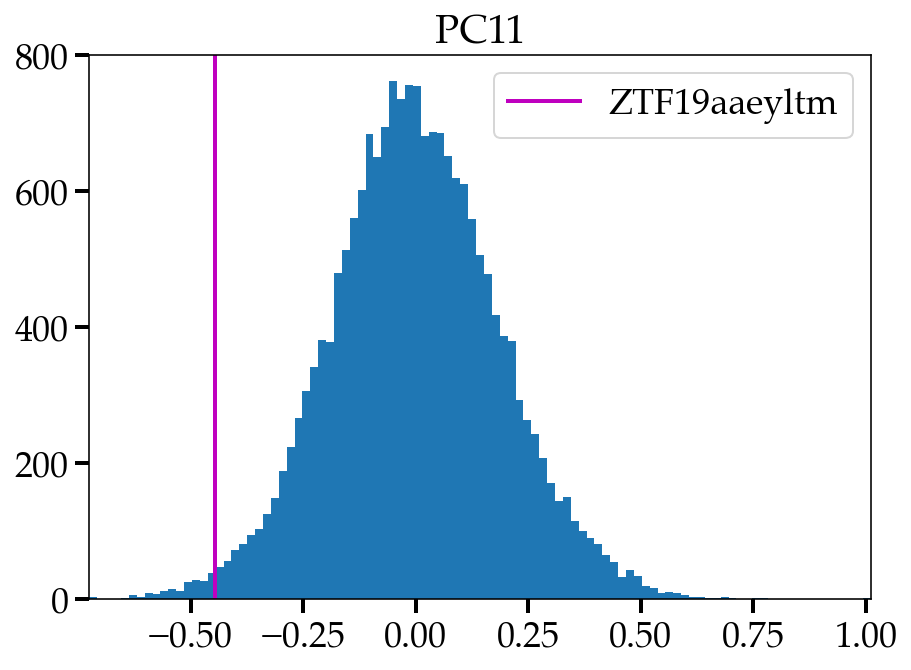

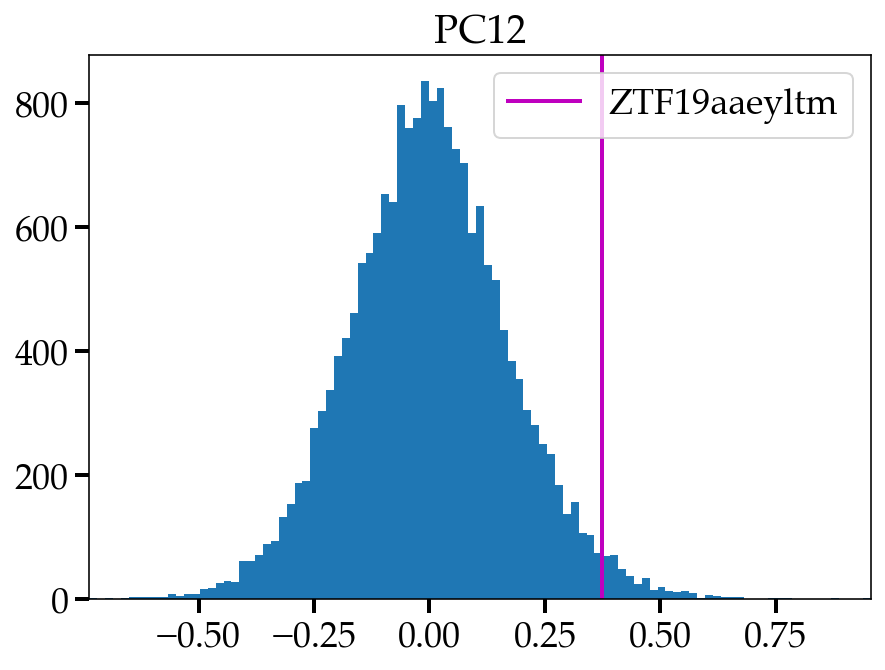

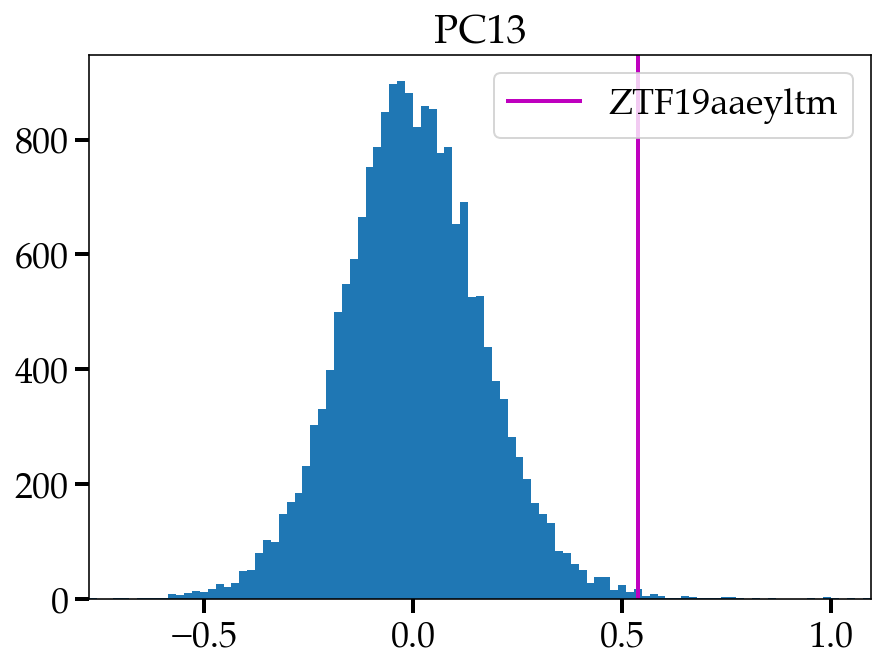

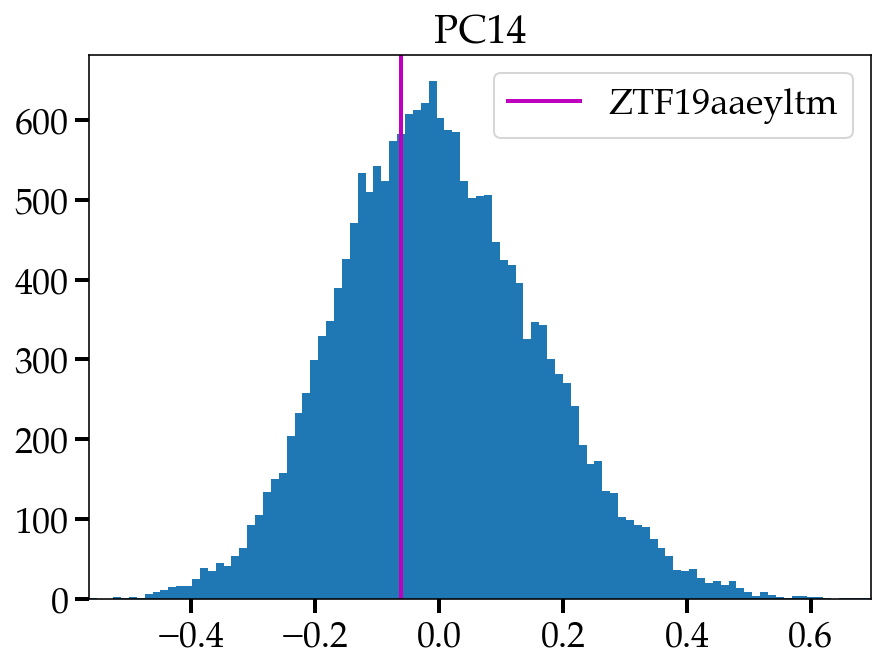

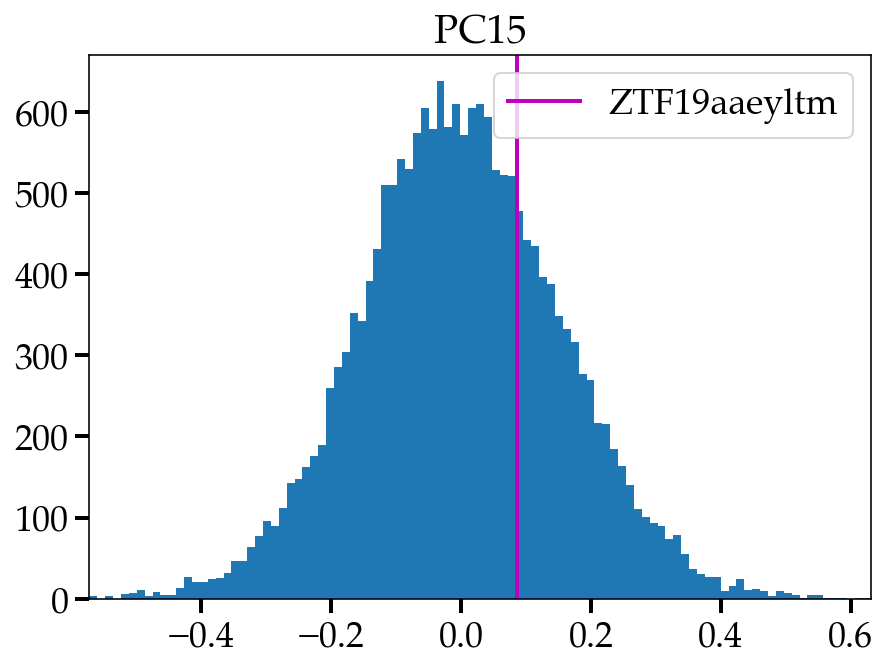

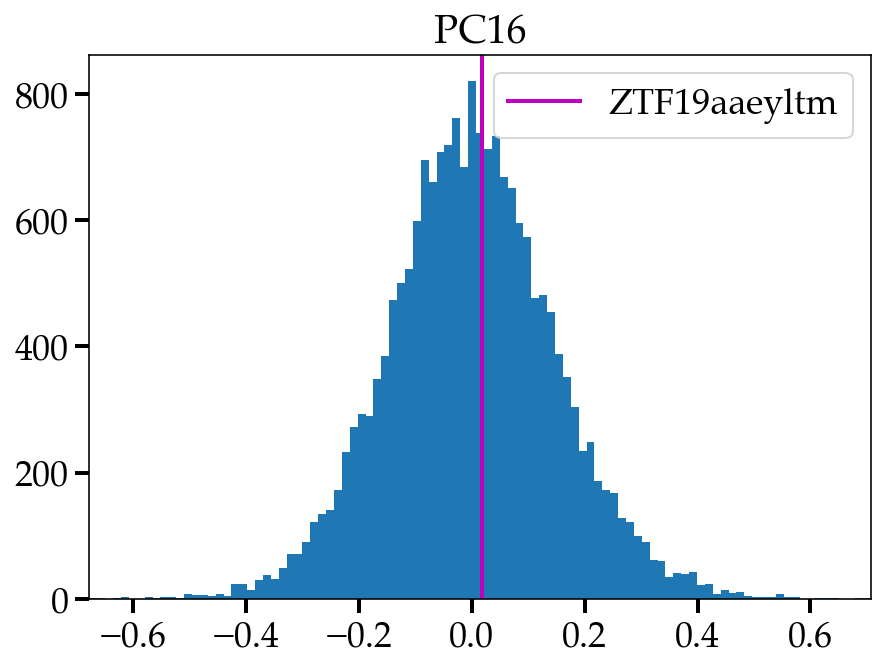

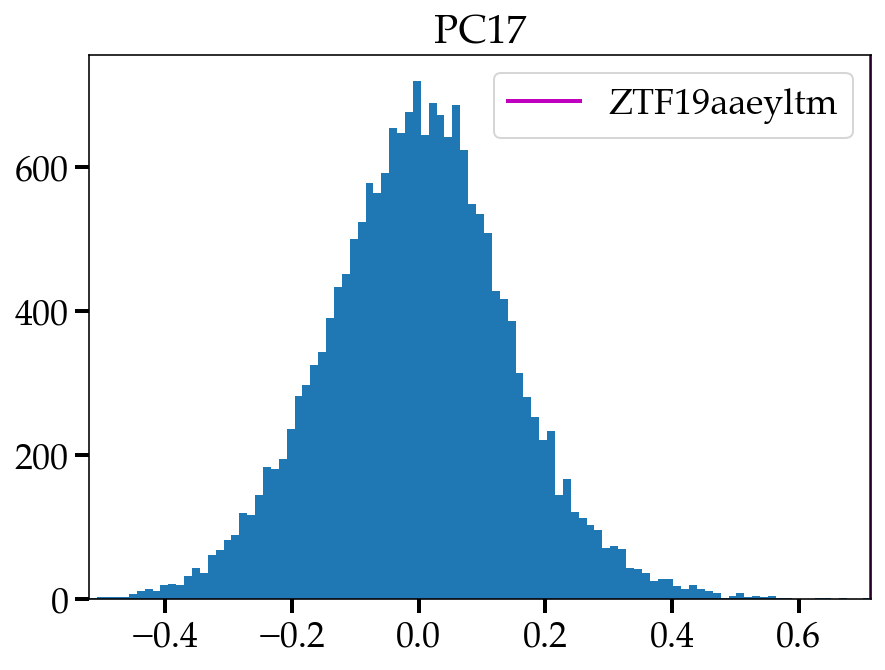

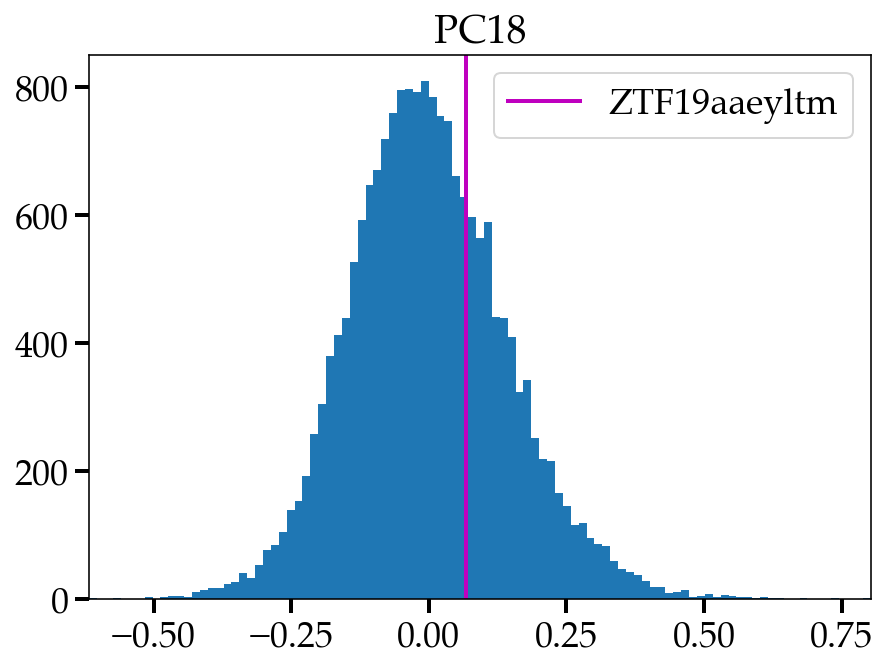

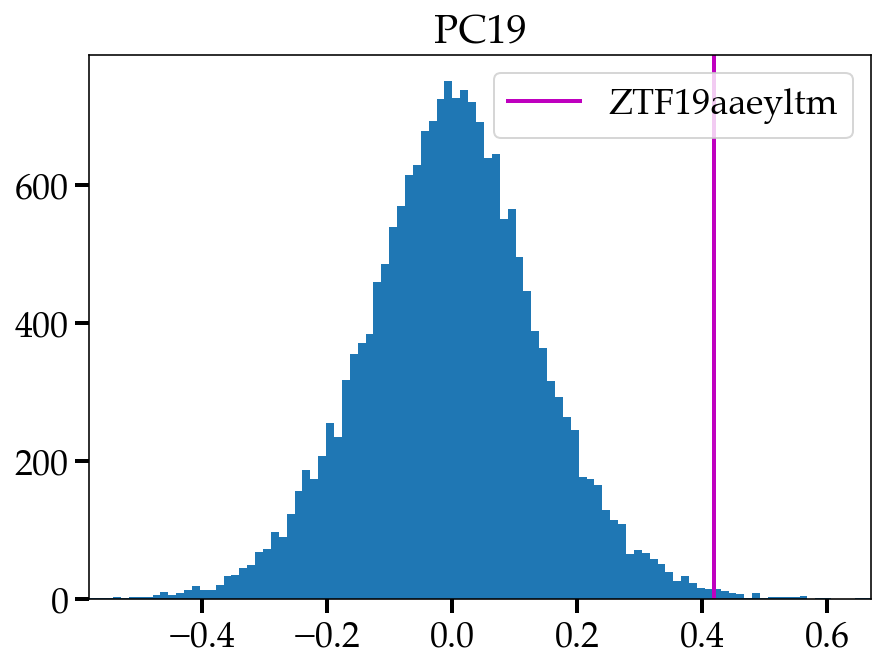

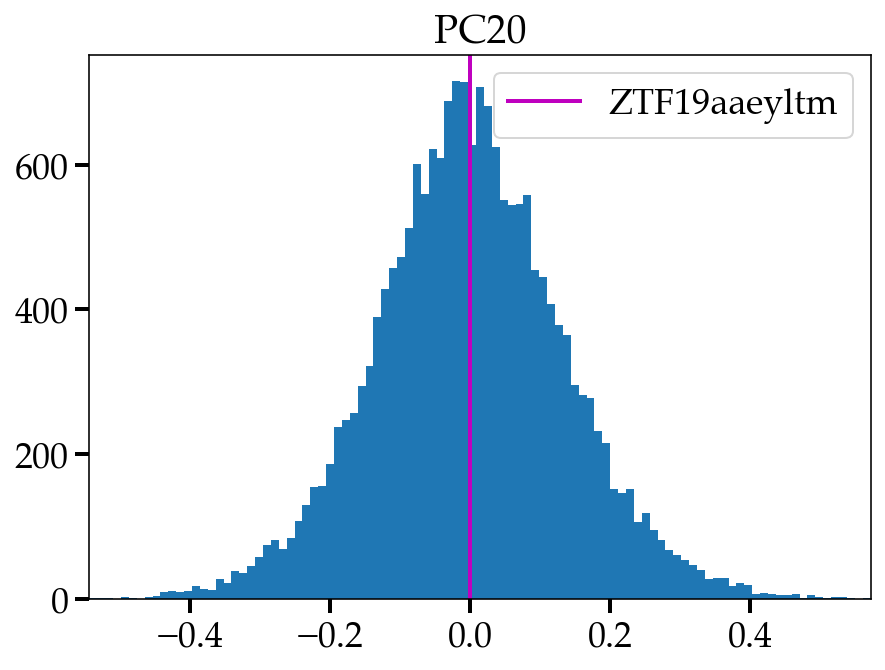

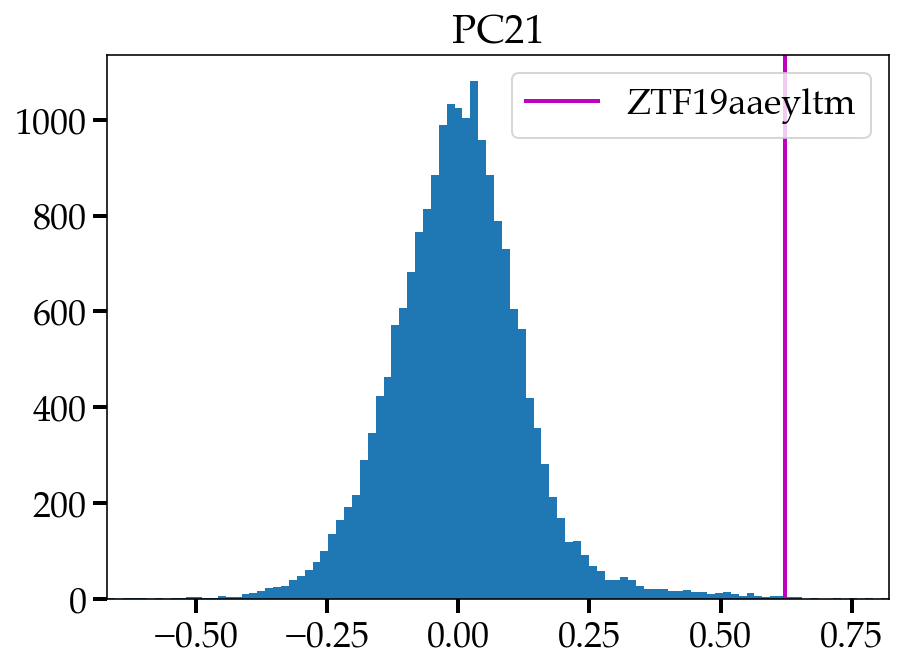

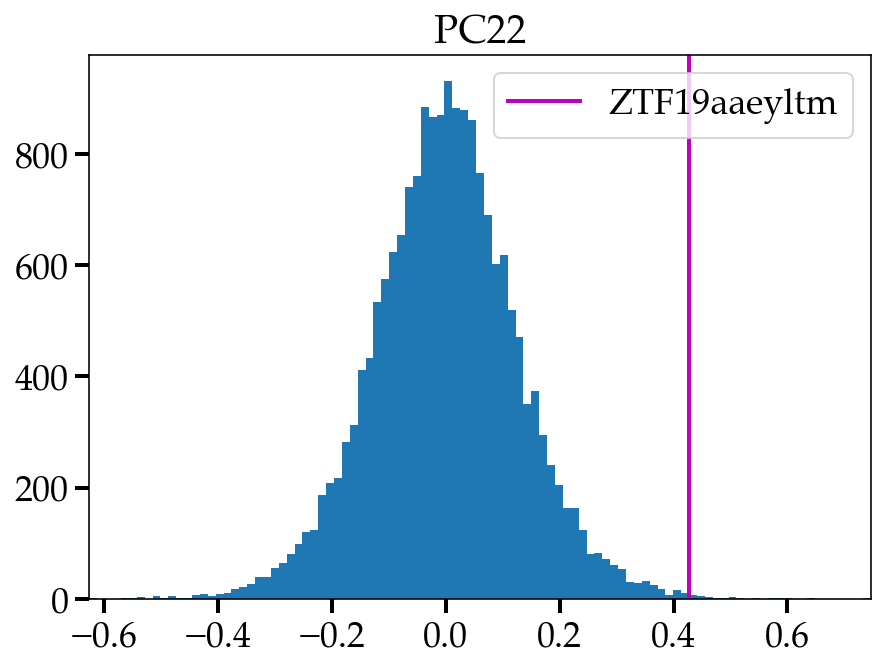

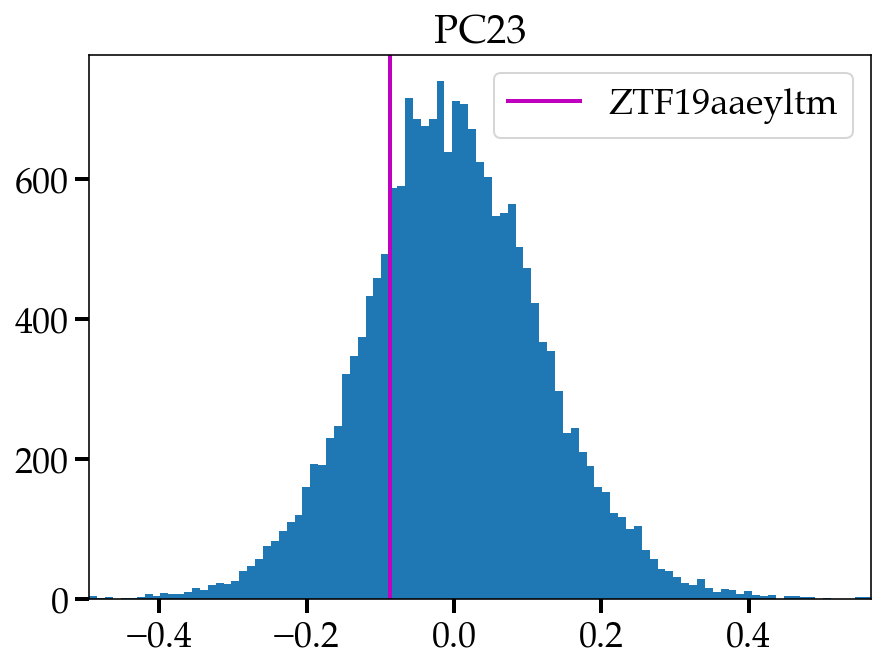

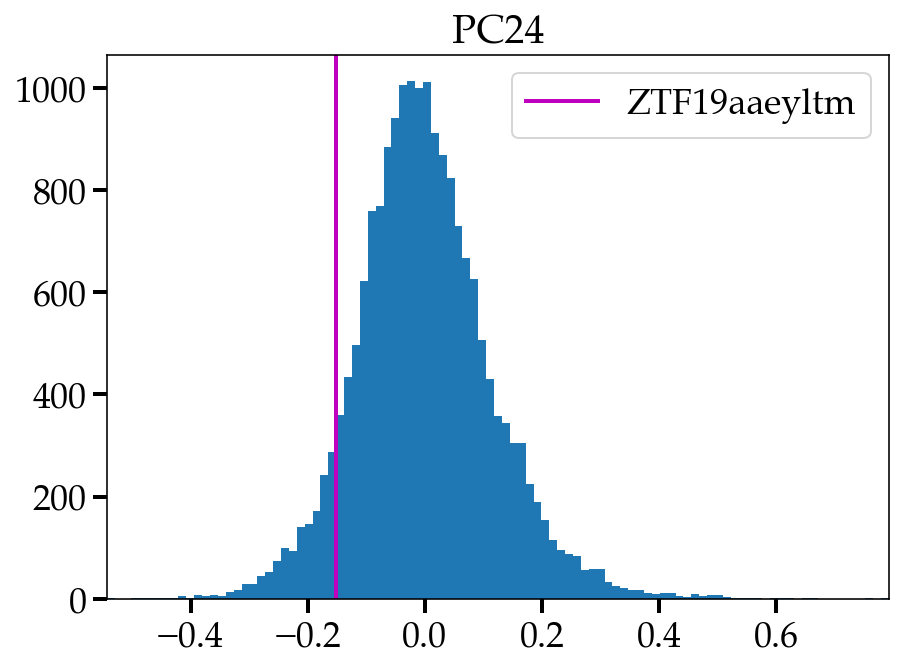

In [161]:
feat_scatter_l = []
for feat in dataset_bank.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(dataset_bank[feat], bins=np.linspace(min_feat, max_feat, 100))
    
    ref = dataset_bank[dataset_bank.index == ref_obj]
    
    ax.axvline(ref[feat].values[0], color='m', label=ref_obj)
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend()
    plt.show()
    
    feat_scatter = np.std(dataset_bank[feat])
    feat_scatter_l.append(feat_scatter)   

In [162]:
dataset_ref = dataset_bank[dataset_bank.index == ref_obj] #  ref_obj

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

# print(f"ZTF ID name (ref) {snid}") 
# link_ref = display_markdown(f'https://alerce.online/object/{snid}', raw=True)
# print(link_ref)
# print("%%%%%%")
# print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

print(f"ZTF ID name (ref) {snid}") 
link_ref = f'https://alerce.online/object/{snid}'
print(link_ref)
print("%%%%%%")
# print("ANN\t\tZTF_id\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
#     dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
#     print(f"{n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t\t{round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

#print("ANN\t\tZTF_id\t\t\t\tHas TNS?\t\t\t\tSpec Cls\t\t\t\tspecz\t\t\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    # host ra,dec
    ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
    
    # tns
    has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
    tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
    spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z
    
    print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

[-0.5259457185359789 1.3480167571688388 0.8331971215549467
 -0.33918436109028155 0.9615817602204646 0.44052020149512316
 0.443038154115428 -0.10153533039597357 0.0088285012545405
 0.3292084408580196 -0.08739316673528927 -0.4445528489285465
 0.3737810859124815 0.538061845609646 -0.06236636103831038
 0.08654819079483639 0.017159616124448617 0.7133502189654201
 0.06701657336123923 0.41923003405599124 4.3923010632887785e-06
 0.6221911198324311 0.42666196150219793 -0.08675658723544288
 -0.15129335574198594]
ZTF ID name (ref) ZTF19aaeyltm
https://alerce.online/object/ZTF19aaeyltm
%%%%%%
ANN=0	https://alerce.online/object/ZTF19aaeyltm		No_TNS		None		z=-99.0			d=0.0	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=164.00618542+57.11700351&filter=color

ANN=1	https://alerce.online/object/ZTF19aanimme		No_TNS		None		z=-99.0			d=6.3609	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=194.19965442+78.3990151&filter=color

ANN=2	https://alerce.online/object/ZTF18abrcjet		No_TNS		None		z=-99.0			d

In [163]:
antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

In [164]:
# %%time

# ztf_id_ref = idx_arr[result_id[0]]
# ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
# df_ref = ref_info.timeseries.to_pandas()

# has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
# tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls

# fig, ax = plt.subplots(figsize=(7,7))
# #plt.gca().invert_yaxis()

# df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
# df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

# ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[0], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
#             label=f'REF: {ztf_id_ref}, d={round(result_dist[0], 3)}\n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}')
# ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[0], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
# #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1]-df_ref_r.ant_mag.min(), s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

# markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
# consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

# ztf_id_l = result_id[1:5]
# ztf_dist_l = result_dist[1:5]

# for num, loc in enumerate(ztf_id_l):
#     ztf_id_ann = idx_arr[ztf_id_l[num]]

#     l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
#     try:
#         df_knn = l_info.timeseries.to_pandas()
#     except: continue    
#     has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
#     tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
#     spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z

#     df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
#     df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]

#     ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[0], y=df_r.ant_mag.min()-df_r.ant_mag, yerr=df_r.ant_magerr, 
#                 fmt=markers[num], c='darkred', alpha=0.25, 
#                 label=f'ANN={num+1}: {ztf_id_ann}, d={round(ztf_dist_l[num], 3)}\n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}')
#     ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[0], y=df_g.ant_mag.min()-df_g.ant_mag, yerr=df_g.ant_magerr, 
#                 fmt=markers[num], c='darkgreen', alpha=0.25)
#     #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]-df_r.ant_mag.min(), s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

#     plt.ylabel('Apparent Mag. + Constant')
#     plt.xlabel('Days of event')
#     plt.xlim(-5, df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
#     plt.legend(frameon=False,
#                bbox_to_anchor=(1.00,0.53),
#                ncol=1)

#     plt.grid(True)
# plt.savefig(f'../figures/{ztf_id_ref}_ann={num+1}.jpg', dpi=150, bbox_inches='tight')

In [165]:
ann_dist_all_df.loc[ref_obj]

ann=0                  3680.000000
ann=1                 11746.000000
ann=2                  7635.000000
ann=3                 16841.000000
ann=4                 11131.000000
ann=5                 14160.000000
ann=6                 17526.000000
ann=7                    11.000000
ann=8                 14464.000000
ann=9                  9656.000000
dist=0                    0.000000
dist=1                    6.360868
dist=2                    6.369786
dist=3                    6.444147
dist=4                    6.476330
dist=5                    6.497824
dist=6                    6.515051
dist=7                    6.599927
dist=8                    6.618843
dist=9                    6.664868
Mean-9ANNs                6.505294
WeightedMean-9ANNs        6.410652
Name: ZTF19aaeyltm, dtype: float64

In [166]:
# 100 largest distances
ann_dist_all_df[dist_col].nlargest(100)

key_0
ZTF19aaeyltm    6.410652
ZTF21aaxntve    5.583668
ZTF21acbalhp    5.583320
ZTF20abfehpe    5.255635
ZTF18abvbbvs    5.220301
                  ...   
ZTF20acohmzr    4.151943
ZTF20acmpskp    4.150229
ZTF18aaxxfdz    4.149016
ZTF17aadilht    4.135017
ZTF18aabehyt    4.132290
Name: WeightedMean-9ANNs, Length: 100, dtype: float64

In [167]:
# 100 largest distances objs 
for ztfid in list(ann_dist_all_df[dist_col].nlargest(100).index):
    alerce_link = f'https://alerce.online/object/{ztfid}\n'
    print(alerce_link)

https://alerce.online/object/ZTF19aaeyltm

https://alerce.online/object/ZTF21aaxntve

https://alerce.online/object/ZTF21acbalhp

https://alerce.online/object/ZTF20abfehpe

https://alerce.online/object/ZTF18abvbbvs

https://alerce.online/object/ZTF20abeywdn

https://alerce.online/object/ZTF18abvmlow

https://alerce.online/object/ZTF21aaaadvr

https://alerce.online/object/ZTF18abtteya

https://alerce.online/object/ZTF18aaqvatw

https://alerce.online/object/ZTF18acjmzyy

https://alerce.online/object/ZTF18abwkzjq

https://alerce.online/object/ZTF18aabjliz

https://alerce.online/object/ZTF19acxfjcy

https://alerce.online/object/ZTF20acynjjo

https://alerce.online/object/ZTF21aaaqtwd

https://alerce.online/object/ZTF21aaaodzf

https://alerce.online/object/ZTF19aaczlfy

https://alerce.online/object/ZTF20acqucpz

https://alerce.online/object/ZTF18aaxuusk

https://alerce.online/object/ZTF18aabhmmj

https://alerce.online/object/ZTF21abfmbix

https://alerce.online/object/ZTF21aaaigfg

https://ale

In [ ]:
# weird flaring red star? https://alerce.online/object/ZTF19aaxoyhu

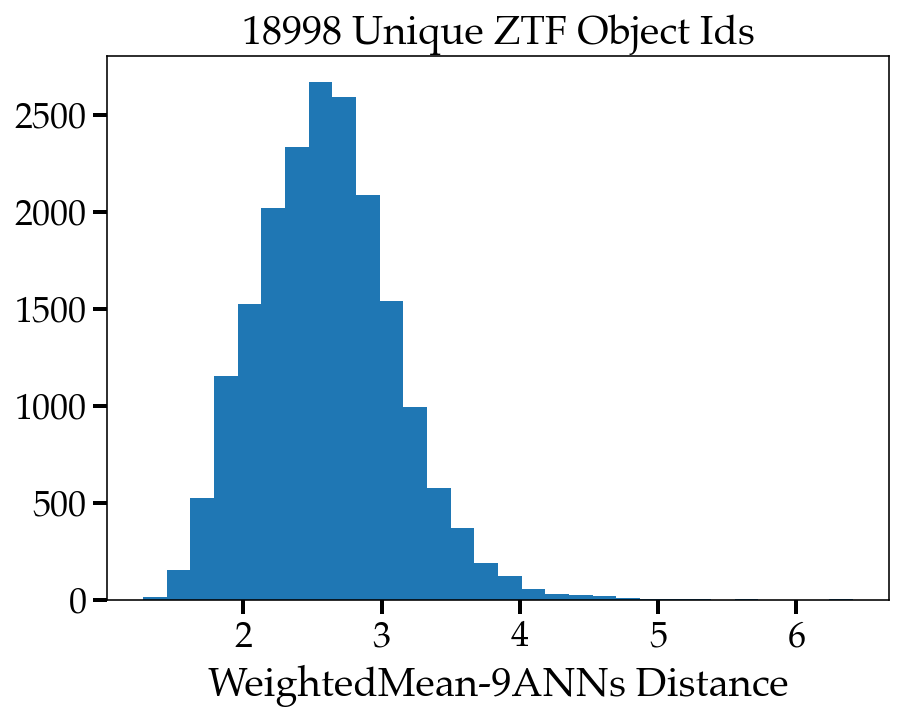

In [168]:
# 10 largest mean 9 ANN distances distances (most different)
plt.hist(ann_dist_all_df[dist_col], 
         bins=np.linspace(np.min(ann_dist_all_df[dist_col]), 
                          np.max(ann_dist_all_df[dist_col]), 31), density=False);
plt.xlabel(dist_col+' Distance');
#plt.yscale('log')
plt.title(f'{len(ann_dist_all_df)} Unique ZTF Object Ids');

In [169]:
print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df[dist_col]))
print("Scatter median:", np.median(ann_dist_all_df[dist_col]))
print("Scatter std:", np.std(ann_dist_all_df[dist_col]))
print("Scatter max:", np.max(ann_dist_all_df[dist_col]))
print("Scatter min:", np.min(ann_dist_all_df[dist_col]))
print("\n")

#Returns index of distance
print("Most anomalous:", ann_dist_all_df[[dist_col]].idxmax().values[0])

summary stats
Scatter mean: 2.6022078898311034
Scatter median: 2.584319216283885
Scatter std: 0.4976490188857527
Scatter max: 6.41065249117938
Scatter min: 1.2724317203868518


Most anomalous: ZTF19aaeyltm


# Smallest

### AGN/QSOs have smallest dist
### some stars, SN

In [170]:
ann_dist_all_df[dist_col].nsmallest(10)

key_0
ZTF19aalfali    1.272432
ZTF20aawoixs    1.369823
ZTF18acefnew    1.404568
ZTF19ablpvbh    1.406658
ZTF20abgxqyi    1.408864
ZTF18aasgiyf    1.418474
ZTF19abpkoqf    1.437658
ZTF20abfphyf    1.438225
ZTF19acqcvjv    1.439796
ZTF20abvavvm    1.440104
Name: WeightedMean-9ANNs, dtype: float64

In [171]:
# 10 smallest  distances (most similar)
for ztfid in list(ann_dist_all_df[dist_col].nsmallest(100).index):
    alerce_link = f'https://alerce.online/object/{ztfid}\n'
    print(alerce_link)

https://alerce.online/object/ZTF19aalfali

https://alerce.online/object/ZTF20aawoixs

https://alerce.online/object/ZTF18acefnew

https://alerce.online/object/ZTF19ablpvbh

https://alerce.online/object/ZTF20abgxqyi

https://alerce.online/object/ZTF18aasgiyf

https://alerce.online/object/ZTF19abpkoqf

https://alerce.online/object/ZTF20abfphyf

https://alerce.online/object/ZTF19acqcvjv

https://alerce.online/object/ZTF20abvavvm

https://alerce.online/object/ZTF21aarwlht

https://alerce.online/object/ZTF19adcfrut

https://alerce.online/object/ZTF19aascqjr

https://alerce.online/object/ZTF19abyhwmw

https://alerce.online/object/ZTF21abowuqe

https://alerce.online/object/ZTF20aaemssm

https://alerce.online/object/ZTF18aaxwzcl

https://alerce.online/object/ZTF19abggdjc

https://alerce.online/object/ZTF19abyidhr

https://alerce.online/object/ZTF19acmvzsy

https://alerce.online/object/ZTF17aaayial

https://alerce.online/object/ZTF18abixqaz

https://alerce.online/object/ZTF19abgfufo

https://ale

In [172]:
dataset_ref = dataset_bank[dataset_bank.index == list(ann_dist_all_df[dist_col].nsmallest(10).index)[0]]

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

# print(f"ZTF ID name (ref) {snid}") 
# link_ref = display_markdown(f'https://alerce.online/object/{snid}', raw=True)
# print(link_ref)
# print("%%%%%%")
# print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

print(f"ZTF ID name (ref) {snid}") 
link_ref = f'https://alerce.online/object/{snid}'
print(link_ref)
print("%%%%%%")
# print("ANN\t\tZTF_id\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
#     dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
#     print(f"{n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t\t{round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    # host ra,dec
    ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
    
    # tns
    has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
    tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
    spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z
    
    print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

[0.475511439197259 -0.0018139876492286081 0.3229066952510532
 0.46158058451309597 -0.5090000316794256 -0.03230245778737791
 0.1186337625063944 0.16261990320214129 0.4770669482199119
 0.3401474585641272 -0.1441016380797963 0.15929003374189252
 -0.024329684432908918 0.0018060991690186997 0.016597862373299643
 -0.03706572223623893 0.08447377497474479 0.04265814143641549
 0.09759258253694916 0.01033791550374965 -0.005305803185778178
 -0.03565196401360493 0.04827197560163978 -0.10974293442733446
 0.42333461858096777]
ZTF ID name (ref) ZTF19aalfali
https://alerce.online/object/ZTF19aalfali
%%%%%%
ANN=0	https://alerce.online/object/ZTF19aalfali		Yes_TNS		None		z=-99.0			d=0.0	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=267.06517947+55.23697266&filter=color

ANN=1	https://alerce.online/object/ZTF19aascqjr		No_TNS		None		z=-99.0			d=1.0733	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=218.41909158+60.96265845&filter=color

ANN=2	https://alerce.online/object/ZTF19aasltpf		No_TNS		None	

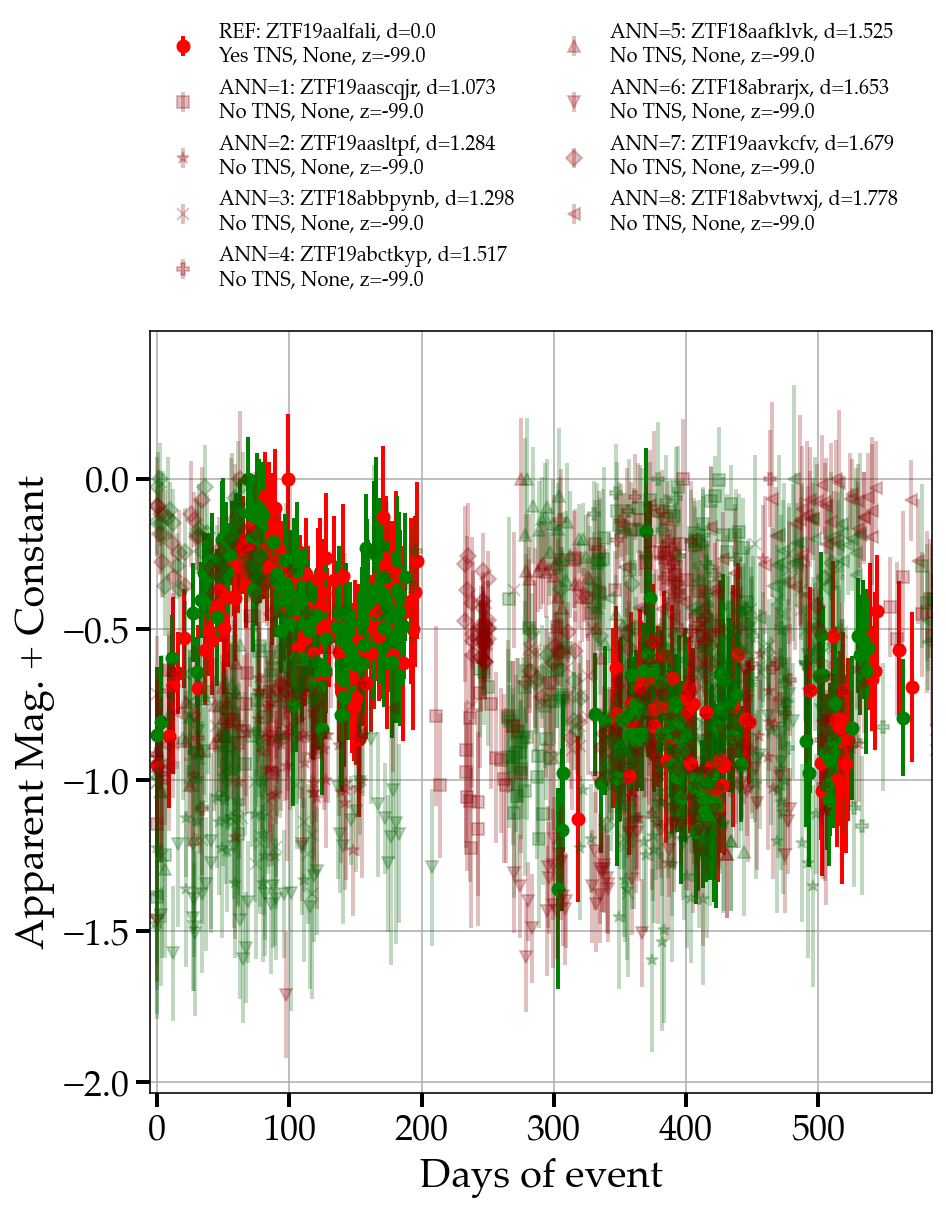

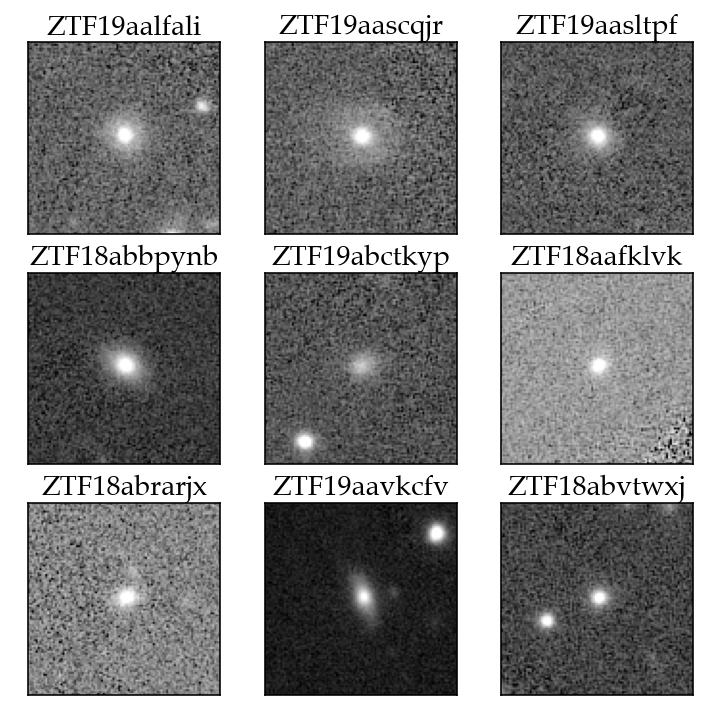

CPU times: user 5.72 s, sys: 305 ms, total: 6.03 s
Wall time: 18.6 s


In [173]:
%%time

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

ztf_id_ref = idx_arr[result_id[0]]
ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

ra_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].raMean
dec_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].decMean
host_df_ztf_id_l.append(ztf_id_ref), host_df_ra_l.append(ra_ref), host_df_dec_l.append(dec_ref)


fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[0], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
            label=f'REF: {ztf_id_ref}, d={round(result_dist[0], 3)}\n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[0], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
#ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1]-df_ref_r.ant_mag.min(), s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = result_id[1:9]
ztf_dist_l = result_dist[1:9]

for num, loc in enumerate(ztf_id_l):
    ztf_id_ann = idx_arr[ztf_id_l[num]]

    l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
    try:
        df_knn = l_info.timeseries.to_pandas()
    except: continue    
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z
    
    ra_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].decMean
    host_df_ztf_id_l.append(ztf_id_ann), host_df_ra_l.append(ra_i), host_df_dec_l.append(dec_i)

    df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]

    ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[0], y=df_r.ant_mag.min()-df_r.ant_mag, yerr=df_r.ant_magerr, 
                fmt=markers[num], c='darkred', alpha=0.25, 
                label=f'ANN={num+1}: {ztf_id_ann}, d={round(ztf_dist_l[num], 3)}\n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}')
    ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[0], y=df_g.ant_mag.min()-df_g.ant_mag, yerr=df_g.ant_magerr, 
                fmt=markers[num], c='darkgreen', alpha=0.25)
    #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]-df_r.ant_mag.min(), s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

    plt.ylabel('Apparent Mag. + Constant')
    plt.xlabel('Days of event')
    plt.xlim(-5, df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    plt.legend(frameon=False,
               bbox_to_anchor=(0.98,1.43),
               ncol=2,
               prop={'size': 10})

    plt.grid(True)
    
plt.savefig(f'../figures/{ztf_id_ref}_ann={num+1}_manhattan.jpg', dpi=150, bbox_inches='tight')

host_5ann_df = pd.DataFrame(zip(host_df_ztf_id_l, host_df_ra_l, host_df_dec_l), columns=['name', 'ra', 'dec'])

host_pdfs(df=host_5ann_df)

In [174]:
# dist ANN=1 and mean of first 9 ANN are roughly same (SN, CV, Mira, etc). 
# Not as many SN (but otherwise similar as above) in weighted (fibonacci) average of first 9 ANN.
# Separation will come down to host gal info

MaxAbsScaler, Euclidean, Ia

NON PCA
Scatter mean: 0.10822062189269697
Scatter median: 0.08390001702324312
Scatter std: 0.09273033952967297
Scatter max: 0.3615067063860504
Scatter min: 0.0

PCA
Scatter mean: 0.22748059656595504
Scatter median: 0.23485067052158148
Scatter std: 0.08590310140277316
Scatter max: 0.3552833440373228
Scatter min: 0.013447031738069838

MaxAbsScaler, Euclidean, SLSN

Scatter mean: 0.1882023265906344
Scatter median: 0.14632144856515017
Scatter std: 0.1839875260098897
Scatter max: 1.046586348913336
Scatter min: 0.006225538066605167

MaxAbsScaler, Euclidean, junk

Scatter mean: 0.18480675721201786
Scatter median: 0.14364864210180578
Scatter std: 0.208412667064402
Scatter max: 1.2017613918543555
Scatter min: 0.002740342445819787

# pandas profiling

In [175]:
ann_dist_all_tns_df = pd.concat([ann_dist_all_df, dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
ann_dist_all_tns_df = ann_dist_all_tns_df[~ann_dist_all_tns_df.isnull().any(axis=1)]

ann_dist_all_tns_df

ann=0  ann=1  ann=2  ann=3  ann=4  ann=5  ann=6  ann=7  ann=8  \
ZTF17aaaaenu  18790   6649  13209  14428   8815   8988   7697  11811   6230   
ZTF17aaaazhi  16293  11694    900   7680   5764   6680  16822  11784   1242   
ZTF17aaaazmz   9278  18392  10854   4196  13821   5253  13787  11383  10115   
ZTF17aaabghb   7729   8345  10679   2012  11735  16892   7521  18175  13702   
ZTF17aaabuab  13760  16799  12701  16398   6645   2745   5941   2455   6825   
...             ...    ...    ...    ...    ...    ...    ...    ...    ...   
ZTF21acogvaq   8545   4406   3097   5763   6583  13656   2777  10814   4807   
ZTF21acowflo   7527   7924  11086   9290   8220    347   9505   4445   1844   
ZTF21acqdfea   7777   1489   9363   8136   5053   8363   1731   9119  13863   
ZTF21acqnurt   8040   5704   3780   9349   8575  11187   4052   9634  17085   
ZTF21acqtdnd  14318   7559   5555  13649   5262  13245   3350  12555   8468   

              ann=9  ...    dist=6    dist=7    dist=8    dist=9  Mean-9ANNs  \
ZTF17aaaaenu  12358  ...  2.771687  2.970411  2.972721  2.976331    2.746712   
ZTF17aaaazhi    241  ...  3.361781  3.367687  3.408665  3.429598    3.174018   
ZTF17aaaazmz    400  ...  3.031959  3.066046  3.088347  3.099874    2.816637   
ZTF17aaabghb  10797  ...  2.571884  2.593932  2.629716  2.634124    2.446292   
ZTF17aaabuab   5730  ...  3.100569  3.149559  3.169443  3.223724    2.989983   
...             ...  ...       ...       ...       ...       ...         ...   
ZTF21acogvaq   1928  ...  2.982801  2.991531  3.017424  3.065472    2.856268   
ZTF21acowflo   9522  ...  3.017590  3.025151  3.170483  3.203540    2.951771   
ZTF21acqdfea   2915  ...  2.438983  2.476552  2.497445  2.514253    2.385581   
ZTF21acqnurt   2586  ...  3.588788  3.692314  3.767519  3.807232    3.554279   
ZTF21acqtdnd  10613  ...  3.918809  3.970216  4.007190  4.081807    3.779589   

              WeightedMean-9ANNs  has_tns  tns_cls  spec_z  report_group  
ZTF17aaaaenu            2.536319   No_TNS     None   -99.0          None  
ZTF17aaaazhi            2.947467   No_TNS     None   -99.0          None  
ZTF17aaaazmz            2.480726   No_TNS     None   -99.0          None  
ZTF17aaabghb            2.268916   No_TNS     None   -99.0          None  
ZTF17aaabuab            2.792348   No_TNS     None   -99.0          None  
...                          ...      ...      ...     ...           ...  
ZTF21acogvaq            2.667161   No_TNS     None   -99.0          None  
ZTF21acowflo            2.780722   No_TNS     None   -99.0          None  
ZTF21acqdfea            2.286233   No_TNS     None   -99.0          None  
ZTF21acqnurt            3.391971   No_TNS     None   -99.0          None  
ZTF21acqtdnd            3.503785  Yes_TNS     None   -99.0    GaiaAlerts  

[18992 rows x 26 columns]

In [176]:
ann_dist_all_tns_and_hosts_df_p1 = pd.concat([ann_dist_all_df.iloc[:,11:],
                                           dataset_bank_tns_and_hosts_df.iloc[:, 0:11],
                                           dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
ann_dist_all_tns_and_hosts_df_p1 = ann_dist_all_tns_and_hosts_df_p1[~ann_dist_all_tns_and_hosts_df_p1.isnull().any(axis=1)]

ann_dist_all_tns_and_hosts_df_p1

dist=1    dist=2    dist=3    dist=4    dist=5    dist=6  \
ZTF17aaaaenu  2.305550  2.601308  2.647424  2.727868  2.747110  2.771687   
ZTF17aaaazhi  2.767181  2.913928  3.074223  3.087019  3.156081  3.361781   
ZTF17aaaazmz  2.208861  2.399581  2.542626  2.926282  2.986156  3.031959   
ZTF17aaabghb  2.165431  2.173353  2.350522  2.395709  2.501954  2.571884   
ZTF17aaabuab  2.630857  2.751327  2.909887  2.934905  3.039580  3.100569   
...                ...       ...       ...       ...       ...       ...   
ZTF21acogvaq  2.469516  2.681405  2.807652  2.823394  2.867223  2.982801   
ZTF21acowflo  2.618925  2.805350  2.855224  2.934785  2.934894  3.017590   
ZTF21acqdfea  2.211040  2.294348  2.302846  2.313089  2.421674  2.438983   
ZTF21acqnurt  3.258629  3.417747  3.441457  3.462854  3.551971  3.588788   
ZTF21acqtdnd  3.171575  3.623932  3.634476  3.773808  3.834483  3.918809   

                dist=7    dist=8    dist=9  Mean-9ANNs  ...  gPSFFlux  \
ZTF17aaaaenu  2.970411  2.972721  2.976331    2.746712  ...  0.000006   
ZTF17aaaazhi  3.367687  3.408665  3.429598    3.174018  ...  0.000008   
ZTF17aaaazmz  3.066046  3.088347  3.099874    2.816637  ...  0.000022   
ZTF17aaabghb  2.593932  2.629716  2.634124    2.446292  ...  0.000027   
ZTF17aaabuab  3.149559  3.169443  3.223724    2.989983  ...  0.000030   
...                ...       ...       ...         ...  ...       ...   
ZTF21acogvaq  2.991531  3.017424  3.065472    2.856268  ...  0.000019   
ZTF21acowflo  3.025151  3.170483  3.203540    2.951771  ...  0.000003   
ZTF21acqdfea  2.476552  2.497445  2.514253    2.385581  ...  0.000010   
ZTF21acqnurt  3.692314  3.767519  3.807232    3.554279  ...  0.000003   
ZTF21acqtdnd  3.970216  4.007190  4.081807    3.779589  ...  0.000008   

               gApFlux  gKronFlux  gKronRad  gExtNSigma  rmomentXX  has_tns  \
ZTF17aaaaenu  0.000013   0.000015   3.78109   12.034700   0.240854   No_TNS   
ZTF17aaaazhi  0.000010   0.000009   2.83895    2.027450   0.146499   No_TNS   
ZTF17aaaazmz  0.000036   0.000035   3.51821   10.532400   0.254686   No_TNS   
ZTF17aaabghb  0.000043   0.000044   4.06217    9.808500   0.288022   No_TNS   
ZTF17aaabuab  0.000056   0.000056   3.96768   15.671700   0.237536   No_TNS   
...                ...        ...       ...         ...        ...      ...   
ZTF21acogvaq  0.000038   0.000039   3.84154   15.055400   0.185502   No_TNS   
ZTF21acowflo  0.000006   0.000007   3.67332    3.683880   0.249079   No_TNS   
ZTF21acqdfea  0.000023   0.000026   4.15479   15.726700   0.289378   No_TNS   
ZTF21acqnurt  0.000004   0.000004   2.81373    3.489210   0.245337   No_TNS   
ZTF21acqtdnd  0.000008   0.000007   2.52650    0.472144   0.172303  Yes_TNS   

              tns_cls  spec_z  report_group  
ZTF17aaaaenu     None   -99.0          None  
ZTF17aaaazhi     None   -99.0          None  
ZTF17aaaazmz     None   -99.0          None  
ZTF17aaabghb     None   -99.0          None  
ZTF17aaabuab     None   -99.0          None  
...               ...     ...           ...  
ZTF21acogvaq     None   -99.0          None  
ZTF21acowflo     None   -99.0          None  
ZTF21acqdfea     None   -99.0          None  
ZTF21acqnurt     None   -99.0          None  
ZTF21acqtdnd     None   -99.0    GaiaAlerts  

[18992 rows x 26 columns]

In [177]:
ann_dist_all_tns_and_lcfeats_df_p1 = pd.concat([ann_dist_all_df.iloc[:,20:],
                                           dataset_bank_tns_and_lcfeats_df.iloc[:, 0:21],
                                           dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
ann_dist_all_tns_and_lcfeats_df_p1 = ann_dist_all_tns_and_lcfeats_df_p1[~ann_dist_all_tns_and_lcfeats_df_p1.isnull().any(axis=1)]

ann_dist_all_tns_and_lcfeats_df_p1

Mean-9ANNs  WeightedMean-9ANNs  feature_amplitude_magn_r  \
ZTF17aaaaenu    2.746712            2.536319                  0.994978   
ZTF17aaaazhi    3.174018            2.947467                  1.198246   
ZTF17aaaazmz    2.816637            2.480726                  1.171598   
ZTF17aaabghb    2.446292            2.268916                  0.362954   
ZTF17aaabuab    2.989983            2.792348                  0.320659   
...                  ...                 ...                       ...   
ZTF21acogvaq    2.856268            2.667161                  0.208000   
ZTF21acowflo    2.951771            2.780722                  1.043352   
ZTF21acqdfea    2.385581            2.286233                  1.103750   
ZTF21acqnurt    3.554279            3.391971                  1.511355   
ZTF21acqtdnd    3.779589            3.503785                  0.943990   

              feature_anderson_darling_normal_magn_r  \
ZTF17aaaaenu                               -0.133575   
ZTF17aaaazhi                                0.304374   
ZTF17aaaazmz                               -0.125017   
ZTF17aaabghb                               -0.653712   
ZTF17aaabuab                               -0.848917   
...                                              ...   
ZTF21acogvaq                               -1.031033   
ZTF21acowflo                                0.176584   
ZTF21acqdfea                               -0.195983   
ZTF21acqnurt                               -0.366659   
ZTF21acqtdnd                                0.335738   

              feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ZTF17aaaaenu                     0.192308                     0.196116   
ZTF17aaaazhi                     0.440000                     0.000000   
ZTF17aaaazmz                     0.229508                     0.181071   
ZTF17aaabghb                     0.444444                     0.000000   
ZTF17aaabuab                     0.400000                     0.000000   
...                                   ...                          ...   
ZTF21acogvaq                     0.500000                     0.000000   
ZTF21acowflo                     0.413793                     0.000000   
ZTF21acqdfea                     0.314286                     0.239046   
ZTF21acqnurt                     0.285714                     0.000000   
ZTF21acqtdnd                     0.200000                     0.000000   

              feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ZTF17aaaaenu              0.158742                                 1.972990   
ZTF17aaaazhi              0.264522                                 2.396492   
ZTF17aaaazmz              0.230875                                 2.106324   
ZTF17aaabghb              0.334459                                 0.725908   
ZTF17aaabuab              0.398610                                 0.641317   
...                            ...                                      ...   
ZTF21acogvaq              0.400851                                 0.416000   
ZTF21acowflo              0.337711                                 2.075553   
ZTF21acqdfea              0.177260                                 2.062999   
ZTF21acqnurt              0.357832                                 3.022711   
ZTF21acqtdnd              0.376860                                 1.887980   

              feature_inter_percentile_range_10_magn_r  \
ZTF17aaaaenu                                  0.814137   
ZTF17aaaazhi                                  2.000199   
ZTF17aaaazmz                                  0.937863   
ZTF17aaabghb                                  0.667269   
ZTF17aaabuab                                  0.641317   
...                                                ...   
ZTF21acogvaq                                  0.416000   
ZTF21acowflo                                  1.568862   
ZTF21acqdfea                                  1.245758   
ZTF21acqnurt                      

In [178]:
ann_dist_all_tns_and_lcfeats_df_p2 = pd.concat([ann_dist_all_df.iloc[:,20:],
                                           dataset_bank_tns_and_lcfeats_df.iloc[:, 21:41],
                                           dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
ann_dist_all_tns_and_lcfeats_df_p2 = ann_dist_all_tns_and_lcfeats_df_p2[~ann_dist_all_tns_and_lcfeats_df_p2.isnull().any(axis=1)]

ann_dist_all_tns_and_lcfeats_df_p2

Mean-9ANNs  WeightedMean-9ANNs  \
ZTF17aaaaenu    2.746712            2.536319   
ZTF17aaaazhi    3.174018            2.947467   
ZTF17aaaazmz    2.816637            2.480726   
ZTF17aaabghb    2.446292            2.268916   
ZTF17aaabuab    2.989983            2.792348   
...                  ...                 ...   
ZTF21acogvaq    2.856268            2.667161   
ZTF21acowflo    2.951771            2.780722   
ZTF21acqdfea    2.385581            2.286233   
ZTF21acqnurt    3.554279            3.391971   
ZTF21acqtdnd    3.779589            3.503785   

              feature_percent_difference_magnitude_percentile_10_magn_r  \
ZTF17aaaaenu                                          -1.360545           
ZTF17aaaazhi                                          -0.939406           
ZTF17aaaazmz                                          -1.246568           
ZTF17aaabghb                                          -1.416847           
ZTF17aaabuab                                          -1.477782           
...                                                         ...           
ZTF21acogvaq                                          -1.689292           
ZTF21acowflo                                          -1.008615           
ZTF21acqdfea                                          -1.115018           
ZTF21acqnurt                                          -0.789242           
ZTF21acqtdnd                                          -0.983584           

              feature_period_s_to_n_0_magn_r  feature_period_s_to_n_1_magn_r  \
ZTF17aaaaenu                        2.125293                        1.992442   
ZTF17aaaazhi                        1.815708                        1.591342   
ZTF17aaaazmz                        2.179178                        1.933757   
ZTF17aaabghb                        1.344333                        1.333010   
ZTF17aaabuab                        1.488277                        1.323163   
...                                      ...                             ...   
ZTF21acogvaq                        1.403898                        1.316485   
ZTF21acowflo                        2.177635                        1.889092   
ZTF21acqdfea                        2.050165                        1.911864   
ZTF21acqnurt                        1.460312                        1.448992   
ZTF21acqtdnd                        1.546082                        1.497795   

              feature_period_s_to_n_2_magn_r  feature_period_s_to_n_3_magn_r  \
ZTF17aaaaenu                        1.744146                        1.643873   
ZTF17aaaazhi                        1.539998                        1.538721   
ZTF17aaaazmz                        1.855695                        1.721224   
ZTF17aaabghb                        1.328976                        1.289912   
ZTF17aaabuab                        1.001883                        0.864970   
...                                      ...                             ...   
ZTF21acogvaq                        1.123045                        0.248722   
ZTF21acowflo                        1.746470                        1.722375   
ZTF21acqdfea                        1.884375                        1.830220   
ZTF21acqnurt                        1.435716                        1.250504   
ZTF21acqtdnd                        1.422824                        1.328929   

              feature_period_s_to_n_4_magn_r  \
ZTF17aaaaenu                        1.467939   
ZTF17aaaazhi                        1.322658   
ZTF17aaaazmz                        1.688221   
ZTF17aaabghb                        1.243621   
ZTF17aaabuab                        0.854680   
...                                      ...   
ZTF21acogvaq                       -0.249409   
ZTF21acowflo                        1.587684   
ZTF21acqdfea                        1.639242   
ZTF21acqnurt                        1.178680   
ZTF21acqtdnd                        1.231618   

              feature_periodogram_bey

import pandas_profiling as pp
profile = pp.ProfileReport(ann_dist_all_tns_and_lcfeats_df_p2)
#profile = pp.ProfileReport(dataset_bank_tns_df)
#profile.to_file("output.html")
profile.to_file("ann_dist_all_tns_and_lcfeats_df_p2.html")

import pandas_profiling as pp
profile = pp.ProfileReport(dataset_bank_orig[0:1000])
#profile = pp.ProfileReport(dataset_bank_tns_df)
#profile.to_file("output.html")
profile.to_file("dataset_bank_orig.html")

In [179]:
# %%time

# ztf_id_ref = idx_arr[result_id[0]]
# ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
# df_ref = ref_info.timeseries.to_pandas()

# has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
# tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls

# fig, ax = plt.subplots(figsize=(7,11))
# plt.gca().invert_yaxis()

# df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
# df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

# ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[0], y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', label=f'ref {ztf_id_ref}')
# ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[0], y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
# ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1], s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

# markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
# consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

# ztf_id_l = result_id[1:8]
# ztf_dist_l = result_dist[1:8]

# for num, loc in enumerate(ztf_id_l):
#     ztf_id_ann = idx_arr[ztf_id_l[num]]

#     l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
#     try:
#         df_knn = l_info.timeseries.to_pandas()
#     except: continue    
#     has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
#     tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls

#     df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
#     df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]

#     ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[0], y=df_r.ant_mag+consts[num], yerr=df_r.ant_magerr, 
#                 fmt=markers[num], c='darkred', alpha=0.5, label=f'ANN={num+1} {ztf_id_ann} d={round(ztf_dist_l[num], 3)}')
#     ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[0], y=df_g.ant_mag+consts[num], yerr=df_g.ant_magerr, 
#                 fmt=markers[num], c='darkgreen', alpha=0.5)
#     ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]+consts[num], s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

#     plt.ylabel('Apparent Mag. + Constant')
#     plt.xlabel('Days of event')
#     plt.xlim(-5, df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+50)
#     plt.legend(frameon=False,
#                bbox_to_anchor=(1.00,0.98),
#                ncol=1)

#     plt.grid(True)
# #plt.savefig(f'./LAISS_figures/{ztf_id_ref}_knn={num+1}.png', dpi=300, bbox_inches='tight')

In [180]:
ann_dist_all_tns_df

ann=0  ann=1  ann=2  ann=3  ann=4  ann=5  ann=6  ann=7  ann=8  \
ZTF17aaaaenu  18790   6649  13209  14428   8815   8988   7697  11811   6230   
ZTF17aaaazhi  16293  11694    900   7680   5764   6680  16822  11784   1242   
ZTF17aaaazmz   9278  18392  10854   4196  13821   5253  13787  11383  10115   
ZTF17aaabghb   7729   8345  10679   2012  11735  16892   7521  18175  13702   
ZTF17aaabuab  13760  16799  12701  16398   6645   2745   5941   2455   6825   
...             ...    ...    ...    ...    ...    ...    ...    ...    ...   
ZTF21acogvaq   8545   4406   3097   5763   6583  13656   2777  10814   4807   
ZTF21acowflo   7527   7924  11086   9290   8220    347   9505   4445   1844   
ZTF21acqdfea   7777   1489   9363   8136   5053   8363   1731   9119  13863   
ZTF21acqnurt   8040   5704   3780   9349   8575  11187   4052   9634  17085   
ZTF21acqtdnd  14318   7559   5555  13649   5262  13245   3350  12555   8468   

              ann=9  ...    dist=6    dist=7    dist=8    dist=9  Mean-9ANNs  \
ZTF17aaaaenu  12358  ...  2.771687  2.970411  2.972721  2.976331    2.746712   
ZTF17aaaazhi    241  ...  3.361781  3.367687  3.408665  3.429598    3.174018   
ZTF17aaaazmz    400  ...  3.031959  3.066046  3.088347  3.099874    2.816637   
ZTF17aaabghb  10797  ...  2.571884  2.593932  2.629716  2.634124    2.446292   
ZTF17aaabuab   5730  ...  3.100569  3.149559  3.169443  3.223724    2.989983   
...             ...  ...       ...       ...       ...       ...         ...   
ZTF21acogvaq   1928  ...  2.982801  2.991531  3.017424  3.065472    2.856268   
ZTF21acowflo   9522  ...  3.017590  3.025151  3.170483  3.203540    2.951771   
ZTF21acqdfea   2915  ...  2.438983  2.476552  2.497445  2.514253    2.385581   
ZTF21acqnurt   2586  ...  3.588788  3.692314  3.767519  3.807232    3.554279   
ZTF21acqtdnd  10613  ...  3.918809  3.970216  4.007190  4.081807    3.779589   

              WeightedMean-9ANNs  has_tns  tns_cls  spec_z  report_group  
ZTF17aaaaenu            2.536319   No_TNS     None   -99.0          None  
ZTF17aaaazhi            2.947467   No_TNS     None   -99.0          None  
ZTF17aaaazmz            2.480726   No_TNS     None   -99.0          None  
ZTF17aaabghb            2.268916   No_TNS     None   -99.0          None  
ZTF17aaabuab            2.792348   No_TNS     None   -99.0          None  
...                          ...      ...      ...     ...           ...  
ZTF21acogvaq            2.667161   No_TNS     None   -99.0          None  
ZTF21acowflo            2.780722   No_TNS     None   -99.0          None  
ZTF21acqdfea            2.286233   No_TNS     None   -99.0          None  
ZTF21acqnurt            3.391971   No_TNS     None   -99.0          None  
ZTF21acqtdnd            3.503785  Yes_TNS     None   -99.0    GaiaAlerts  

[18992 rows x 26 columns]

AGN
Mean 2.601829759370197
https://alerce.online/object/ZTF18aajupnt
https://alerce.online/object/ZTF18abuoilc
https://alerce.online/object/ZTF18abvpnnb
https://alerce.online/object/ZTF18actacxn
https://alerce.online/object/ZTF20aanxcpf


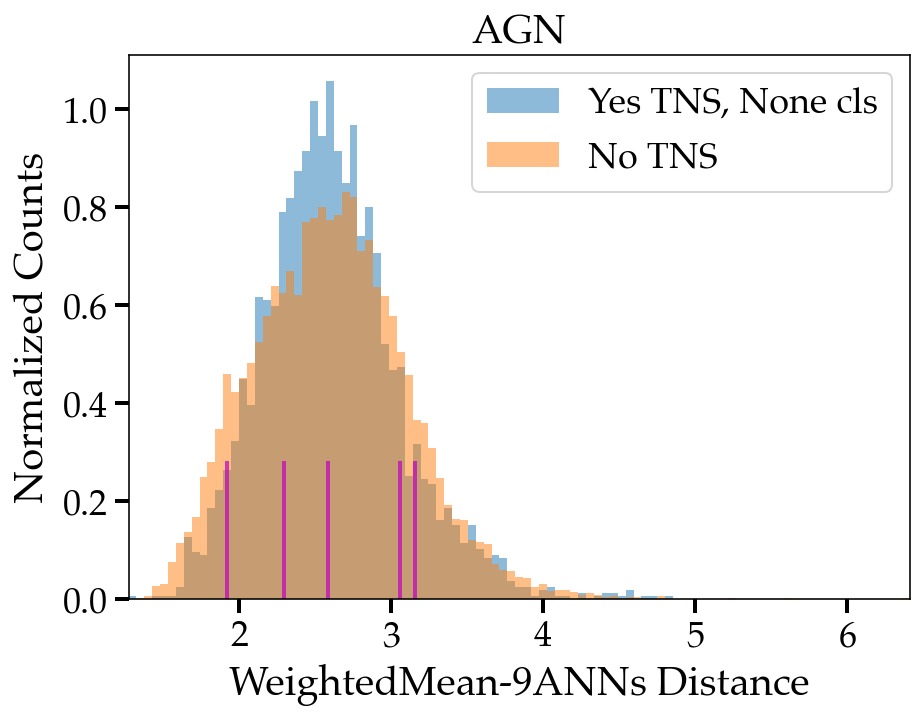

CV
Mean 3.5850593050320945
https://alerce.online/object/ZTF20abakrcq
https://alerce.online/object/ZTF21aaspdzb
https://alerce.online/object/ZTF21abmemav


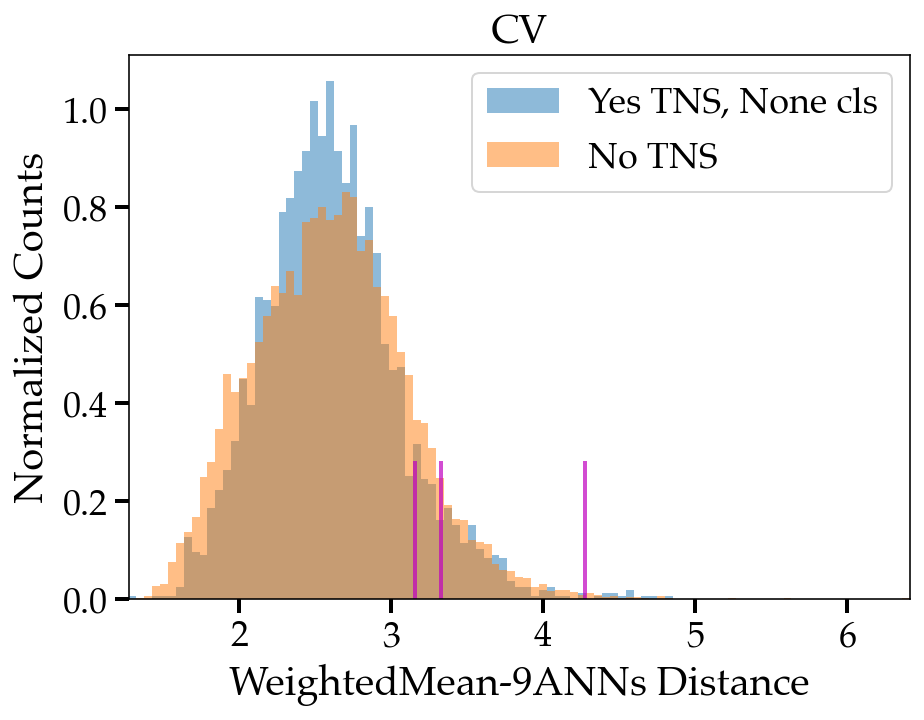

None
Mean 2.6054222858456386


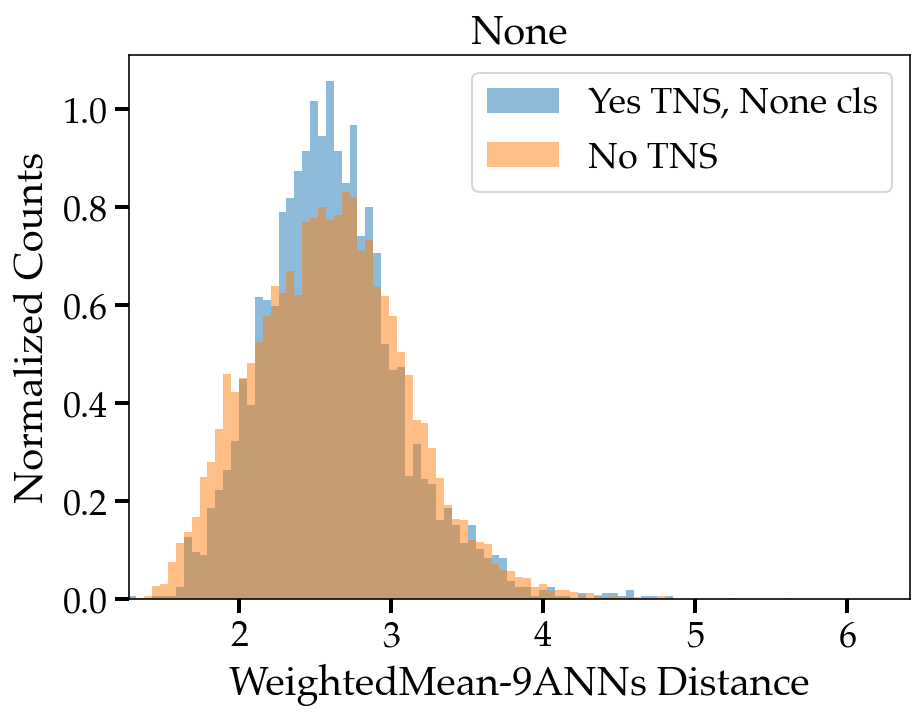

Nova
Mean 2.701996238845767
https://alerce.online/object/ZTF20acfucwr
https://alerce.online/object/ZTF20acgigfo
https://alerce.online/object/ZTF20acplkub


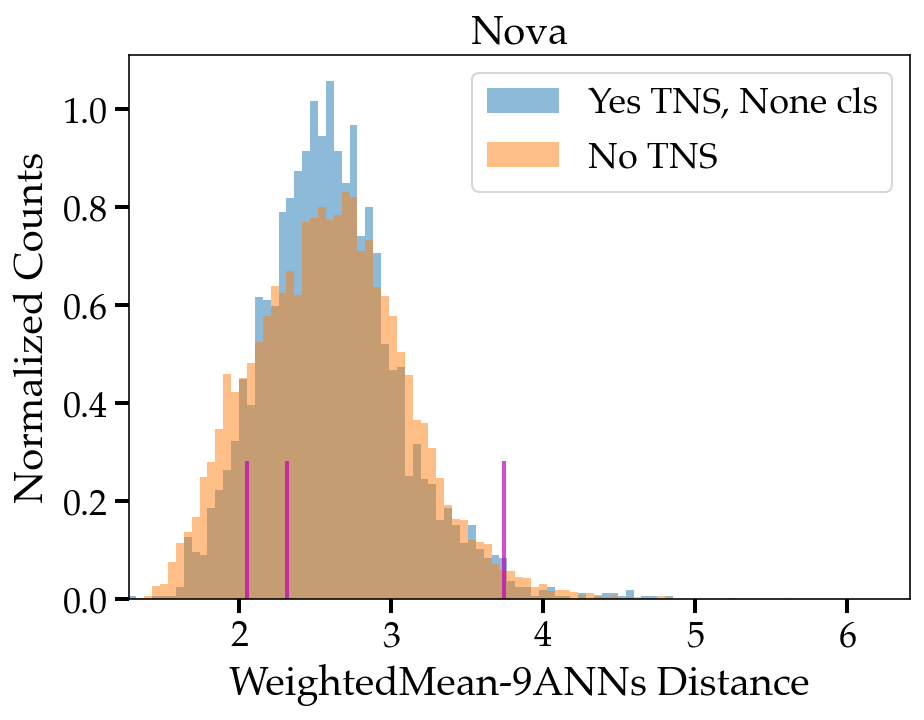

Other
Mean 2.681324479932135
https://alerce.online/object/ZTF20aclkdlu
https://alerce.online/object/ZTF21aabpvvx
https://alerce.online/object/ZTF21abjciua
https://alerce.online/object/ZTF21acbfuwk


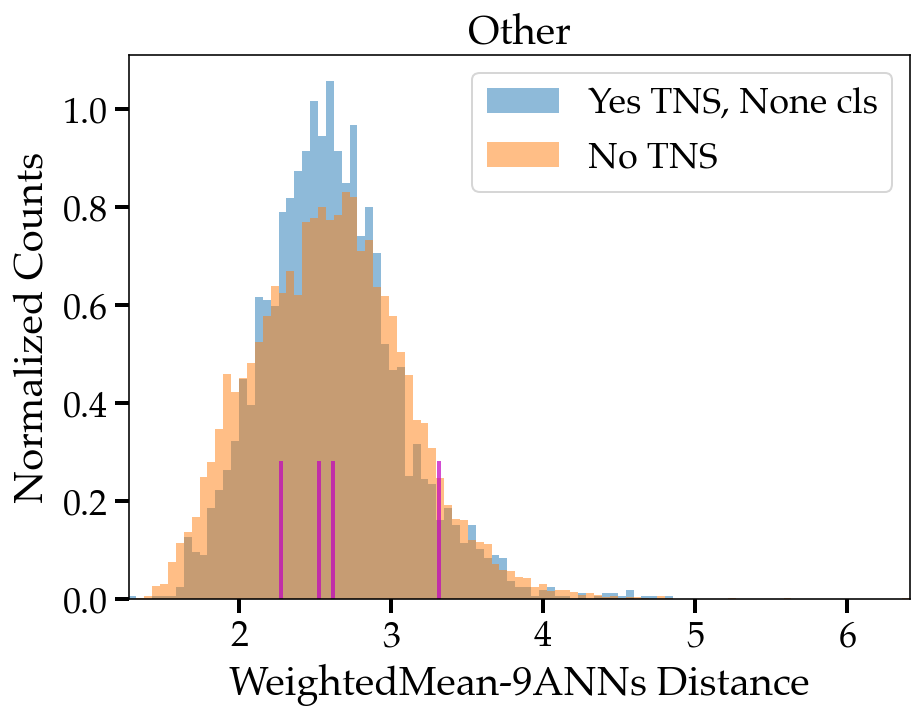

SLSN-I
Mean 2.4679331077770756
https://alerce.online/object/ZTF20acilzkh
https://alerce.online/object/ZTF21aaarmti
https://alerce.online/object/ZTF21abaiono
https://alerce.online/object/ZTF21abcpsjy
https://alerce.online/object/ZTF21abezyhr


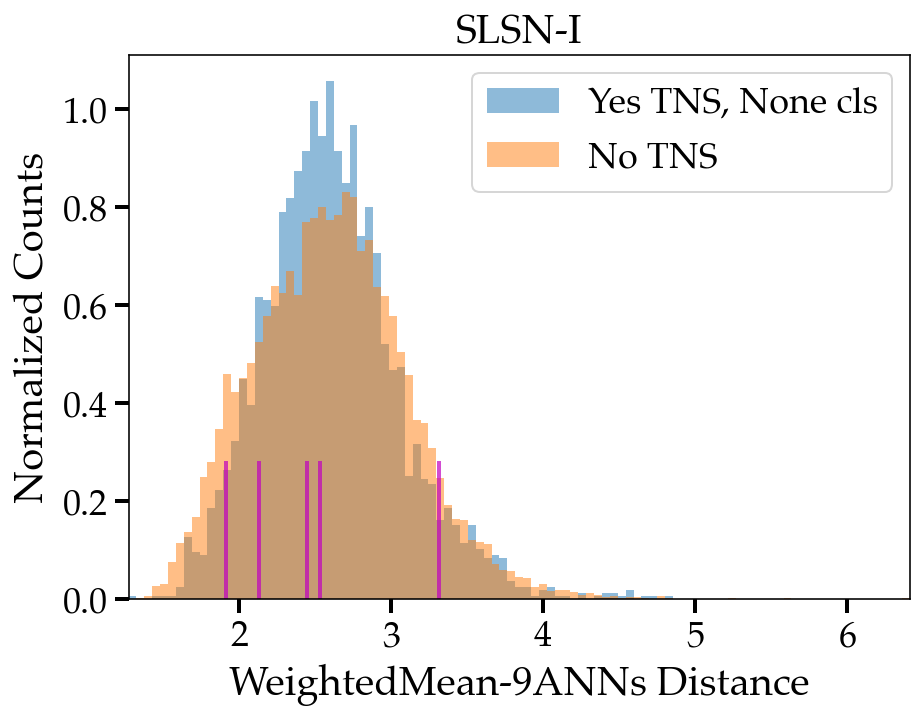

SLSN-II
Mean 2.1374637190397685
https://alerce.online/object/ZTF18abxbmqh
https://alerce.online/object/ZTF20aaurzyt
https://alerce.online/object/ZTF20achupkw
https://alerce.online/object/ZTF20aclnqle
https://alerce.online/object/ZTF20acnznms
https://alerce.online/object/ZTF21aanefkx
https://alerce.online/object/ZTF21aaokvio


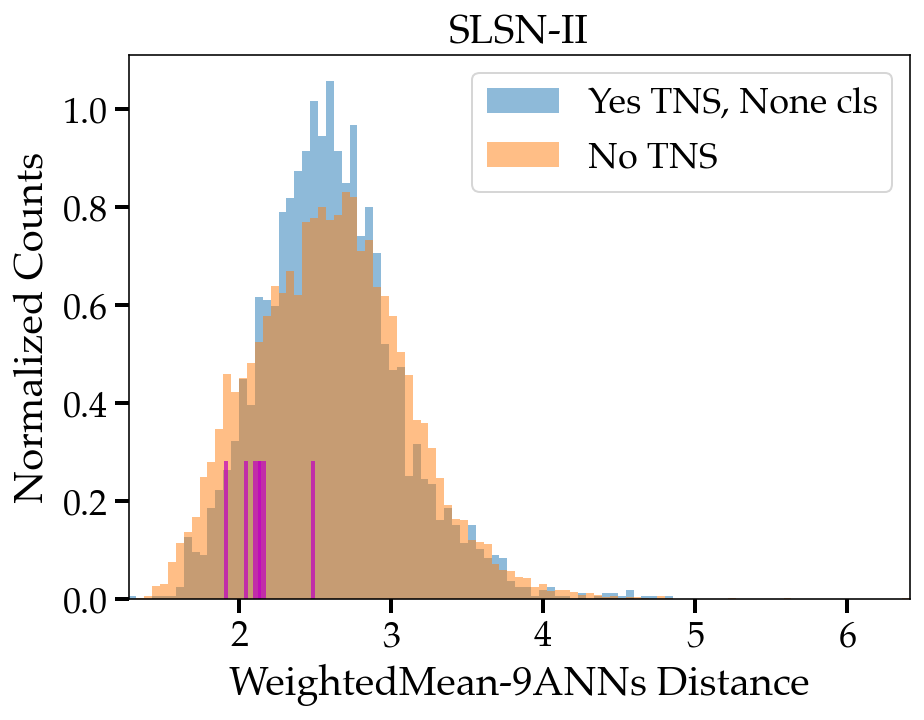

SN
Mean 2.8697650798342447
https://alerce.online/object/ZTF18abdqwzs
https://alerce.online/object/ZTF20achamic
https://alerce.online/object/ZTF20acvmzfv
https://alerce.online/object/ZTF21aaxthcj


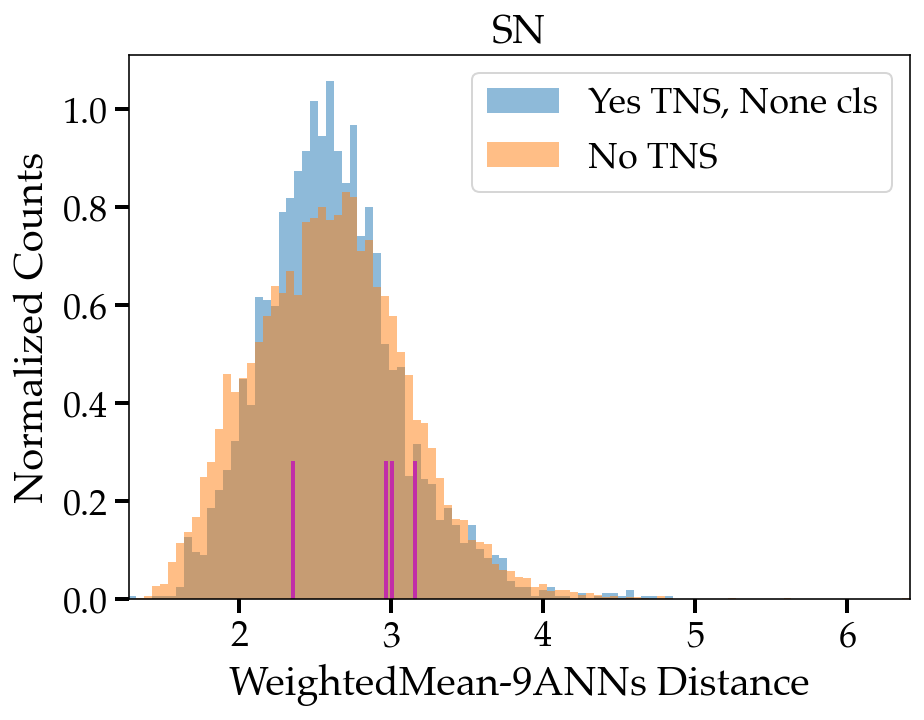

SN I
Mean 2.4696653802286495
https://alerce.online/object/ZTF20acrzuko
https://alerce.online/object/ZTF20acwuiuo
https://alerce.online/object/ZTF21aaaouyd
https://alerce.online/object/ZTF21aalhgqi
https://alerce.online/object/ZTF21aaqwfqe


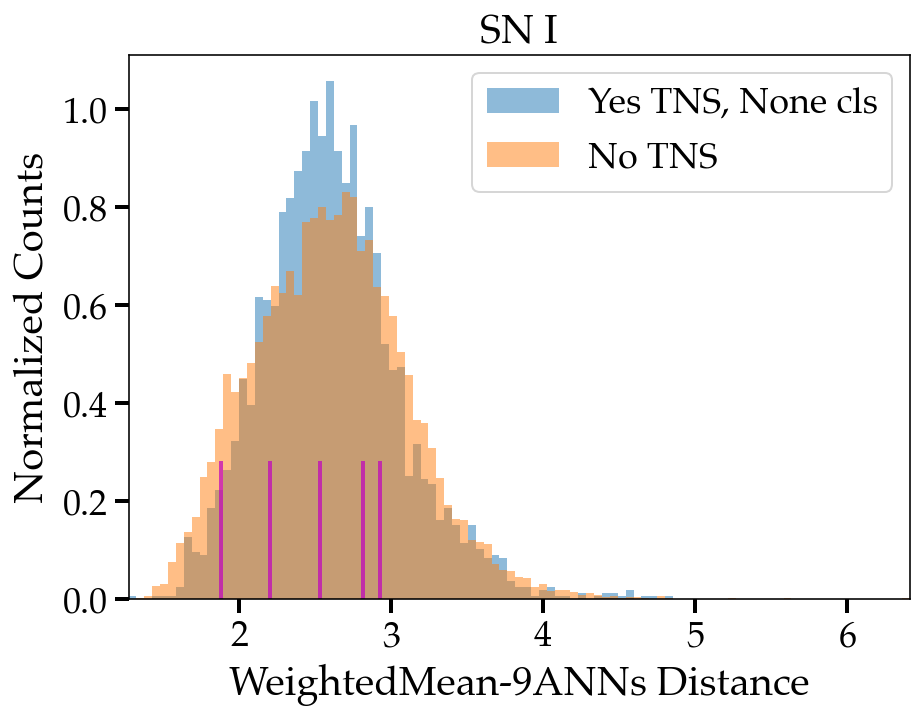

SN II
Mean 2.8407671143162423
https://alerce.online/object/ZTF18aacnlxz
https://alerce.online/object/ZTF18aaikcbb
https://alerce.online/object/ZTF18abaeqpf
https://alerce.online/object/ZTF18abqyvzy
https://alerce.online/object/ZTF18abufaej
https://alerce.online/object/ZTF18abvmlow
https://alerce.online/object/ZTF18abxqemv
https://alerce.online/object/ZTF18accngxc
https://alerce.online/object/ZTF18acebssa
https://alerce.online/object/ZTF18acploez
https://alerce.online/object/ZTF18acsyaye
https://alerce.online/object/ZTF18acszayr
https://alerce.online/object/ZTF18adbadic
https://alerce.online/object/ZTF18adbmbpa
https://alerce.online/object/ZTF19aaeuhgo
https://alerce.online/object/ZTF20abfehpe
https://alerce.online/object/ZTF20abjonjs
https://alerce.online/object/ZTF20abjyoty
https://alerce.online/object/ZTF20ablygyy
https://alerce.online/object/ZTF20abqferm
https://alerce.online/object/ZTF20abqlmwn
https://alerce.online/object/ZTF20abupxie
https://alerce.online/object/ZTF20abuqali
http

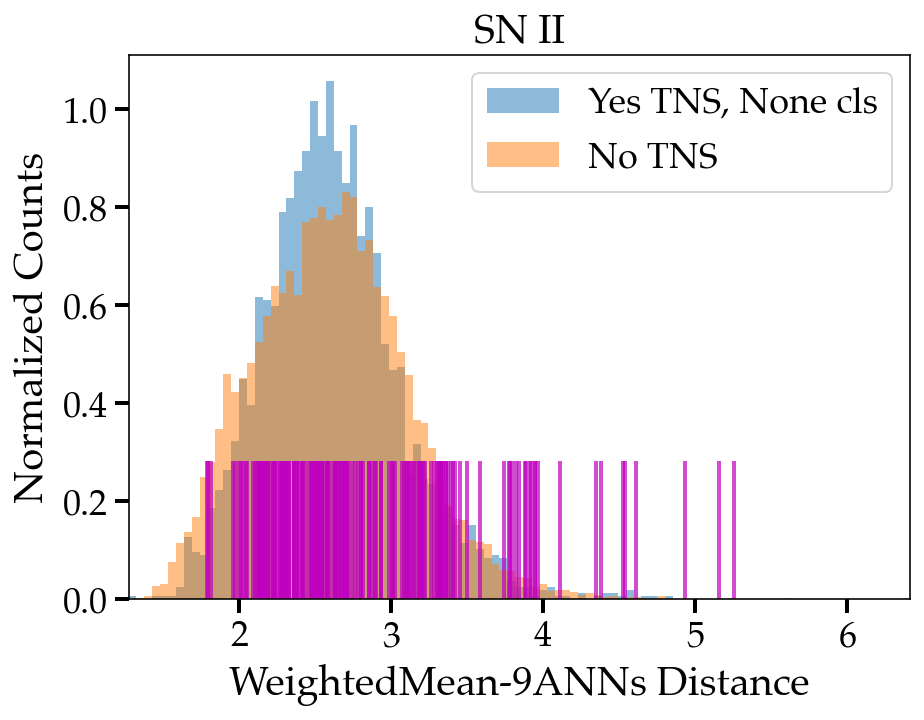

SN II-pec
Mean 2.392759956419468
https://alerce.online/object/ZTF20acvdfmw
https://alerce.online/object/ZTF21aaqyifh


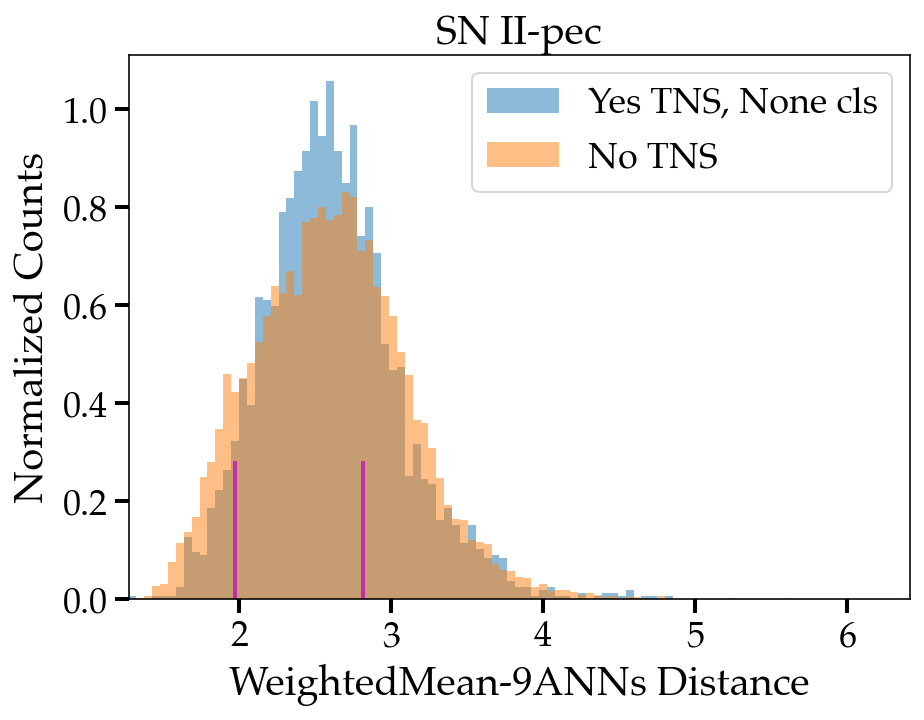

SN IIP
Mean 2.679078872155662
https://alerce.online/object/ZTF20abvyqia
https://alerce.online/object/ZTF20abwftit
https://alerce.online/object/ZTF20acnvtxy
https://alerce.online/object/ZTF20acptgfl
https://alerce.online/object/ZTF20acrinvz
https://alerce.online/object/ZTF20acwytht
https://alerce.online/object/ZTF21aaabwem
https://alerce.online/object/ZTF21aakvroo
https://alerce.online/object/ZTF21aarbhhp


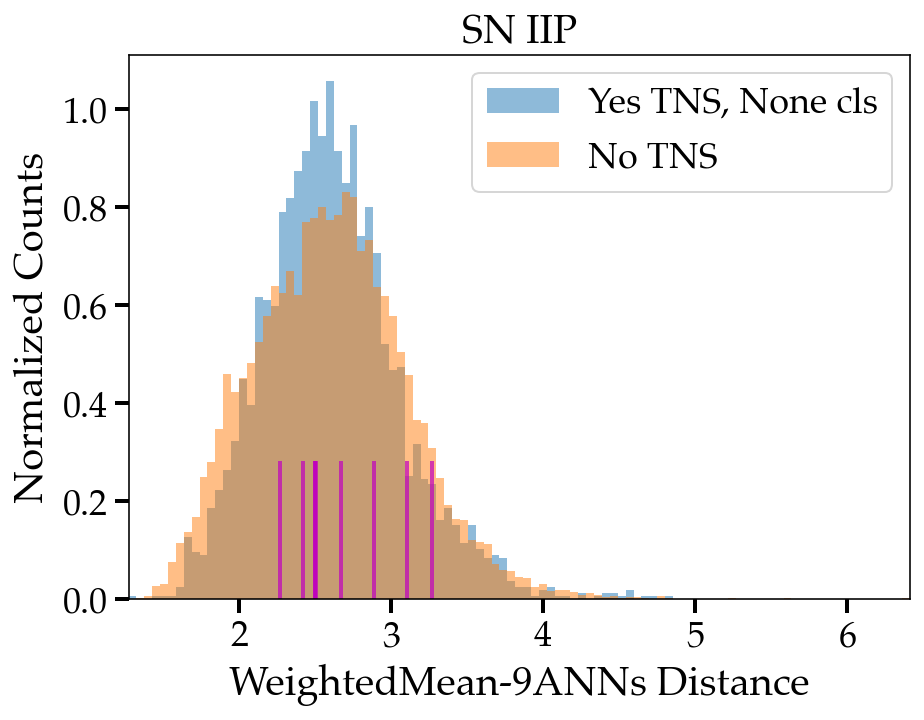

SN IIb
Mean 2.9462510047649793
https://alerce.online/object/ZTF20abwzqzo
https://alerce.online/object/ZTF20acgiglu
https://alerce.online/object/ZTF20acjpvyd
https://alerce.online/object/ZTF20acusecr
https://alerce.online/object/ZTF20acwqqjs
https://alerce.online/object/ZTF21aaabrpu
https://alerce.online/object/ZTF21aaabwfu
https://alerce.online/object/ZTF21aabxjqr
https://alerce.online/object/ZTF21aalimya
https://alerce.online/object/ZTF21aanrhag
https://alerce.online/object/ZTF21aarasky
https://alerce.online/object/ZTF21aaxxmvs
https://alerce.online/object/ZTF21aayfnjz
https://alerce.online/object/ZTF21abfjlxb
https://alerce.online/object/ZTF21abmxkcq
https://alerce.online/object/ZTF21abotose


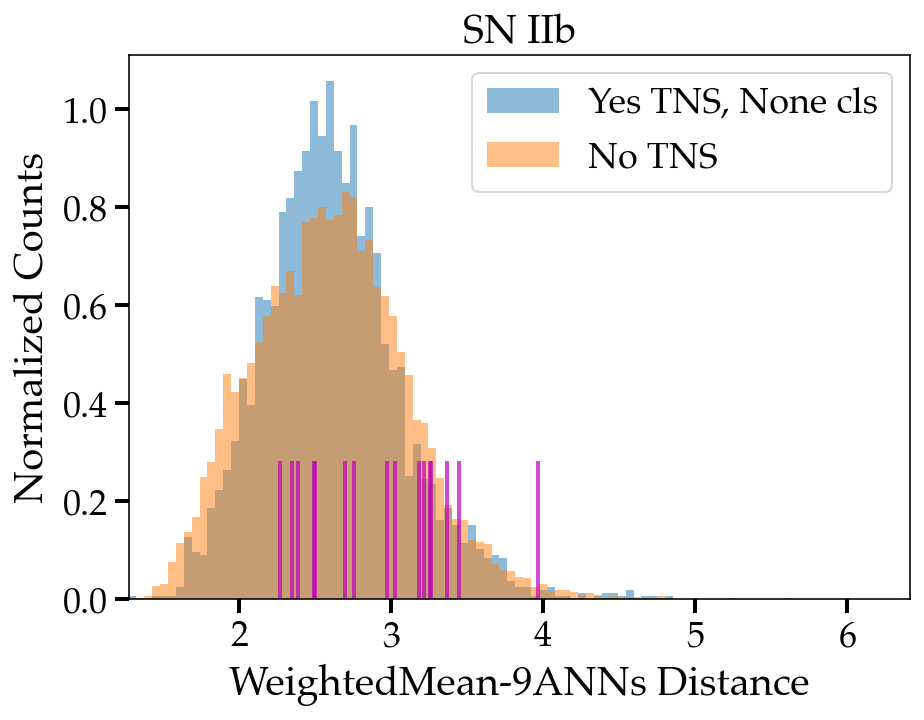

SN IIn
Mean 2.913395434898269
https://alerce.online/object/ZTF18acnnfty
https://alerce.online/object/ZTF18acvgjqv
https://alerce.online/object/ZTF18acwzyor
https://alerce.online/object/ZTF19aadoota
https://alerce.online/object/ZTF19abstsvm
https://alerce.online/object/ZTF20aabcemq
https://alerce.online/object/ZTF20aaurfwa
https://alerce.online/object/ZTF20abpmqnr
https://alerce.online/object/ZTF20abtjjhb
https://alerce.online/object/ZTF20abyxjvm
https://alerce.online/object/ZTF20abzhvnj
https://alerce.online/object/ZTF20aceokvr
https://alerce.online/object/ZTF20acggqfs
https://alerce.online/object/ZTF20acisvli
https://alerce.online/object/ZTF20acounxo
https://alerce.online/object/ZTF20actkulc
https://alerce.online/object/ZTF20acwobku
https://alerce.online/object/ZTF21aaffxdt
https://alerce.online/object/ZTF21aahfjrr
https://alerce.online/object/ZTF21aaoqbbw
https://alerce.online/object/ZTF21aappkns
https://alerce.online/object/ZTF21aaradzm
https://alerce.online/object/ZTF21aautijg
http

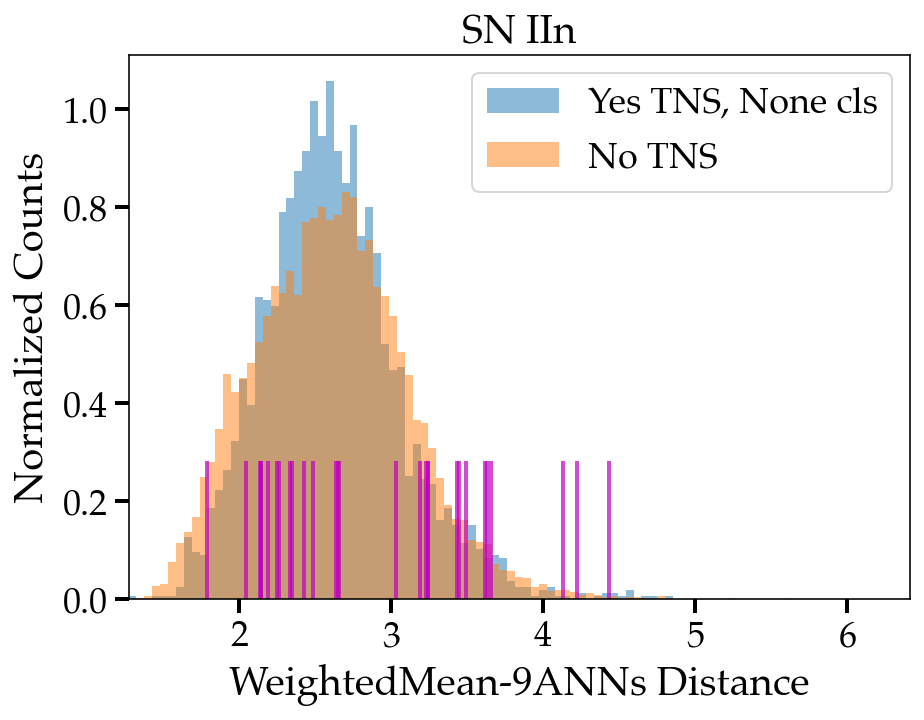

SN Ia
Mean 2.4386798165207826
https://alerce.online/object/ZTF18aaacqmh
https://alerce.online/object/ZTF18aabeszt
https://alerce.online/object/ZTF18aadlaxo
https://alerce.online/object/ZTF18aagtwyh
https://alerce.online/object/ZTF18aahfbqp
https://alerce.online/object/ZTF18aaisqmw
https://alerce.online/object/ZTF18aaizgoq
https://alerce.online/object/ZTF18aajjhkq
https://alerce.online/object/ZTF18aamzgzi
https://alerce.online/object/ZTF18aansqom
https://alerce.online/object/ZTF18aansqov
https://alerce.online/object/ZTF18aaoxrup
https://alerce.online/object/ZTF18aasdwcj
https://alerce.online/object/ZTF18aatgdph
https://alerce.online/object/ZTF18aatrkga
https://alerce.online/object/ZTF18aauvmnq
https://alerce.online/object/ZTF18aawfofp
https://alerce.online/object/ZTF18aayyqia
https://alerce.online/object/ZTF18aazijke
https://alerce.online/object/ZTF18ablmduj
https://alerce.online/object/ZTF18abolvsx
https://alerce.online/object/ZTF18abquxjv
https://alerce.online/object/ZTF18abrbywo
http

https://alerce.online/object/ZTF21aalnyny
https://alerce.online/object/ZTF21aaloalc
https://alerce.online/object/ZTF21aaluoym
https://alerce.online/object/ZTF21aalxpnl
https://alerce.online/object/ZTF21aalxurs
https://alerce.online/object/ZTF21aalydkl
https://alerce.online/object/ZTF21aalyvyw
https://alerce.online/object/ZTF21aamesud
https://alerce.online/object/ZTF21aamfcji
https://alerce.online/object/ZTF21aamgcrv
https://alerce.online/object/ZTF21aamgrtx
https://alerce.online/object/ZTF21aamiukc
https://alerce.online/object/ZTF21aamjgfp
https://alerce.online/object/ZTF21aamkxbl
https://alerce.online/object/ZTF21aamokak
https://alerce.online/object/ZTF21aamttit
https://alerce.online/object/ZTF21aamwzfi
https://alerce.online/object/ZTF21aantxma
https://alerce.online/object/ZTF21aanwfjk
https://alerce.online/object/ZTF21aanyfqu
https://alerce.online/object/ZTF21aanyyde
https://alerce.online/object/ZTF21aaocibg
https://alerce.online/object/ZTF21aaodljj
https://alerce.online/object/ZTF21

https://alerce.online/object/ZTF21achauvx
https://alerce.online/object/ZTF21acipbwd
https://alerce.online/object/ZTF21ackbbfs
https://alerce.online/object/ZTF21ackhddc
https://alerce.online/object/ZTF21acldmwy


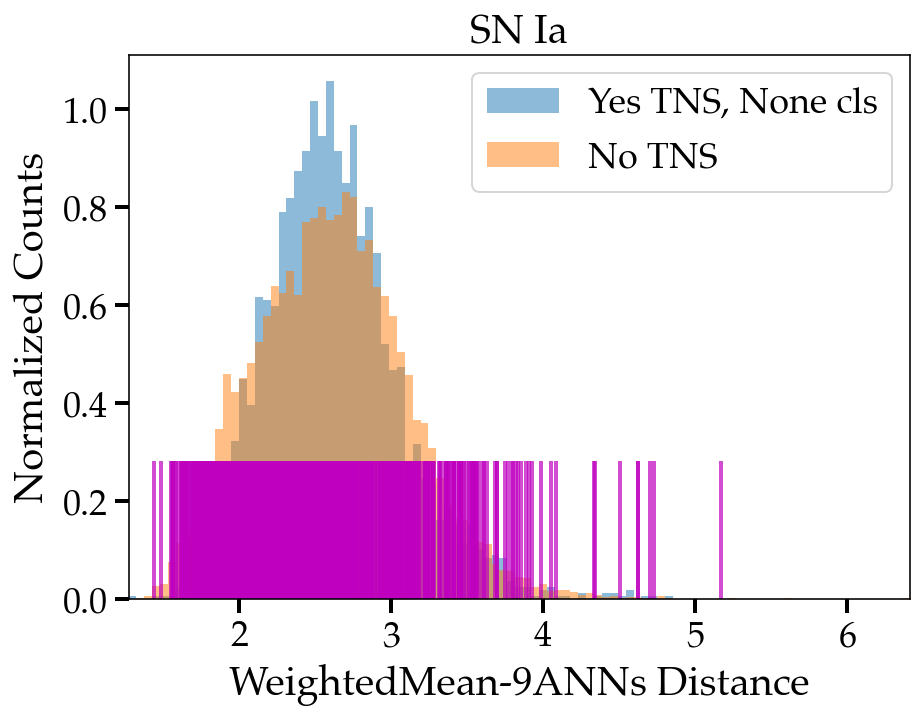

SN Ia-91T-like
Mean 2.4565060601290623
https://alerce.online/object/ZTF18aarindm
https://alerce.online/object/ZTF20acbttnt
https://alerce.online/object/ZTF20achrklb
https://alerce.online/object/ZTF20achuvhd
https://alerce.online/object/ZTF20acjdhof
https://alerce.online/object/ZTF20acobxlz
https://alerce.online/object/ZTF20acpwjus
https://alerce.online/object/ZTF20acvbvyb
https://alerce.online/object/ZTF20acwnrty
https://alerce.online/object/ZTF20aczgoml
https://alerce.online/object/ZTF21aaafjad
https://alerce.online/object/ZTF21aaafrnh
https://alerce.online/object/ZTF21aaahliy
https://alerce.online/object/ZTF21aaahyjj
https://alerce.online/object/ZTF21aagnvvk
https://alerce.online/object/ZTF21aagpbkj
https://alerce.online/object/ZTF21aagxmfv
https://alerce.online/object/ZTF21aajtsba
https://alerce.online/object/ZTF21aamucom
https://alerce.online/object/ZTF21aanrvcq
https://alerce.online/object/ZTF21aapvxnf
https://alerce.online/object/ZTF21aarycyl
https://alerce.online/object/ZTF21aat

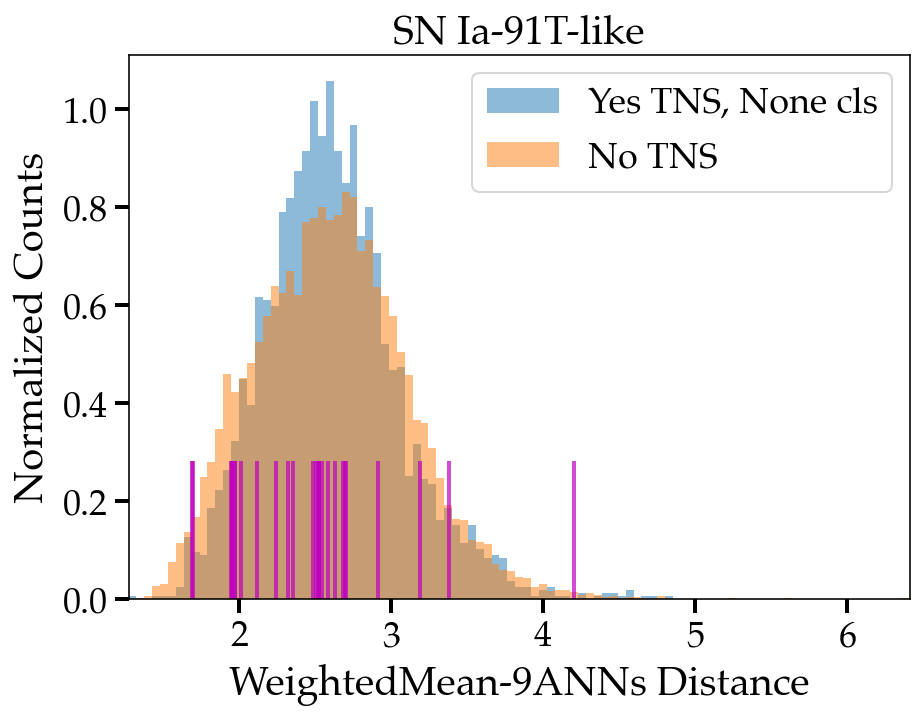

SN Ia-91bg-like
Mean 2.672397447806416
https://alerce.online/object/ZTF19aaafica
https://alerce.online/object/ZTF20acgkuay
https://alerce.online/object/ZTF20acvbrbv
https://alerce.online/object/ZTF21aapjmda
https://alerce.online/object/ZTF21aawihwx
https://alerce.online/object/ZTF21abulrsl


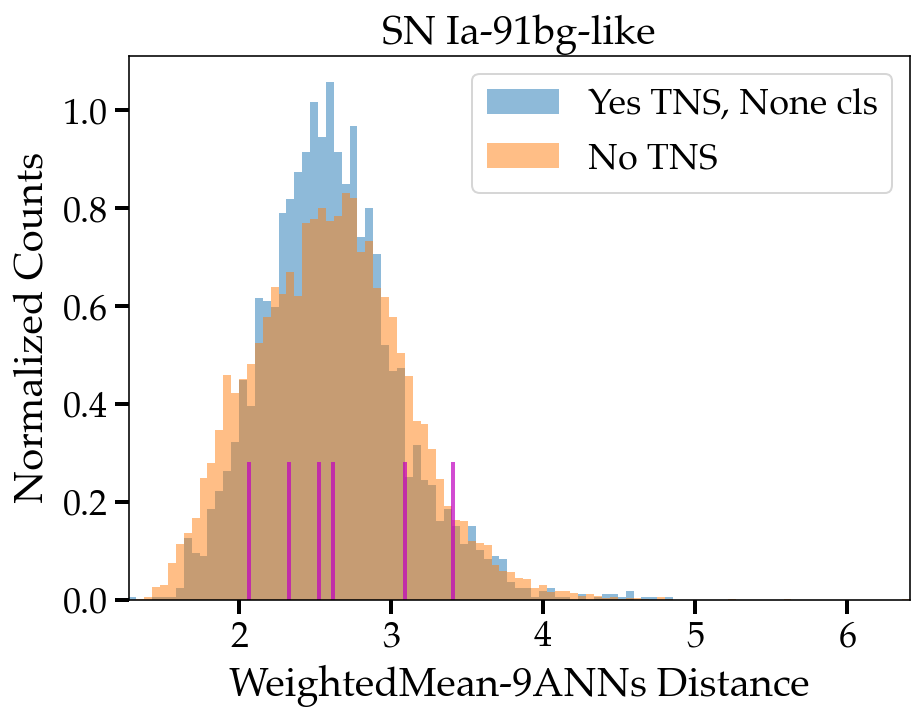

SN Ia-CSM
Mean 2.931128857713757
https://alerce.online/object/ZTF20abbbsfs
https://alerce.online/object/ZTF20abmlxrx
https://alerce.online/object/ZTF20abqkbfx


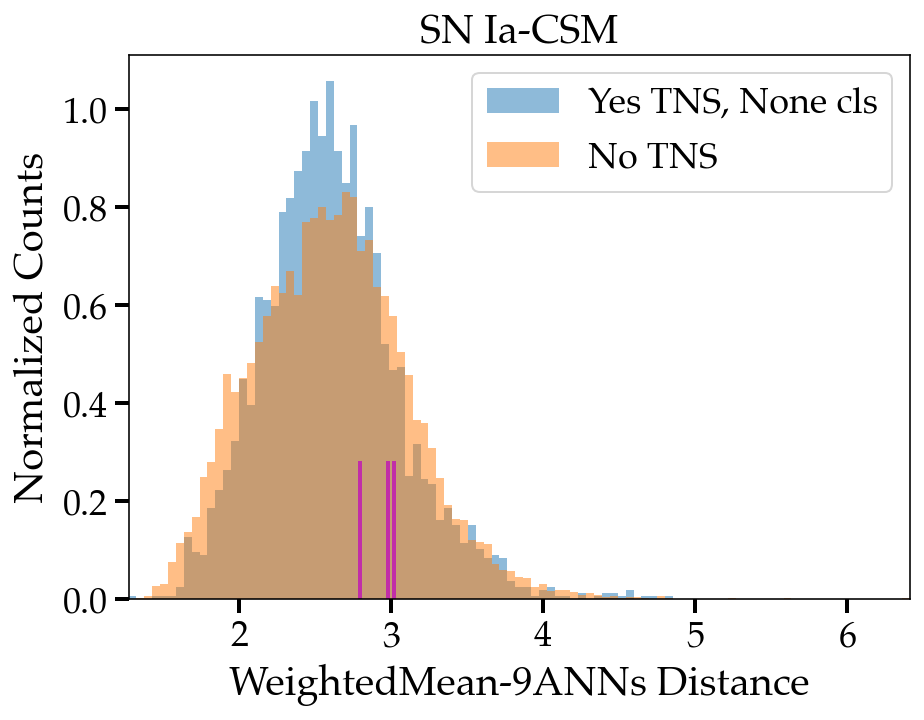

SN Ia-pec
Mean 2.6136186942458153
https://alerce.online/object/ZTF18aafzers
https://alerce.online/object/ZTF18acslknd
https://alerce.online/object/ZTF21aahfjbs
https://alerce.online/object/ZTF21aamgrxm
https://alerce.online/object/ZTF21aarenhl
https://alerce.online/object/ZTF21abfyxpf


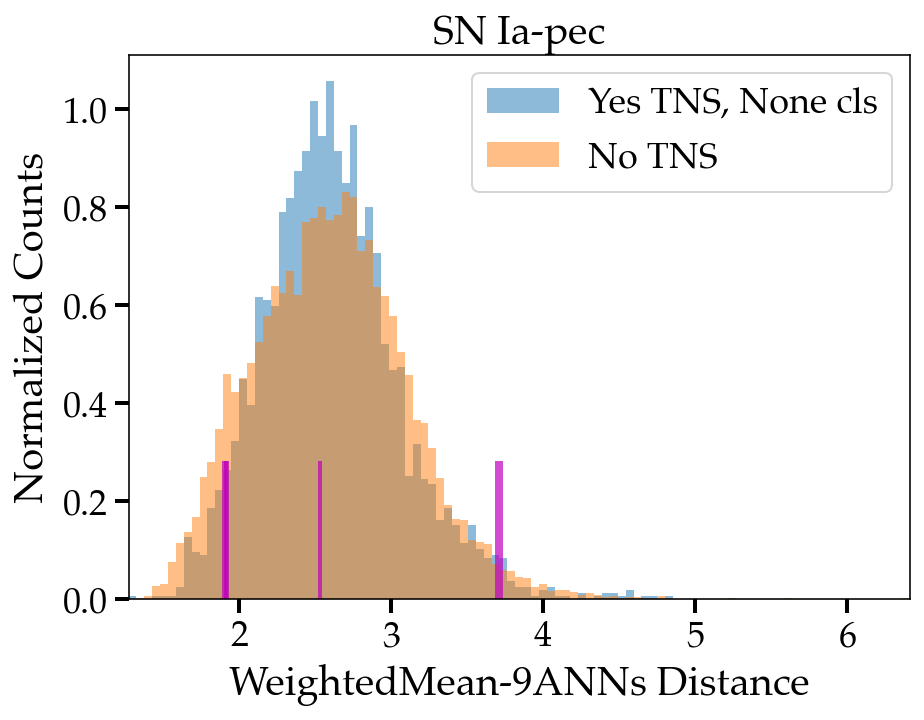

SN Iax[02cx-like]
Mean 2.5688289444554937
https://alerce.online/object/ZTF20abwrcmq
https://alerce.online/object/ZTF21aagqdvr
https://alerce.online/object/ZTF21aavotzn
https://alerce.online/object/ZTF21abbyhvw


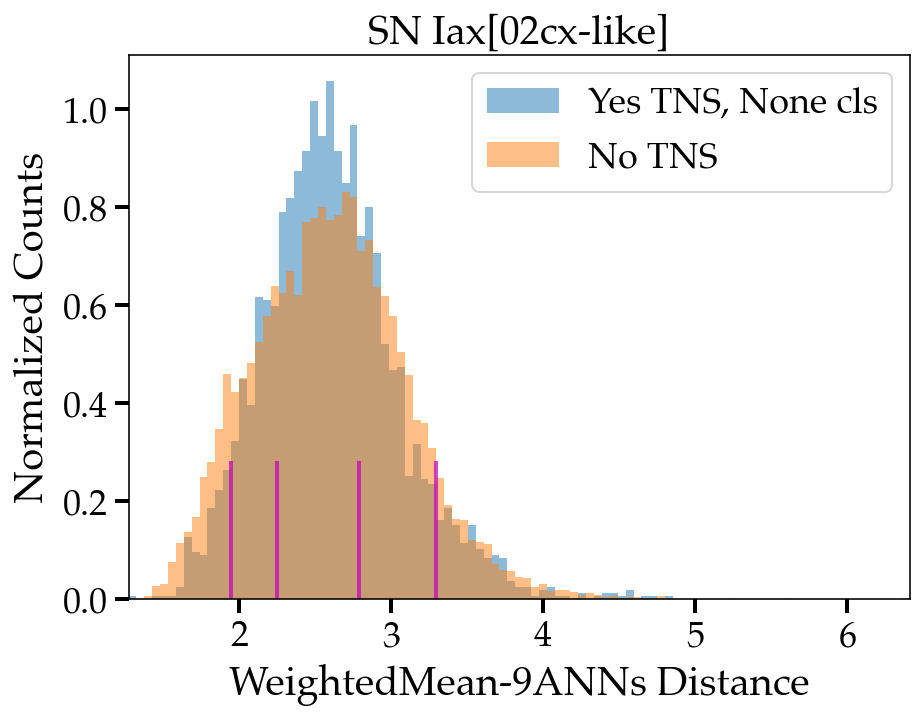

SN Ib
Mean 2.701036046533023
https://alerce.online/object/ZTF18abvkmgw
https://alerce.online/object/ZTF18acnncve
https://alerce.online/object/ZTF20abvquuo
https://alerce.online/object/ZTF20acpjodk
https://alerce.online/object/ZTF20acpzaoa
https://alerce.online/object/ZTF20acqvwzm
https://alerce.online/object/ZTF20acxqxyw
https://alerce.online/object/ZTF21aaaroyw
https://alerce.online/object/ZTF21aaqhhfu
https://alerce.online/object/ZTF21aarnjyd
https://alerce.online/object/ZTF21aaufwyh
https://alerce.online/object/ZTF21aawogdl
https://alerce.online/object/ZTF21aayddkn
https://alerce.online/object/ZTF21aayqrgx
https://alerce.online/object/ZTF21abcgnql
https://alerce.online/object/ZTF21abdkojo
https://alerce.online/object/ZTF21abieuta


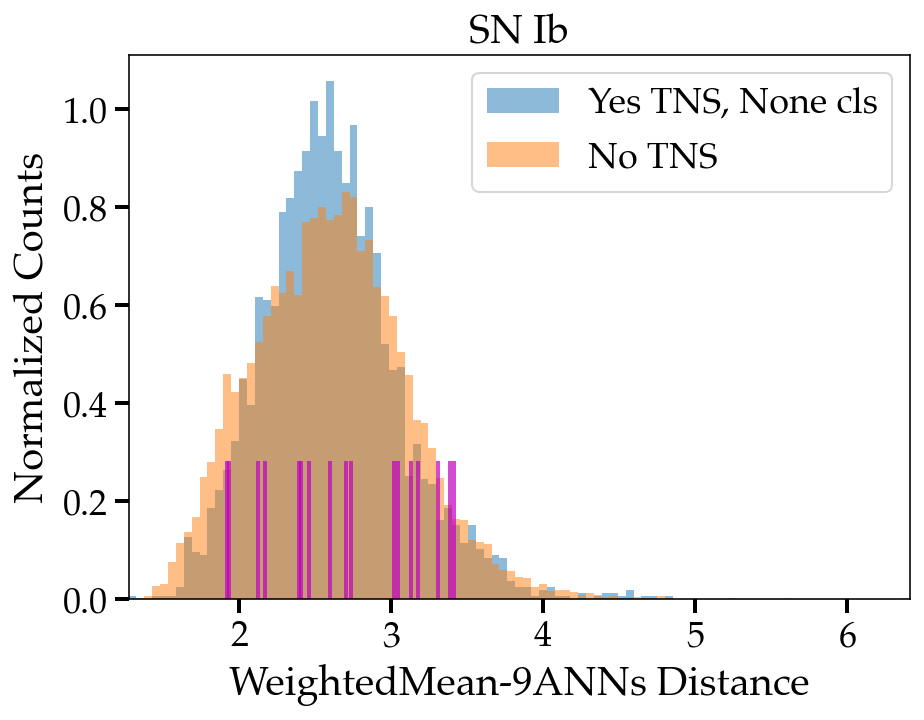

SN Ib-pec
Mean 3.3883215243166145
https://alerce.online/object/ZTF20acpjqxp
https://alerce.online/object/ZTF21aasuego


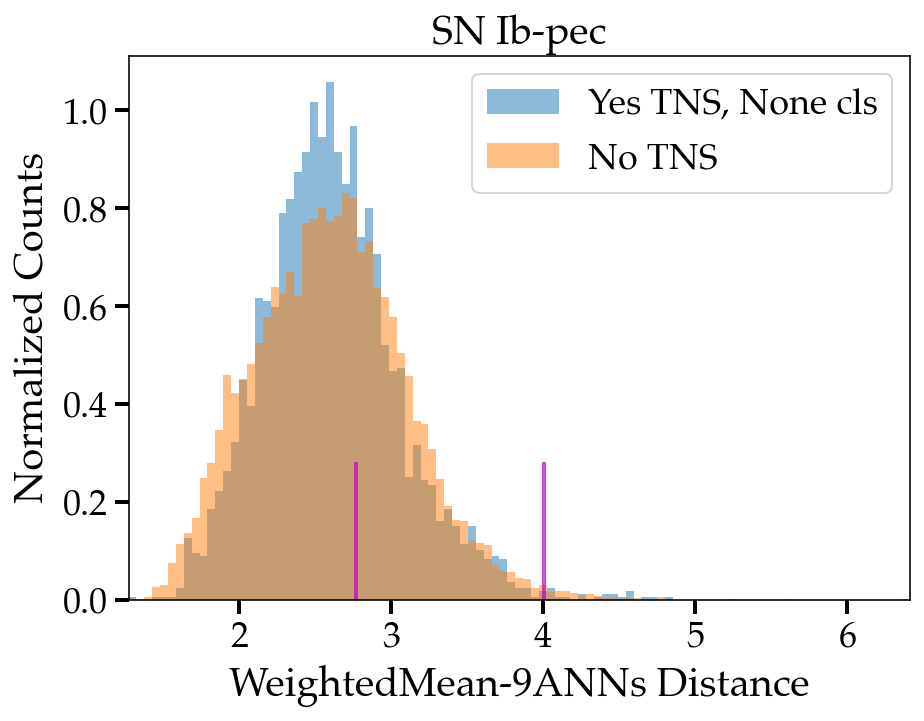

SN Ib/c
Mean 2.85887676206502
https://alerce.online/object/ZTF21aaabzdr
https://alerce.online/object/ZTF21aabyifm
https://alerce.online/object/ZTF21abdxhgv


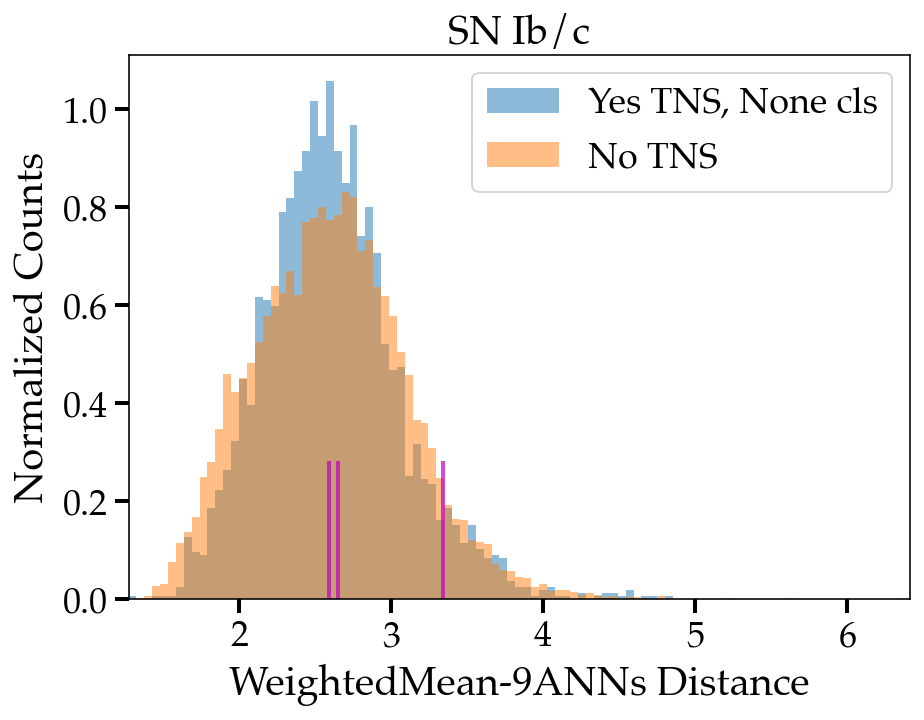

SN Ibn
Mean 2.7666314772584224
https://alerce.online/object/ZTF21aagyidr
https://alerce.online/object/ZTF21aalkltz
https://alerce.online/object/ZTF21aapdumx
https://alerce.online/object/ZTF21aauvmck


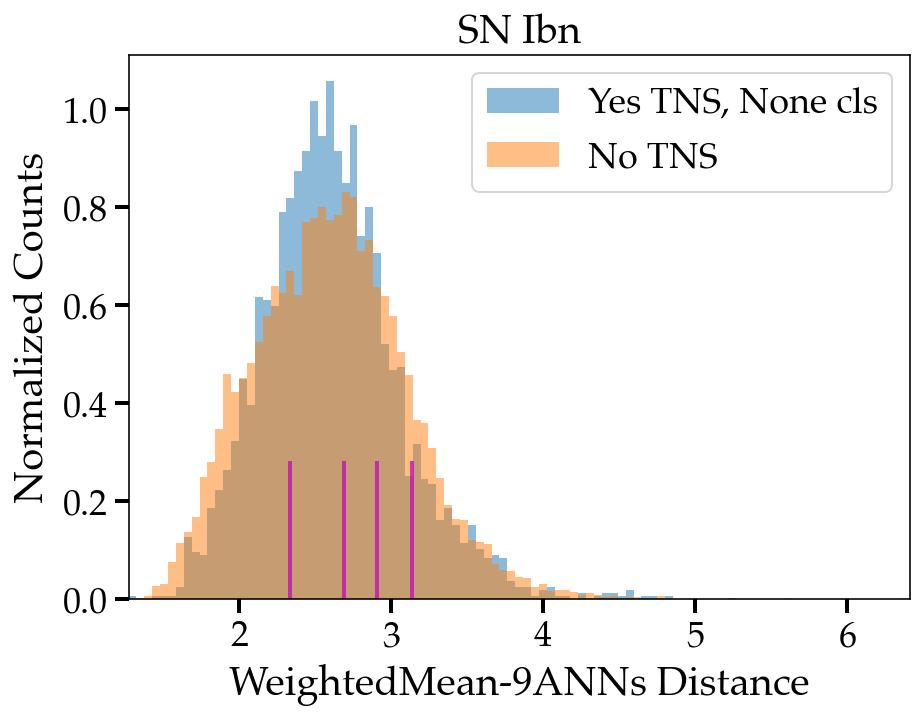

SN Ic
Mean 2.8089918479172864
https://alerce.online/object/ZTF19aafmyow
https://alerce.online/object/ZTF19aaxzdtw
https://alerce.online/object/ZTF20abwxywy
https://alerce.online/object/ZTF20abxyaaf
https://alerce.online/object/ZTF20abzjcdg
https://alerce.online/object/ZTF20accoccp
https://alerce.online/object/ZTF20aclnplo
https://alerce.online/object/ZTF20actekrw
https://alerce.online/object/ZTF20actpqgc
https://alerce.online/object/ZTF20acueziy
https://alerce.online/object/ZTF20acuxjus
https://alerce.online/object/ZTF20adadrhw
https://alerce.online/object/ZTF21aacufip
https://alerce.online/object/ZTF21aannoix
https://alerce.online/object/ZTF21aaqldsk
https://alerce.online/object/ZTF21aaygqkb
https://alerce.online/object/ZTF21abklcjq
https://alerce.online/object/ZTF21abltdts


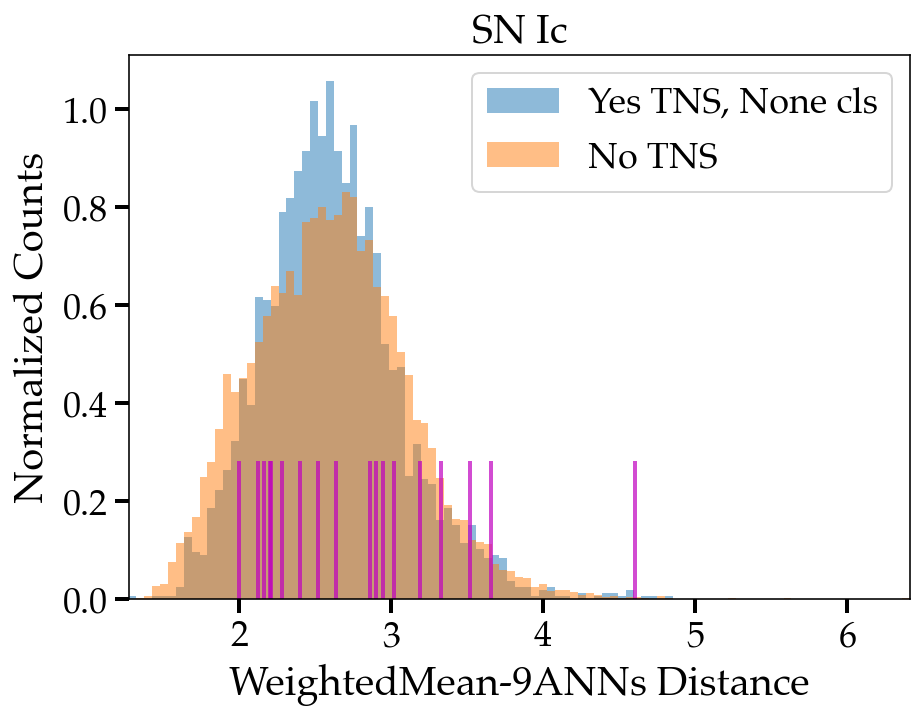

SN Ic-BL
Mean 2.8895789947774677
https://alerce.online/object/ZTF18acpeekw
https://alerce.online/object/ZTF20abcjdwu
https://alerce.online/object/ZTF21aadatfg
https://alerce.online/object/ZTF21aardvol
https://alerce.online/object/ZTF21aartgiv
https://alerce.online/object/ZTF21abchjer
https://alerce.online/object/ZTF21abeafwt
https://alerce.online/object/ZTF21acekmmm
https://alerce.online/object/ZTF21aciuhqw


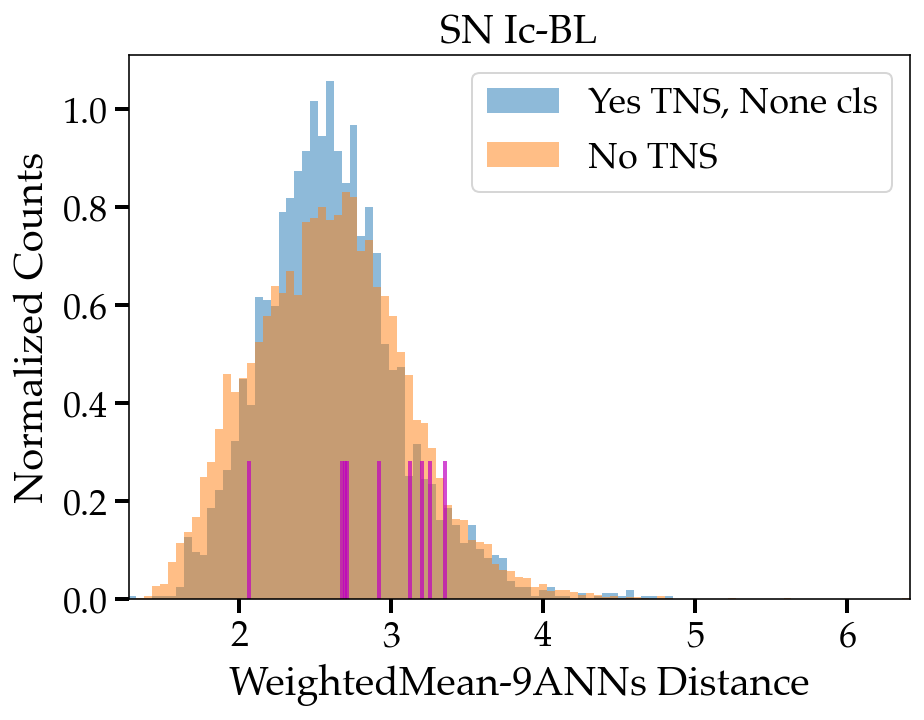

SN Icn
Mean 2.5227907679297705
https://alerce.online/object/ZTF21aakilyd


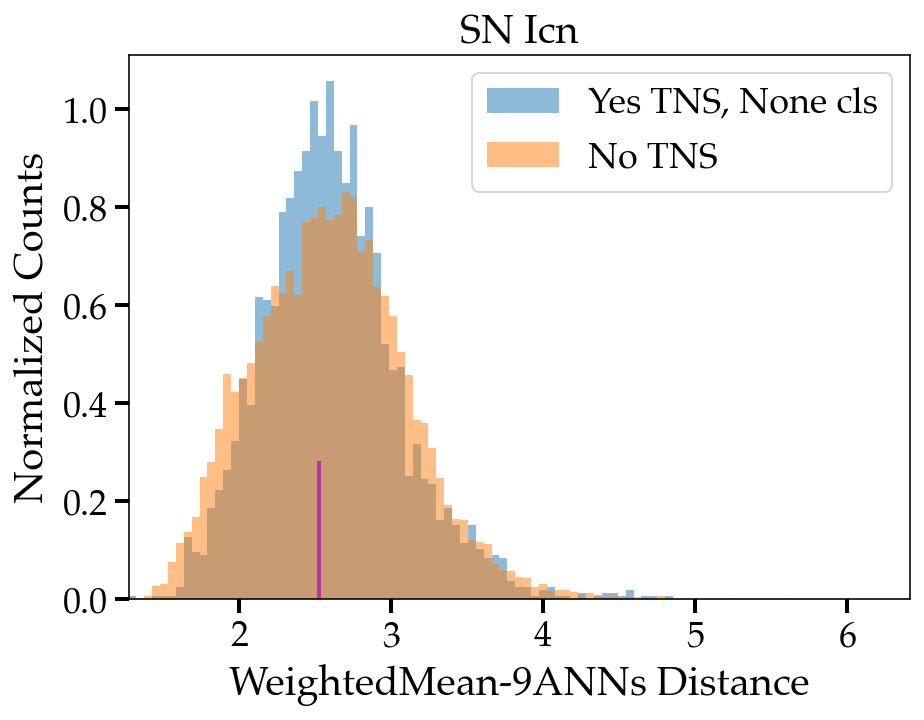

TDE
Mean 2.645428971660258
https://alerce.online/object/ZTF17aaazdba
https://alerce.online/object/ZTF18abxftqm
https://alerce.online/object/ZTF18acaqdaa
https://alerce.online/object/ZTF20acitpfz
https://alerce.online/object/ZTF20acqoiyt
https://alerce.online/object/ZTF20acyydkh
https://alerce.online/object/ZTF21aaaokyp
https://alerce.online/object/ZTF21aabiipy
https://alerce.online/object/ZTF21aapvvtb


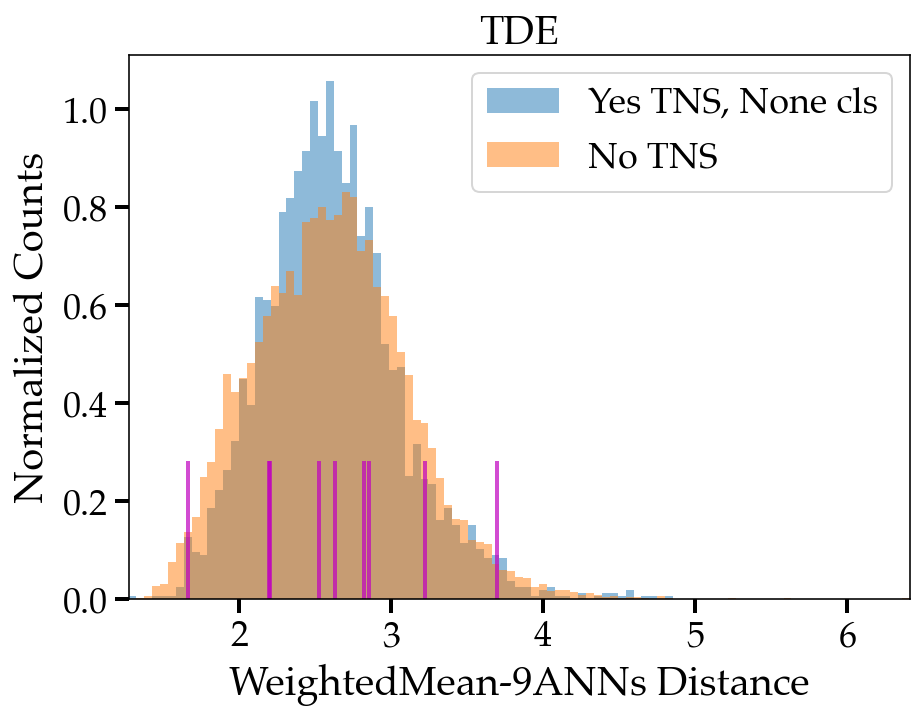

In [182]:
# for cls in np.unique(ann_dist_all_tns_df.tns_cls):
    
#     print(cls)
    
    
cls_scatter_l = []
for cls in np.unique(ann_dist_all_tns_df.tns_cls):
    print(cls)
    fig, ax = plt.subplots()
    
    min_feat, max_feat = np.min(ann_dist_all_tns_df['WeightedMean-9ANNs']), np.max(ann_dist_all_tns_df['WeightedMean-9ANNs'])
    
    # Submitted to TNS, no class
    yes_tns_df = ann_dist_all_tns_df[ann_dist_all_tns_df['has_tns'] == 'Yes_TNS']
    # Not submitted to TNS
    no_tns_df = ann_dist_all_tns_df[ann_dist_all_tns_df['has_tns'] == 'No_TNS']
    
    cls_df = ann_dist_all_tns_df[ann_dist_all_tns_df.tns_cls == cls]['WeightedMean-9ANNs']
    
    yes_tns_none_cls_df = yes_tns_df[yes_tns_df.tns_cls == "None"]['WeightedMean-9ANNs']
    no_tns_none_cls_df = no_tns_df[no_tns_df.tns_cls == "None"]['WeightedMean-9ANNs']
    
    
    #ax.hist(cls_df, bins=np.linspace(min_feat, max_feat, 100))
    ax.hist(yes_tns_none_cls_df, bins=np.linspace(min_feat, max_feat, 100), alpha=0.5, density=True,
            label="Yes TNS, None cls")
    ax.hist(no_tns_none_cls_df, bins=np.linspace(min_feat, max_feat, 100), alpha=0.5, density=True,
            label="No TNS")
    
    print("Mean", np.mean(cls_df))
    
    #ref = dataset_bank[dataset_bank.index == ref_obj]
    #print(cls_df)
    if cls != "None":
        for ix, v in enumerate(cls_df):
            ax.axvline(v, color='m', alpha=0.7, ymin=0, ymax=0.25)
            #if v <= 0.6: #np.mean(cls_df):
            print(f'https://alerce.online/object/{cls_df.index[ix]}') # greater than mean
            
    ax.set_title(cls)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend()
    
    plt.ylabel('Normalized Counts')
    plt.xlabel('WeightedMean-9ANNs Distance')
    plt.show()
    
    cls_scatter = np.std(cls_df)
    cls_scatter_l.append(cls_scatter) 

# Rare class not always high distance away... wonder if it will be fixed with stars removed
# rare class with high 9ann dist usually is bright, at core, or those + half observed (e.g., no rise)

In [183]:
tns_none_cls_df = ann_dist_all_tns_df[ann_dist_all_tns_df.tns_cls == 'None']

tns_none_cls_w9anng1_df = tns_none_cls_df[(tns_none_cls_df['WeightedMean-9ANNs'] >= 1) & (tns_none_cls_df['has_tns'] == "No_TNS")]
tns_none_cls_w9anng1_df

ann=0  ann=1  ann=2  ann=3  ann=4  ann=5  ann=6  ann=7  ann=8  \
ZTF17aaaaenu  18790   6649  13209  14428   8815   8988   7697  11811   6230   
ZTF17aaaazhi  16293  11694    900   7680   5764   6680  16822  11784   1242   
ZTF17aaaazmz   9278  18392  10854   4196  13821   5253  13787  11383  10115   
ZTF17aaabghb   7729   8345  10679   2012  11735  16892   7521  18175  13702   
ZTF17aaabuab  13760  16799  12701  16398   6645   2745   5941   2455   6825   
...             ...    ...    ...    ...    ...    ...    ...    ...    ...   
ZTF21acnoayd  17976   2029  12681   5090    229  14761  10551   4427  13311   
ZTF21acogvaq   8545   4406   3097   5763   6583  13656   2777  10814   4807   
ZTF21acowflo   7527   7924  11086   9290   8220    347   9505   4445   1844   
ZTF21acqdfea   7777   1489   9363   8136   5053   8363   1731   9119  13863   
ZTF21acqnurt   8040   5704   3780   9349   8575  11187   4052   9634  17085   

              ann=9  ...    dist=6    dist=7    dist=8    dist=9  Mean-9ANNs  \
ZTF17aaaaenu  12358  ...  2.771687  2.970411  2.972721  2.976331    2.746712   
ZTF17aaaazhi    241  ...  3.361781  3.367687  3.408665  3.429598    3.174018   
ZTF17aaaazmz    400  ...  3.031959  3.066046  3.088347  3.099874    2.816637   
ZTF17aaabghb  10797  ...  2.571884  2.593932  2.629716  2.634124    2.446292   
ZTF17aaabuab   5730  ...  3.100569  3.149559  3.169443  3.223724    2.989983   
...             ...  ...       ...       ...       ...       ...         ...   
ZTF21acnoayd   4935  ...  3.121714  3.132214  3.135616  3.144395    2.962354   
ZTF21acogvaq   1928  ...  2.982801  2.991531  3.017424  3.065472    2.856268   
ZTF21acowflo   9522  ...  3.017590  3.025151  3.170483  3.203540    2.951771   
ZTF21acqdfea   2915  ...  2.438983  2.476552  2.497445  2.514253    2.385581   
ZTF21acqnurt   2586  ...  3.588788  3.692314  3.767519  3.807232    3.554279   

              WeightedMean-9ANNs  has_tns  tns_cls  spec_z  report_group  
ZTF17aaaaenu            2.536319   No_TNS     None   -99.0          None  
ZTF17aaaazhi            2.947467   No_TNS     None   -99.0          None  
ZTF17aaaazmz            2.480726   No_TNS     None   -99.0          None  
ZTF17aaabghb            2.268916   No_TNS     None   -99.0          None  
ZTF17aaabuab            2.792348   No_TNS     None   -99.0          None  
...                          ...      ...      ...     ...           ...  
ZTF21acnoayd            2.684903   No_TNS     None   -99.0          None  
ZTF21acogvaq            2.667161   No_TNS     None   -99.0          None  
ZTF21acowflo            2.780722   No_TNS     None   -99.0          None  
ZTF21acqdfea            2.286233   No_TNS     None   -99.0          None  
ZTF21acqnurt            3.391971   No_TNS     None   -99.0          None  

[14632 rows x 26 columns]

In [184]:
for ind in tns_none_cls_w9anng1_df.index:
    print(f'https://alerce.online/object/{ind}')

https://alerce.online/object/ZTF17aaaaenu
https://alerce.online/object/ZTF17aaaazhi
https://alerce.online/object/ZTF17aaaazmz
https://alerce.online/object/ZTF17aaabghb
https://alerce.online/object/ZTF17aaabuab
https://alerce.online/object/ZTF17aaaceht
https://alerce.online/object/ZTF17aaadars
https://alerce.online/object/ZTF17aaadqdy
https://alerce.online/object/ZTF17aaadqyf
https://alerce.online/object/ZTF17aaadvbj
https://alerce.online/object/ZTF17aaadvbq
https://alerce.online/object/ZTF17aaaeqwm
https://alerce.online/object/ZTF17aaaesne
https://alerce.online/object/ZTF17aaaessf
https://alerce.online/object/ZTF17aaaeszu
https://alerce.online/object/ZTF17aaafssi
https://alerce.online/object/ZTF17aaafstx
https://alerce.online/object/ZTF17aaafvft
https://alerce.online/object/ZTF17aaafvwp
https://alerce.online/object/ZTF17aaahfef
https://alerce.online/object/ZTF17aaahmid
https://alerce.online/object/ZTF17aaaikkq
https://alerce.online/object/ZTF17aaaiujz
https://alerce.online/object/ZTF17

https://alerce.online/object/ZTF18abilxdl
https://alerce.online/object/ZTF18abilxms
https://alerce.online/object/ZTF18abimrqx
https://alerce.online/object/ZTF18abimtmc
https://alerce.online/object/ZTF18abivypt
https://alerce.online/object/ZTF18abiwoir
https://alerce.online/object/ZTF18abiwpqb
https://alerce.online/object/ZTF18abixqaz
https://alerce.online/object/ZTF18abixwlz
https://alerce.online/object/ZTF18abixwob
https://alerce.online/object/ZTF18abixzbr
https://alerce.online/object/ZTF18abjbewf
https://alerce.online/object/ZTF18abjbhpu
https://alerce.online/object/ZTF18abjchmz
https://alerce.online/object/ZTF18abjdfut
https://alerce.online/object/ZTF18abjdkye
https://alerce.online/object/ZTF18abjfjqc
https://alerce.online/object/ZTF18abjgqje
https://alerce.online/object/ZTF18abjgwpq
https://alerce.online/object/ZTF18abjgxsf
https://alerce.online/object/ZTF18abjgxtk
https://alerce.online/object/ZTF18abjgyiu
https://alerce.online/object/ZTF18abjhnhv
https://alerce.online/object/ZTF18

https://alerce.online/object/ZTF18abwkhxg
https://alerce.online/object/ZTF18abwkhyg
https://alerce.online/object/ZTF18abwkici
https://alerce.online/object/ZTF18abwkjkd
https://alerce.online/object/ZTF18abwkkfu
https://alerce.online/object/ZTF18abwkkhm
https://alerce.online/object/ZTF18abwkxzg
https://alerce.online/object/ZTF18abwkxzx
https://alerce.online/object/ZTF18abwkynv
https://alerce.online/object/ZTF18abwkzjq
https://alerce.online/object/ZTF18abwkzjr
https://alerce.online/object/ZTF18abwlbdd
https://alerce.online/object/ZTF18abwljlb
https://alerce.online/object/ZTF18abwmwhz
https://alerce.online/object/ZTF18abwmwjk
https://alerce.online/object/ZTF18abwnebw
https://alerce.online/object/ZTF18abwnecc
https://alerce.online/object/ZTF18abwnknx
https://alerce.online/object/ZTF18abwnlil
https://alerce.online/object/ZTF18abwnlrj
https://alerce.online/object/ZTF18abwnlss
https://alerce.online/object/ZTF18abwnmdb
https://alerce.online/object/ZTF18abwnsds
https://alerce.online/object/ZTF18

https://alerce.online/object/ZTF18acufewr
https://alerce.online/object/ZTF18acufhvf
https://alerce.online/object/ZTF18acufhvg
https://alerce.online/object/ZTF18acufhwg
https://alerce.online/object/ZTF18acufjfl
https://alerce.online/object/ZTF18acufjvq
https://alerce.online/object/ZTF18acufkis
https://alerce.online/object/ZTF18acufkmc
https://alerce.online/object/ZTF18acufmuv
https://alerce.online/object/ZTF18acufozi
https://alerce.online/object/ZTF18acugnaf
https://alerce.online/object/ZTF18acuisdj
https://alerce.online/object/ZTF18acuisxn
https://alerce.online/object/ZTF18acuiurv
https://alerce.online/object/ZTF18acuiyaz
https://alerce.online/object/ZTF18acujarx
https://alerce.online/object/ZTF18acujasg
https://alerce.online/object/ZTF18acujbgw
https://alerce.online/object/ZTF18acujcld
https://alerce.online/object/ZTF18acujdlz
https://alerce.online/object/ZTF18acujdsw
https://alerce.online/object/ZTF18acujimo
https://alerce.online/object/ZTF18acujphh
https://alerce.online/object/ZTF18

https://alerce.online/object/ZTF19aaczzga
https://alerce.online/object/ZTF19aaczzma
https://alerce.online/object/ZTF19aadaaga
https://alerce.online/object/ZTF19aadaipu
https://alerce.online/object/ZTF19aadaiyx
https://alerce.online/object/ZTF19aadalfh
https://alerce.online/object/ZTF19aadauxt
https://alerce.online/object/ZTF19aadbccx
https://alerce.online/object/ZTF19aaddssj
https://alerce.online/object/ZTF19aaddvpo
https://alerce.online/object/ZTF19aaddyhq
https://alerce.online/object/ZTF19aaddzpq
https://alerce.online/object/ZTF19aaddzzg
https://alerce.online/object/ZTF19aadefsh
https://alerce.online/object/ZTF19aadelag
https://alerce.online/object/ZTF19aadesjq
https://alerce.online/object/ZTF19aadespe
https://alerce.online/object/ZTF19aadetbx
https://alerce.online/object/ZTF19aadetxz
https://alerce.online/object/ZTF19aadextc
https://alerce.online/object/ZTF19aadfcwi
https://alerce.online/object/ZTF19aadfdni
https://alerce.online/object/ZTF19aadfgyq
https://alerce.online/object/ZTF19

https://alerce.online/object/ZTF19abfifkq
https://alerce.online/object/ZTF19abfifpl
https://alerce.online/object/ZTF19abfifpm
https://alerce.online/object/ZTF19abfijrm
https://alerce.online/object/ZTF19abfikik
https://alerce.online/object/ZTF19abfipbr
https://alerce.online/object/ZTF19abfiqol
https://alerce.online/object/ZTF19abfitee
https://alerce.online/object/ZTF19abfpvwk
https://alerce.online/object/ZTF19abfqgwr
https://alerce.online/object/ZTF19abfqhiv
https://alerce.online/object/ZTF19abfqlra
https://alerce.online/object/ZTF19abfqmxg
https://alerce.online/object/ZTF19abfqqej
https://alerce.online/object/ZTF19abfrdmz
https://alerce.online/object/ZTF19abfriea
https://alerce.online/object/ZTF19abfsjvn
https://alerce.online/object/ZTF19abfvdvx
https://alerce.online/object/ZTF19abfvefu
https://alerce.online/object/ZTF19abfveku
https://alerce.online/object/ZTF19abfvftv
https://alerce.online/object/ZTF19abfvfwd
https://alerce.online/object/ZTF19abfvgew
https://alerce.online/object/ZTF19

https://alerce.online/object/ZTF20aaczgqb
https://alerce.online/object/ZTF20aaczgtu
https://alerce.online/object/ZTF20aaczkss
https://alerce.online/object/ZTF20aaczomj
https://alerce.online/object/ZTF20aadacnm
https://alerce.online/object/ZTF20aadaesi
https://alerce.online/object/ZTF20aadajst
https://alerce.online/object/ZTF20aadaofk
https://alerce.online/object/ZTF20aadbaln
https://alerce.online/object/ZTF20aadbeke
https://alerce.online/object/ZTF20aadbmas
https://alerce.online/object/ZTF20aadbmqb
https://alerce.online/object/ZTF20aadbnjo
https://alerce.online/object/ZTF20aadbosk
https://alerce.online/object/ZTF20aadcazu
https://alerce.online/object/ZTF20aadcdgy
https://alerce.online/object/ZTF20aadcdhh
https://alerce.online/object/ZTF20aadcdki
https://alerce.online/object/ZTF20aadcebq
https://alerce.online/object/ZTF20aadcegc
https://alerce.online/object/ZTF20aadceir
https://alerce.online/object/ZTF20aadcejr
https://alerce.online/object/ZTF20aadceqw
https://alerce.online/object/ZTF20

https://alerce.online/object/ZTF20absicdt
https://alerce.online/object/ZTF20absilow
https://alerce.online/object/ZTF20absilrq
https://alerce.online/object/ZTF20absitzm
https://alerce.online/object/ZTF20absiufi
https://alerce.online/object/ZTF20absivay
https://alerce.online/object/ZTF20absivqv
https://alerce.online/object/ZTF20absiwck
https://alerce.online/object/ZTF20absiwcv
https://alerce.online/object/ZTF20absiwib
https://alerce.online/object/ZTF20absproh
https://alerce.online/object/ZTF20absquyk
https://alerce.online/object/ZTF20absuadf
https://alerce.online/object/ZTF20absudtk
https://alerce.online/object/ZTF20absvvjl
https://alerce.online/object/ZTF20abswovy
https://alerce.online/object/ZTF20abswtjb
https://alerce.online/object/ZTF20abswwxm
https://alerce.online/object/ZTF20abswywc
https://alerce.online/object/ZTF20absxabt
https://alerce.online/object/ZTF20absxcuv
https://alerce.online/object/ZTF20absxfcc
https://alerce.online/object/ZTF20abtghbz
https://alerce.online/object/ZTF20

https://alerce.online/object/ZTF21aalntcc
https://alerce.online/object/ZTF21aalnuqg
https://alerce.online/object/ZTF21aaloglg
https://alerce.online/object/ZTF21aaluplv
https://alerce.online/object/ZTF21aalvbfs
https://alerce.online/object/ZTF21aalvdad
https://alerce.online/object/ZTF21aalvdng
https://alerce.online/object/ZTF21aalwkqg
https://alerce.online/object/ZTF21aalwmrg
https://alerce.online/object/ZTF21aalxqaq
https://alerce.online/object/ZTF21aalxwsa
https://alerce.online/object/ZTF21aalxxat
https://alerce.online/object/ZTF21aalxxso
https://alerce.online/object/ZTF21aalxzro
https://alerce.online/object/ZTF21aalydww
https://alerce.online/object/ZTF21aalzdpb
https://alerce.online/object/ZTF21aalzgom
https://alerce.online/object/ZTF21aalzlzo
https://alerce.online/object/ZTF21aalzoht
https://alerce.online/object/ZTF21aalzsed
https://alerce.online/object/ZTF21aamamoj
https://alerce.online/object/ZTF21aamdmig
https://alerce.online/object/ZTF21aamdnwu
https://alerce.online/object/ZTF21

In [ ]:
# 2021ij super bright and no class: https://alerce.online/object/ZTF21aaaqtwd
# 2020eyj: Ia but totally Ia CSM: https://alerce.online/object/ZTF20aatxryt

# Ref: SLSN-II https://alerce.online/object/ZTF18abxbmqh
# ANN=1: 2020hip- submitted to TNS, but missed SLSN! #https://alerce.online/object/ZTF18abxbmqh https://ztf.snad.space/dr13/view/754206300019295
# ANN=2 (https://alerce.online/object/ZTF18aceykdd) is maybe SLSN (https://ztf.snad.space/dr13/view/1713201300001031)
# ANN=3 (https://alerce.online/object/ZTF20acvezvs) is likely SLSN (https://ztf.snad.space/dr13/view/1623201200033576)

# ref: SLSN-II https://alerce.online/object/ZTF20acnznms
# ANN=1: 2018jbd likely missed SLSN # https://alerce.online/object/ZTF18acrhegn #https://ztf.snad.space/dr13/view/1671202200001187
# ANN=2: 2020ysg likely missed SLSN #https://alerce.online/object/ZTF20abnorit  #https://ztf.snad.space/dr13/view/623312100004615
# ANN=3: 2020xzl likely missed SLSN #https://alerce.online/object/ZTF20acmvzuo #https://ztf.snad.space/dr13/view/752310400001491